In [ ]:
%load_ext autoreload
%autoreload 2

In [65]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
import sys

sys.path.append("/workspaces/my_dissertation")
import glob
from copy import deepcopy

import geopandas as gpd
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import seaborn as sns
import xarray as xr
from matplotlib import cm
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, silhouette_score
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm
from yellowbrick.cluster import KElbowVisualizer

from visualizations.scripts.drawer import metric_viewer, russia_plots, russia_plots_n

gauges_file = gpd.read_file("../geo_data/great_db/geometry/russia_gauges.gpkg")
gauges_file["gauge_id"] = gauges_file["gauge_id"].astype(str)
gauges_file = gauges_file.set_index("gauge_id")
ws_file = gpd.read_file("../geo_data/great_db/geometry/russia_ws.gpkg")
ws_file = ws_file.set_index("gauge_id")
# ws_file = ws_file[ws_file['new_area'] <= 50000]


def lim_definer(area: float):
    lim_1, lim_2, lim_3, lim_4 = 100, 2000, 10000, 50000

    if area < lim_1:
        return "< 100 $км^2$"
    elif (area >= lim_1) & (area <= lim_2):
        return "100 $км^2$ - 2 000 $км^2$"
    elif (area > lim_2) & (area <= lim_3):
        return "2 000 $км^2$ - 10 000 $км^2$"
    elif (area > lim_3) & (area <= lim_4):
        return "10 000 $км^2$ - 50 000 $км^2$"
    else:
        return "> 50 000 $км^2$"


ws_file["size"] = ws_file.loc[:, "new_area"].apply(lambda x: lim_definer(x))
ws_file["size"] = pd.Categorical(
    ws_file["size"],
    [
        "< 100 $км^2$",
        "100 $км^2$ - 2 000 $км^2$",
        "2 000 $км^2$ - 10 000 $км^2$",
        "10 000 $км^2$ - 50 000 $км^2$",
    ],
)

basemap_data = gpd.read_file("../geo_data/great_db/geometry/basemap_2023.gpkg")

basin_districts = gpd.read_file("../geo_data/great_db/geometry/basin_districts.gpkg")
basin_districts = basin_districts.reset_index(drop=True)
# fixed umgs shapes
basin_districts = basin_districts.reindex(
    [
        0,
        1,
        2,
        3,
        4,
        5,
        6,
        7,
        8,
        26,
        10,
        11,
        12,
        27,
        14,
        15,
        16,
        17,
        18,
        19,
        20,
        21,
        22,
        23,
        24,
        25,
        9,
        13,
    ]
)
basin_districts = basin_districts.reset_index(drop=True)
basin_districts = basin_districts.rename(columns={"BAS_OKRUG": "name1"})

In [5]:
def read_table_gauge_str(table_path: str):
    
    table = pd.read_csv(table_path)
    table['gauge_id'] = table['gauge_id'].astype(str)
    table = table.set_index('gauge_id')
    
    return table

gr4j_table = read_table_gauge_str('./tables/GR4J_ayzel_res.csv')
hbv_table = read_table_gauge_str('./tables/HBV_ayzel_res.csv')
lstm_table = read_table_gauge_str('./tables/LSTM_static_res.csv')
lstm_no_static = read_table_gauge_str('./tables/LSTM_no_static_res.csv')
lstm_no_static = lstm_no_static[lstm_no_static.index.isin(lstm_table.index)]
rfr_table = read_table_gauge_str('../conceptual_runs/res_rfr.csv')
rfr_table = rfr_table[rfr_table.index.isin(lstm_table.index)]
rfr_table_cv = read_table_gauge_str('../conceptual_runs/res_rfr_cv.csv')
rfr_table_cv = rfr_table_cv[rfr_table_cv.index.isin(lstm_table.index)]

nse_gr4j = gr4j_table['NSE'].median()
nse_hbv = hbv_table['NSE'].median()
nse_lstm = lstm_table['NSE'].median()
nse_lstm_ns = lstm_no_static['NSE'].median()
nse_rfr = rfr_table['NSE'].median()
nse_rfr_cv = rfr_table_cv['NSE'].median()


In [41]:
def nse_descriptor(nse_df: pd.DataFrame,
                   model_name: str):
    res_df = pd.DataFrame()
    res_df.loc[0, 'Model'] = model_name

    res_df.loc[0, 'Number of gages'] = f'{len(nse_df):.0f}'

    # nse_max = nse_df['NSE'].max()
    # res_df.loc[0, 'Max NSE'] = f'{nse_max:.2f}'

    nse_median = nse_df['NSE'].median()
    res_df.loc[0, 'Median NSE'] = f'{nse_median:.2f}'

    # nse_mean = nse_df['NSE'].mean()
    # res_df.loc[0, 'Average NSE'] = f'{nse_mean:.2f}'

    # nse_min = nse_df['NSE'].min()
    # res_df.loc[0, 'Min NSE'] = f'{nse_min:.2f}'

    nse_less_t_z = (nse_df['NSE'] <= 0).sum()
    res_df.loc[0, 'NSE < 0, %'] = f'{(nse_less_t_z/len(nse_df)):.0%}'

    bad_models = (nse_df['NSE'] < 0.5).sum()
    res_df.loc[0, 'NSE < 0.5, %'] = f'{(bad_models/len(nse_df)):.0%}'

    return res_df


res_list = list()

hbv_table.replace([np.inf, -np.inf], np.nan, inplace=True)
hbv_table.loc[hbv_table.sort_values(by='NSE').head(10).index, 'NSE'] = 0
gr4j_table.replace([np.inf, -np.inf], np.nan, inplace=True)


for model, res in {
    'HBV': hbv_table,
    'GR4J': gr4j_table,
    'LSTM физ. гео ERA5-Land': lstm_table,
    'LSTM ERA5-Land без физ. гео': lstm_no_static,
    'RandomForestRegressor ERA5-Land': rfr_table,
        'RandomForestRegressot cross-validation': rfr_table_cv}.items():
    res_list.append(nse_descriptor(nse_df=res, model_name=model))

res_nse = pd.concat(res_list).sort_values(by='Median NSE',
                                          ascending=False).reset_index(drop=True)

In [42]:
res_list = list()

hbv_table.replace([np.inf, -np.inf], np.nan, inplace=True)
hbv_table.loc[hbv_table.sort_values(by='NSE').head(10).index, 'NSE'] = 0
gr4j_table.replace([np.inf, -np.inf], np.nan, inplace=True)

for model, res in {
    'LSTM with static': lstm_table,
    'LSTM just meteo': lstm_no_static,
    'HBV': hbv_table,
    'GR4J': gr4j_table,
}.items():
    res_list.append(nse_descriptor(nse_df=res, model_name=model))

res_nse = pd.concat(res_list).sort_values(by='Median NSE',
                                          ascending=False).reset_index(drop=True)
res_nse

Model Number of gages Median NSE NSE < 0, % NSE < 0.5, %
0  LSTM with static             911       0.67        11%          32%
1              GR4J             388       0.64        19%          39%
2               HBV             388       0.52        23%          46%
3   LSTM just meteo             911       0.44        19%          58%

In [8]:
res_nse.to_csv('./tables/vino_readings_table.csv', index=False)

In [96]:
compare_table = pd.DataFrame()
nse_cols = ['NSE_gr4j', 'NSE_hbv', 'NSE_lstm',
            'NSE_lstm_ns', 'NSE_rfr', 'NSE_rfr_cv']
nse_tables = [gr4j_table, hbv_table, lstm_table,
              lstm_no_static, rfr_table, rfr_table_cv]

for g in lstm_table.index:
    for col, table in zip(nse_cols, nse_tables):
        try:
            compare_table.loc[g, f'{col}'] = table.loc[g, 'NSE']
        except KeyError:
            compare_table.loc[g, f'{col}'] = np.NaN


In [97]:
compare_table['gr4j_vs_lstm'] = ['gr4j' if i else 'lstm'
                                 for i in compare_table['NSE_gr4j'] > compare_table['NSE_lstm']]
compare_table['hbv_vs_lstm'] = ['hbv' if i else 'lstm'
                                for i in compare_table['NSE_hbv'] > compare_table['NSE_lstm']]

compare_table['gr4j_vs_lstm_ns'] = ['gr4j' if i else 'lstm_ns'
                                    for i in compare_table['NSE_gr4j'] > compare_table['NSE_lstm_ns']]
compare_table['hbv_vs_lstm_ns'] = ['hbv' if i else 'lstm_ns'
                                   for i in compare_table['NSE_hbv'] > compare_table['NSE_lstm_ns']]

compare_table['hbv_vs_rfr'] = ['hbv' if i else 'rfr'
                               for i in compare_table['NSE_hbv'] > compare_table['NSE_rfr']]
compare_table['hbv_vs_rfr_cv'] = ['hbv' if i else 'rfr_cv'
                                  for i in compare_table['NSE_hbv'] > compare_table['NSE_rfr_cv']]

compare_table['gr4j_vs_rfr'] = ['gr4j' if i else 'rfr'
                                for i in compare_table['NSE_gr4j'] > compare_table['NSE_rfr']]
compare_table['gr4j_vs_rfr_cv'] = ['gr4j' if i else 'rfr_cv'
                                   for i in compare_table['NSE_gr4j'] > compare_table['NSE_rfr_cv']]

compare_table['lstm_vs_rfr'] = ['lstm' if i else 'rfr'
                                for i in compare_table['NSE_lstm'] > compare_table['NSE_rfr']]
compare_table['lstm_vs_rfr_cv'] = ['lstm' if i else 'rfr_cv'
                                   for i in compare_table['NSE_lstm'] > compare_table['NSE_rfr_cv']]

compare_table['lstm_ns_vs_rfr'] = ['lstm_ns' if i else 'rfr'
                                   for i in compare_table['NSE_lstm_ns'] > compare_table['NSE_rfr']]
compare_table['lstm_ns_vs_rfr_cv'] = ['lstm_ns' if i else 'rfr_cv'
                                      for i in compare_table['NSE_lstm_ns'] > compare_table['NSE_rfr_cv']]

compare_table['lstm_vs_lstm_ns'] = ['lstm' if i else 'lstm_ns'
                                    for i in compare_table['NSE_lstm'] > compare_table['NSE_lstm_ns']]
compare_table.loc[compare_table['NSE_gr4j'].isna(), ['gr4j_vs_lstm', 'hbv_vs_lstm', 'hbv_vs_rfr_cv',
                                                     'gr4j_vs_rfr_cv']] = np.NaN
# compare_table = compare_table[['gr4j_vs_lstm', 'hbv_vs_lstm', 	'hbv_vs_rfr_cv',
#                                'gr4j_vs_rfr_cv', 'lstm_vs_rfr_cv', 'lstm_vs_lstm_ns']]

In [95]:
compare_table

gr4j_vs_lstm hbv_vs_lstm hbv_vs_rfr_cv gr4j_vs_rfr_cv lstm_vs_rfr_cv  \
2090           NaN         NaN           NaN            NaN         rfr_cv   
2103           NaN         NaN           NaN            NaN         rfr_cv   
84037          NaN         NaN           NaN            NaN           lstm   
11350          NaN         NaN           NaN            NaN           lstm   
48058          NaN         NaN           NaN            NaN         rfr_cv   
...            ...         ...           ...            ...            ...   
3076           NaN         NaN           NaN            NaN           lstm   
78087          NaN         NaN           NaN            NaN           lstm   
5092          lstm        lstm        rfr_cv           gr4j           lstm   
9290           NaN         NaN           NaN            NaN           lstm   
10075          NaN         NaN           NaN            NaN           lstm   

      lstm_vs_lstm_ns  
2090             lstm  
2103             lstm  
84037            lstm  
11350         lstm_ns  
48058            lstm  
...               ...  
3076             lstm  
78087            lstm  
5092             lstm  
9290             lstm  
10075            lstm  

[911 rows x 6 columns]

In [28]:

compare_table['gr4j_vs_lstm'] = ['gr4j' if i else 'lstm'
                                 for i in compare_table['NSE_gr4j'] > compare_table['NSE_lstm']]
compare_table['hbv_vs_lstm'] = ['hbv' if i else 'lstm'
                                for i in compare_table['NSE_hbv'] > compare_table['NSE_lstm']]
compare_table['gr4j_vs_lstm_ns'] = ['gr4j' if i else 'lstm_ns'
                                    for i in compare_table['NSE_gr4j'] > compare_table['NSE_lstm_ns']]
compare_table['hbv_vs_lstm_ns'] = ['hbv' if i else 'lstm_ns'
                                   for i in compare_table['NSE_hbv'] > compare_table['NSE_lstm_ns']]
compare_table['lstm_vs_lstm_ns'] = ['lstm' if i else 'lstm_ns'
                                    for i in compare_table['NSE_lstm'] > compare_table['NSE_lstm_ns']]
compare_table.loc[compare_table['NSE_gr4j'].isna(), ['gr4j_vs_lstm', 'hbv_vs_lstm', 'hbv_vs_rfr_cv',
                                                     'gr4j_vs_rfr_cv']] = np.NaN

In [29]:
compare_IEEE = compare_table[['gr4j_vs_lstm', 'gr4j_vs_lstm_ns',
                               'hbv_vs_lstm', 'hbv_vs_lstm_ns',
                               'lstm_vs_lstm_ns']]
compare_IEEE

gr4j_vs_lstm gr4j_vs_lstm_ns hbv_vs_lstm hbv_vs_lstm_ns lstm_vs_lstm_ns
2090           NaN         lstm_ns         NaN        lstm_ns            lstm
2103           NaN         lstm_ns         NaN        lstm_ns            lstm
84037          NaN         lstm_ns         NaN        lstm_ns            lstm
11350          NaN         lstm_ns         NaN        lstm_ns         lstm_ns
48058          NaN         lstm_ns         NaN        lstm_ns            lstm
...            ...             ...         ...            ...             ...
3076           NaN         lstm_ns         NaN        lstm_ns            lstm
78087          NaN         lstm_ns         NaN        lstm_ns            lstm
5092          lstm            gr4j        lstm        lstm_ns            lstm
9290           NaN         lstm_ns         NaN        lstm_ns            lstm
10075          NaN         lstm_ns         NaN        lstm_ns            lstm

[911 rows x 5 columns]

In [117]:
compare_table.loc[compare_table[['NSE_gr4j']].dropna(axis=0).index, :]

NSE_gr4j   NSE_hbv  NSE_lstm  NSE_lstm_ns   NSE_rfr  NSE_rfr_cv  \
75518 -0.048939 -0.011095  0.608253     0.199144 -8.849566   -2.358033   
9191   0.812392  0.816173  0.788933     0.697008  0.604313    0.502827   
84029  0.180741  0.536145 -4.175526    -2.678873 -9.439433   -8.905511   
75286  0.898519  0.781412  0.805008     0.478465  0.403650    0.396290   
75273  0.739738  0.677448  0.640759     0.462739 -1.251371   -0.113157   
...         ...       ...       ...          ...       ...         ...   
75678  0.900990  0.874122  0.825881     0.657085 -0.090994    0.387420   
19039 -0.002291 -0.791273  0.510616     0.316551  0.445914   -0.056856   
11335  0.780633  0.794555  0.677619     0.578986  0.579307    0.573495   
11351  0.495005  0.685968  0.704090     0.783074  0.452690    0.491231   
5092   0.685555  0.492004  0.761632     0.531429  0.517001    0.545146   

      gr4j_vs_lstm hbv_vs_lstm gr4j_vs_lstm_ns hbv_vs_lstm_ns lstm_vs_lstm_ns  \
75518         lstm        lstm         lstm_ns        lstm_ns            lstm   
9191          gr4j         hbv            gr4j            hbv            lstm   
84029         gr4j         hbv            gr4j            hbv         lstm_ns   
75286         gr4j        lstm            gr4j            hbv            lstm   
75273         gr4j         hbv            gr4j            hbv            lstm   
...            ...         ...             ...            ...             ...   
75678         gr4j         hbv            gr4j            hbv            lstm   
19039         lstm        lstm         lstm_ns        lstm_ns            lstm   
11335         gr4j         hbv            gr4j            hbv            lstm   
11351         lstm        lstm         lstm_ns        lstm_ns         lstm_ns   
5092          lstm        lstm            gr4j        lstm_ns            lstm   

       hbv_vs_rfr_cv  gr4j_vs_rfr_cv  
75518            NaN             NaN  
9191             NaN             NaN  
84029            NaN             NaN  
75286            NaN             NaN  
75273            NaN             NaN  
...              ...             ...  
75678            NaN             NaN  
19039            NaN             NaN  
11335            NaN             NaN  
11351            NaN             NaN  
5092             NaN             NaN  

[235 rows x 13 columns]

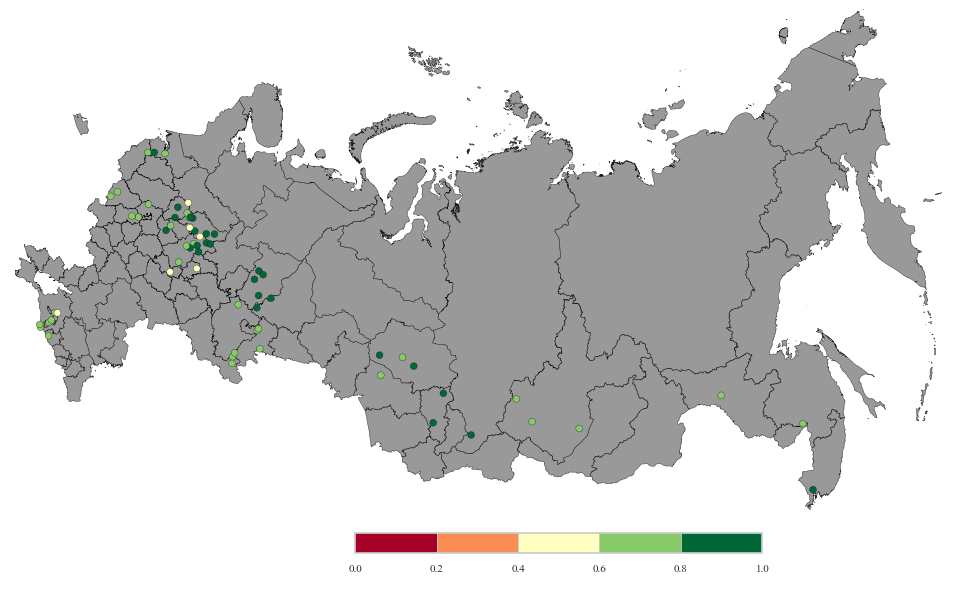

In [116]:
# gr4j_supremacy = compare_table.loc[
#     compare_IEEE[compare_IEEE['gr4j_vs_lstm'] == 'gr4j'].index, ['NSE_gr4j', 'NSE_lstm']]
gr4j_supremacy = compare_table.loc[compare_table[['NSE_gr4j']].dropna(axis=0).index, :]
gr4j_supremacy['diff'] = gr4j_supremacy['NSE_gr4j'] - \
    gr4j_supremacy['NSE_lstm']
gr4j_supremacy['geometry'] = gauges_file.loc[gr4j_supremacy.index, 'geometry']
gr4j_supremacy = gpd.GeoDataFrame(gr4j_supremacy, geometry='geometry')
# gr4j_supremacy = gr4j_supremacy.loc[(gr4j_supremacy['NSE_gr4j'] > 0.5) & (gr4j_supremacy['NSE_lstm'] < 0.5),
#                                     :]
gr4j_supremacy = gr4j_supremacy.loc[(gr4j_supremacy['NSE_gr4j'] > gr4j_supremacy['NSE_lstm']) & (gr4j_supremacy['NSE_gr4j'] > 0.5), :]

russia_plots(gdf_to_plot=gr4j_supremacy,
             distinction_col='',
             metric_col='NSE_gr4j',
             basemap_data=basemap_data,
             figsize=(15, 8),
             title_text='',
             just_points=False);

In [121]:
static_attributes.mean()

for_pc_sse       58.226483
crp_pc_sse       15.017613
inu_pc_ult        4.747915
ire_pc_sse        0.121618
lka_pc_use        0.757725
prm_pc_sse       15.835671
pst_pc_sse        8.958761
cly_pc_sav        9.833960
slt_pc_sav       38.243719
snd_pc_sav       41.359082
kar_pc_sse       15.685885
urb_pc_sse        0.894984
gwt_cm_sav      164.177270
lkv_mc_usu     2003.356367
rev_mc_usu      108.403675
sgr_dk_sav       95.035139
slp_dg_sav        5.320786
ws_area       32617.496094
ele_mt_sav      464.855541
height_bs       203.722370
dtype: float64

In [122]:
static_attributes.loc[gr4j_supremacy.index, :].mean()

for_pc_sse      64.416086
crp_pc_sse      18.020967
inu_pc_ult       3.841843
ire_pc_sse       0.134868
lka_pc_use       0.213653
prm_pc_sse       3.323692
pst_pc_sse       8.553499
cly_pc_sav      11.733853
slt_pc_sav      39.341003
snd_pc_sav      42.354633
kar_pc_sse      16.988366
urb_pc_sse       1.229873
gwt_cm_sav     147.409062
lkv_mc_usu      21.848119
rev_mc_usu       5.183530
sgr_dk_sav      78.270266
slp_dg_sav       4.042139
ws_area       8048.887727
ele_mt_sav     366.566999
height_bs      147.788333
dtype: float64

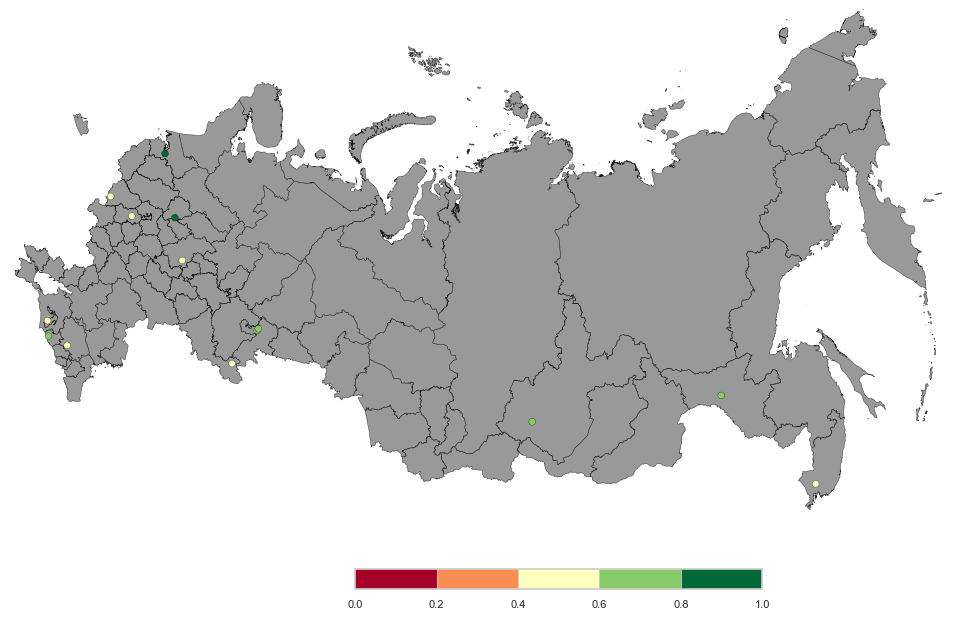

In [89]:
hbv_supremacy = compare_table.loc[
    compare_IEEE[compare_IEEE['hbv_vs_lstm'] == 'hbv'].index, [
        'NSE_hbv', 'NSE_lstm']]
hbv_supremacy['diff'] = hbv_supremacy['NSE_hbv'] - hbv_supremacy['NSE_lstm']
hbv_supremacy['geometry'] = gauges_file.loc[hbv_supremacy.index, 'geometry']
hbv_supremacy = gpd.GeoDataFrame(hbv_supremacy, geometry='geometry')
hbv_supremacy = hbv_supremacy.loc[(hbv_supremacy['NSE_hbv'] > 0.5) & (hbv_supremacy['NSE_lstm'] < 0.5),
                                  :]
russia_plots(gdf_to_plot=hbv_supremacy,
             distinction_col='',
             metric_col='NSE_hbv',
             basemap_data=basemap_data,
             figsize=(15, 8),
             title_text='',
             just_points=False);

In [111]:
static_attributes = pd.read_csv('../geo_data/attributes/static_with_height.csv')
static_attributes['gauge_id'] = static_attributes['gauge_id'].astype(str)
static_attributes = static_attributes.set_index('gauge_id')


geometry
gauge_id                            
49001      POINT (31.41892 65.79876)
49014      POINT (31.05794 65.77917)
49017      POINT (30.33082 66.95957)
49030      POINT (34.23039 65.37582)
49047      POINT (30.50502 64.95504)
...                              ...
4240      POINT (143.03127 53.49538)
1105      POINT (147.66247 61.85056)
4005      POINT (142.93783 53.57969)
76491      POINT (54.67846 55.13715)
9396       POINT (93.42256 61.02101)

[1886 rows x 1 columns]

### Skip to this part

In [98]:
compare_table

NSE_gr4j   NSE_hbv  NSE_lstm  NSE_lstm_ns    NSE_rfr  NSE_rfr_cv  \
2090        NaN       NaN  0.768865     0.579776   0.816147    0.904513   
2103        NaN       NaN  0.729967    -0.487392   0.615364    0.797554   
84037       NaN       NaN -0.138326    -0.306529 -11.417333   -9.511622   
11350       NaN       NaN  0.652255     0.769402   0.348603    0.384816   
48058       NaN       NaN  0.636976     0.241619   0.557624    0.684754   
...         ...       ...       ...          ...        ...         ...   
3076        NaN       NaN  0.583859    -0.165523   0.358640    0.346009   
78087       NaN       NaN  0.104186    -0.152080  -7.173015   -6.035271   
5092   0.685555  0.492004  0.761632     0.531429   0.517001    0.545146   
9290        NaN       NaN  0.823858     0.433845   0.456456    0.492673   
10075       NaN       NaN  0.778118     0.460902   0.429384    0.411807   

      gr4j_vs_lstm hbv_vs_lstm gr4j_vs_lstm_ns hbv_vs_lstm_ns hbv_vs_rfr  \
2090           NaN         NaN         lstm_ns        lstm_ns        rfr   
2103           NaN         NaN         lstm_ns        lstm_ns        rfr   
84037          NaN         NaN         lstm_ns        lstm_ns        rfr   
11350          NaN         NaN         lstm_ns        lstm_ns        rfr   
48058          NaN         NaN         lstm_ns        lstm_ns        rfr   
...            ...         ...             ...            ...        ...   
3076           NaN         NaN         lstm_ns        lstm_ns        rfr   
78087          NaN         NaN         lstm_ns        lstm_ns        rfr   
5092          lstm        lstm            gr4j        lstm_ns        rfr   
9290           NaN         NaN         lstm_ns        lstm_ns        rfr   
10075          NaN         NaN         lstm_ns        lstm_ns        rfr   

      hbv_vs_rfr_cv gr4j_vs_rfr gr4j_vs_rfr_cv lstm_vs_rfr lstm_vs_rfr_cv  \
2090            NaN         rfr            NaN         rfr         rfr_cv   
2103            NaN         rfr            NaN        lstm         rfr_cv   
84037           NaN         rfr            NaN        lstm           lstm   
11350           NaN         rfr            NaN        lstm           lstm   
48058           NaN         rfr            NaN        lstm         rfr_cv   
...             ...         ...            ...         ...            ...   
3076            NaN         rfr            NaN        lstm           lstm   
78087           NaN         rfr            NaN        lstm           lstm   
5092         rfr_cv        gr4j           gr4j        lstm           lstm   
9290            NaN         rfr            NaN        lstm           lstm   
10075           NaN         rfr            NaN        lstm           lstm   

      lstm_ns_vs_rfr lstm_ns_vs_rfr_cv lstm_vs_lstm_ns  
2090             rfr            rfr_cv            lstm  
2103             rfr            rfr_cv            lstm  
84037        lstm_ns           lstm_ns            lstm  
11350        lstm_ns           lstm_ns         lstm_ns  
48058            rfr            rfr_cv            lstm  
...              ...               ...             ...  
3076             rfr            rfr_cv            lstm  
78087        lstm_ns           lstm_ns            lstm  
5092         lstm_ns            rfr_cv            lstm  
9290             rfr            rfr_cv            lstm  
10075        lstm_ns           lstm_ns            lstm  

[911 rows x 19 columns]

In [99]:
compared_gauges = gauges_file[['geometry']]
compared_gauges[['gr4j_vs_lstm', 'hbv_vs_lstm',
                 'gr4j_vs_lstm_ns', 'hbv_vs_lstm_ns']] = compare_table[['gr4j_vs_lstm', 'hbv_vs_lstm',
                                                                        'gr4j_vs_lstm_ns', 'hbv_vs_lstm_ns']]
compared_gauges = compared_gauges.loc[~compared_gauges['gr4j_vs_lstm'].isna(
), :]

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [58]:
nse_file = gauges_file[['geometry']]
nse_file[['NSE_gr4j', 'NSE_hbv', 'NSE_lstm',
          'NSE_lstm_ns', 'NSE_rfr', 'NSE_rfr_cv']] = compare_table[['NSE_gr4j', 'NSE_hbv', 'NSE_lstm',
                                                                    'NSE_lstm_ns', 'NSE_rfr', 'NSE_rfr_cv']]
nse_file = nse_file.loc[~nse_file['NSE_lstm'].isna(), :]
nse_file

/Users/dmbrmv/miniconda3/envs/geo/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


geometry  NSE_gr4j   NSE_hbv  NSE_lstm  \
gauge_id                                                             
49014      POINT (31.05794 65.77917)       NaN       NaN  0.544290   
49047      POINT (30.50502 64.95504)       NaN       NaN  0.683292   
49052      POINT (31.14297 65.21779)       NaN       NaN  0.846952   
49058      POINT (32.11508 64.75309) -1.757978 -0.932752  0.816702   
49070      POINT (34.71204 64.74240)  0.178350  0.351561  0.477104   
...                              ...       ...       ...       ...   
2027      POINT (157.97093 54.16468)       NaN       NaN  0.478540   
72191      POINT (33.87509 59.49075)       NaN       NaN -8.680100   
49053      POINT (31.22690 65.19361)       NaN       NaN  0.661735   
2107      POINT (158.36421 53.18661)       NaN       NaN  0.785542   
7176      POINT (103.69834 51.64244)       NaN       NaN  0.296994   

          NSE_lstm_ns   NSE_rfr  NSE_rfr_cv  
gauge_id                                     
49014        0.638239  0.577663    0.558769  
49047        0.234485  0.517304    0.479409  
49052        0.548791  0.751701    0.718761  
49058       -0.296881  0.690607    0.660461  
49070        0.256056  0.570786    0.544739  
...               ...       ...         ...  
2027         0.692436  0.685237    0.639462  
72191       -8.682244       NaN         NaN  
49053        0.181012  0.681434    0.673569  
2107         0.795215  0.560995    0.883711  
7176         0.209563  0.186816    0.127144  

[911 rows x 7 columns]

In [179]:
# give ugms some shine
for i, geom in enumerate(tqdm(basin_districts['geometry'])):

    ugms_part = nse_file.loc[[geom.intersects(gage_point)
                              for gage_point in nse_file['geometry']], :]
    ugms_name = basin_districts.loc[i, 'name1']

    basin_districts.loc[i, ['NSE_gr4j', 'NSE_hbv', 'NSE_lstm',
                            'NSE_lstm_ns', 'NSE_rfr', 'NSE_rfr_cv']] = ugms_part[['NSE_gr4j', 'NSE_hbv', 'NSE_lstm',
                                                                                  'NSE_lstm_ns', 'NSE_rfr', 'NSE_rfr_cv']].median()
basin_districts.loc[[25, 26, 27], ['NSE_gr4j', 'NSE_hbv', 'NSE_lstm',
                                   'NSE_lstm_ns', 'NSE_rfr', 'NSE_rfr_cv']] = np.NaN

  0%|          | 0/28 [00:00<?, ?it/s]

In [ ]:
meteo_nse = russia_plots_n(gdf_to_plot=nse_file,
                           basemap_data=basemap_data,
                           figsize=(15, 8),
                           nrows=2,
                           ncols=3,
                           label_list=['а)', 'б)', 'в)', 'г)', 'д)', 'е)'],
                           columns_from_gdf=['NSE_gr4j', 'NSE_hbv', 'NSE_lstm',
                                             'NSE_lstm_ns', 'NSE_rfr', 'NSE_rfr_cv'],
                           with_histogram=True, title_text=[f'NSE для HBV,\nNSE = {nse_gr4j:.2f}',
                                                            f'NSE для GR4J,\nNSE = {nse_hbv:.2f}',
                                                            f'NSE для LSTM с осадками ERA5-Land,\nNSE = {nse_lstm:.2f}',
                                                            f'NSE для LSTM с осадками ERA5-Land без физ.гео параметров,\nNSE = {nse_lstm_ns:.2f}',
                                                            f'NSE для Random Forest Regressor,\nNSE = {nse_rfr:.2f}',
                                                            f'NSE для Random Forest Regressor (cross-validation),\nNSE = {nse_rfr_cv:.2f}'],
                           ugms=True, ugms_gdf=basin_districts)

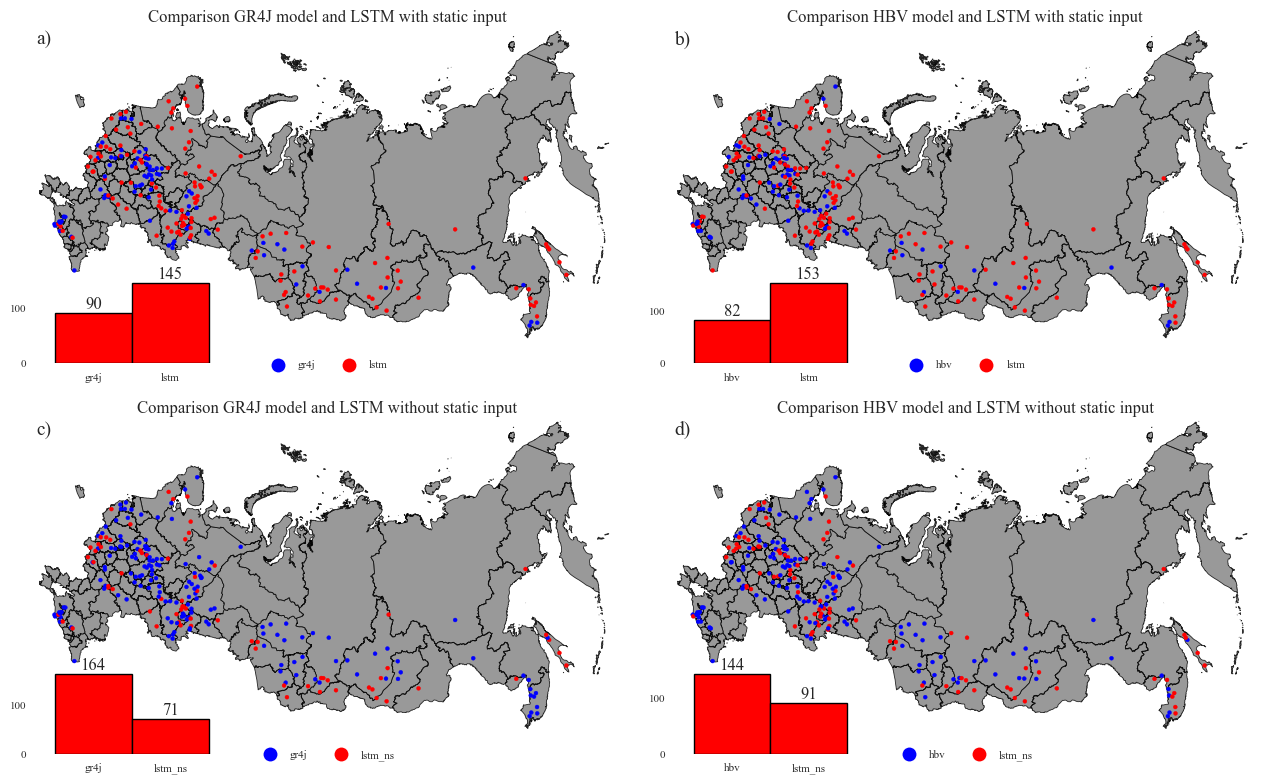

In [101]:
сompare_nse = russia_plots_n(gdf_to_plot=compared_gauges,
                             basemap_data=basemap_data,
                             figsize=(15, 8),
                             nrows=2,
                             ncols=2,
                             cmap_name='bwr',
                             label_list=['a)', 'b)', 'c)', 'd)'],
                             columns_from_gdf=['gr4j_vs_lstm', 'hbv_vs_lstm',
                                               'gr4j_vs_lstm_ns', 'hbv_vs_lstm_ns'],
                             with_histogram=True, title_text=['Comparison GR4J model and LSTM with static input', 'Comparison HBV model and LSTM with static input',
                                                              'Comparison GR4J model and LSTM without static input', 'Comparison HBV model and LSTM without static input'],
                             just_points=True,
                             ugms=False, ugms_gdf=basin_districts)
сompare_nse.savefig('./images/IEE_PLOT_compare.pdf',
                    dpi=600, bbox_inches='tight')

### Based conclusions

In [ ]:
# ugms_shp = gpd.read_file(
#     '../geo_data/great_db/geometry/ugms.shp')[['name1', 'geometry']]
# # Update geometrty in UGMS based on available gage stations
# # sib
# srednesib_limit = gpd.read_file(
#     '../geo_data/great_db/geometry/srednesib_lim.gpkg')
# ugms_shp.loc[len(ugms_shp)+1, ['name1', 'geometry']] = ['Среднесибирское, ограниченное', ugms_shp.loc[17,
#                                                                                                       'geometry'].intersection(srednesib_limit.loc[0, 'geometry'])]
# # yakutsk
# yakutsk_limit = gpd.read_file(
#     '../geo_data/great_db/geometry/yakut_lim.gpkg')
# ugms_shp.loc[len(ugms_shp)+1, ['name1', 'geometry']] = ['Якутское, ограниченное', ugms_shp.loc[23,
#                                                                                                'geometry'].intersection(yakutsk_limit.loc[0, 'geometry'])]
# # chukotka
# chukotka_limit = gpd.read_file(
#     '../geo_data/great_db/geometry/chukot_limit.gpkg')
# ugms_shp.loc[len(ugms_shp)+1, ['name1', 'geometry']] = [
#     'Чукотское, ограниченное', ugms_shp.loc[22, 'geometry'].intersection(
#         chukotka_limit.loc[0, 'geometry'])]
# ugms_shp = ugms_shp.reset_index(drop=True)
# # fixed umgs shapes 
# ugms_shp = ugms_shp.reindex([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
#                              12, 13, 14, 15, 16, 25, 18, 19, 20, 21,
#                              27, 26, 24, 17, 23, 22])
# ugms_shp = ugms_shp.reset_index(drop=True)

In [7]:
wholeRussiaEval = np.load('./verif_metrics_20210930.npy',
                          allow_pickle=True).item()

forecastHindcast = np.load('./oper_hindcasts_and_forecasts.npy',
                           allow_pickle=True).item()

actualObs = np.load('./obs_and_qfh_stat_and_hist_hindcasts.npy',
                    allow_pickle=True).item()

In [18]:
ref_df = pd.DataFrame()
for gauge, metrics in wholeRussiaEval['GR4J_NSE']['0'].items():
    ref_df.loc[gauge, 'NSE'] = metrics['NSE']
    ref_df.loc[gauge, 'KGE'] = metrics['KGE']
    ref_df.loc[gauge, 'r'] = metrics['PearsonR']
    ref_df.loc[gauge, 'beta'] = metrics['BIAS']
ref_df.dropna().to_csv('./tables/GR4J_ayzel_res.csv')


In [6]:
import sys
sys.path.append('/workspaces/my_dissertation')
from conceptual_runs.scripts.data_readers import metric_df
import pandas as pd
import glob

lstm_no_static = list()
for f in glob.glob('./results/lstm/*.csv'):
    gauge_id = f.split('/')[-1][:-4]
    
    t = pd.read_csv(f)
    
    pred, target = t['q_mm_day_sim'], t['q_mm_day_obs']
    
    lstm_no_static.append(metric_df(gauge_id, pred, target))
pd.concat(lstm_no_static).to_csv('./tables/LSTM_no_static_res.csv')

lstm_static = list()
    
for f in glob.glob('./results/lstm_static/*.csv'):
    gauge_id = f.split('/')[-1][:-4]
    
    t = pd.read_csv(f)
    
    pred, target = t['q_mm_day_sim'], t['q_mm_day_obs']
    
    lstm_static.append(metric_df(gauge_id, pred, target))
pd.concat(lstm_static).to_csv('./tables/LSTM_static_res.csv')


### Best meteo input

In [124]:
test_df

q_cms_s  q_mm_day  lvl_sm    prcp_e5  prcp_e5l  prcp_gpcp   
date                                                                    
2008-01-01     0.29  0.125257    98.0  10.224018  1.349438   0.661902  \
2008-01-02     0.30  0.129576    99.0  16.917299  2.224435   0.394628   
2008-01-03     0.30  0.129576    99.0   4.906432  0.651298   0.073903   
2008-01-04     0.30  0.129576    99.0   0.209901  0.027969   0.086330   
2008-01-05     0.30  0.129576    99.0  15.489159  2.045221   0.194593   
...             ...       ...     ...        ...       ...        ...   
2020-12-27     0.26  0.112299    98.0   0.036662  0.004931   0.000000   
2020-12-28     0.26  0.112299    98.0   0.003681  0.000488   0.000000   
2020-12-29     0.26  0.112299    98.0   0.005162  0.000684   0.103384   
2020-12-30     0.26  0.112299    98.0   1.618465  0.212388   0.399752   
2020-12-31     0.26  0.112299    98.0   1.654319  0.218064   0.000000   

            prcp_imerg  prcp_mswep  
date                                
2008-01-01    4.259790    0.684862  
2008-01-02    0.666838    1.141161  
2008-01-03    0.993880    0.254522  
2008-01-04    0.639017    0.000000  
2008-01-05    0.304980    0.667778  
...                ...         ...  
2020-12-27    0.264091    0.000000  
2020-12-28    0.052935    0.000000  
2020-12-29    1.444995    0.000000  
2020-12-30    0.781741    0.269615  
2020-12-31    0.637510         NaN  

[4749 rows x 8 columns]

In [138]:
pd.concat(res_df, axis=0)

prcp_e5  prcp_e5l  prcp_gpcp  prcp_imerg  prcp_mswep
10620  0.023689  0.023284  -0.010829    0.023076    0.019003
4197   0.089042  0.090665   0.047455   -0.007693    0.085626
8306   0.302196  0.302414   0.257192    0.247418    0.273573
78614 -0.022609 -0.022651  -0.022767   -0.025705   -0.003252
5287   0.126174  0.126194   0.087967    0.091244    0.111467
...         ...       ...        ...         ...         ...
72660 -0.042199 -0.042254  -0.030826   -0.028795   -0.048799
75576 -0.018645 -0.018682  -0.023123   -0.023089   -0.032533
83288  0.215020  0.213392   0.086547    0.061690    0.198657
4012        NaN  0.081573   0.037686         NaN         NaN
3210   0.058668  0.058628   0.037376         NaN    0.036069

[1114 rows x 5 columns]

In [ ]:
def get_r2(df,
           frequency: str,
           prcp_col: str,
           hydro_col: str = 'q_mm_day'):
    df = df.groupby(pd.Grouper(freq=frequency)).sum()
    df = pd.concat([df[prcp_col], df[hydro_col]], axis=1).dropna()
    return pearsonr(x=df[hydro_col], y=df[prcp_col])

r2_meteo = dict()
for freq in ['1D', '7D', '30D']:
    res_df = list()
    for file in tqdm(glob.glob('../geo_data/great_db/nc_all_q/*.nc')):
        
        gauge_id = file.split('/')[-1][:-3]
        test_df = xr.open_dataset(file)
        test_df = test_df.to_dataframe()[['q_cms_s', 'q_mm_day', 'lvl_sm',
                                        'prcp_e5', 'prcp_e5l',
                                        'prcp_gpcp', 'prcp_imerg',
                                        'prcp_mswep']]

        res_df.append(pd.DataFrame({prcp_col: get_r2(df=test_df,
                                                     frequency=freq,
                                                     prcp_col=prcp_col,
                                                     hydro_col='q_mm_day')[0]
        for prcp_col in ['prcp_e5', 'prcp_e5l', 'prcp_gpcp',
                         'prcp_imerg', 'prcp_mswep']},
                                   index=[gauge_id]))
    res_df = pd.concat(res_df, axis=0)
    res_df.index.name = 'gauge_id'
    geom_r2 = gauges_file.set_index('gauge_id').join(res_df).dropna()
    r2_meteo[freq] = geom_r2

In [144]:
def r2_descriptor(r2_df: pd.DataFrame,
                  prcp_col: str,
                  day_range: str):
    res_df = pd.DataFrame()
    res_df.loc[0, 'Сумма за дней:'] = day_range
    res_df.loc[0, 'Источник реанализа'] = prcp_col
    
    res_df.loc[0, 'Объектов в выборке'] = f'{len(r2_df):.0f}'
    
    nse_max = r2_df[prcp_col].max()
    res_df.loc[0, 'Максимальная корреляция'] = f'{nse_max:.2f}'
    
    nse_median = r2_df[prcp_col].median()
    res_df.loc[0, 'Медианная корреляция'] = f'{nse_median:.2f}'
    
    nse_mean = r2_df[prcp_col].mean()
    res_df.loc[0, 'Средняя корреляция'] = f'{nse_mean:.2f}'
    
    nse_min = r2_df[prcp_col].min()
    res_df.loc[0, 'Минимальная корреляция'] = f'{nse_min:.2f}'
    
    nse_less_t_z = (r2_df[prcp_col] < 0).sum()
    res_df.loc[0, 'Корреляция < 0'] = f'{nse_less_t_z:.0f}'
        
    return res_df

### Meteo Correlation table

In [145]:
r2_1d = list()
for met_col in ['prcp_e5', 'prcp_e5l', 'prcp_gpcp', 'prcp_imerg', 'prcp_mswep']:
    r2_1d.append(r2_descriptor(r2_df=r2_meteo['1D'], prcp_col=met_col, day_range='1 день'))
r2_1d_df = pd.concat(r2_1d)
r2_7d = list()
for met_col in ['prcp_e5', 'prcp_e5l', 'prcp_gpcp', 'prcp_imerg', 'prcp_mswep']:
    r2_7d.append(r2_descriptor(r2_df=r2_meteo['7D'], prcp_col=met_col, day_range='7 дней'))
r2_7d_df = pd.concat(r2_7d)
r2_30d = list()
for met_col in ['prcp_e5', 'prcp_e5l', 'prcp_gpcp', 'prcp_imerg', 'prcp_mswep']:
    r2_30d.append(r2_descriptor(r2_df=r2_meteo['30D'], prcp_col=met_col, day_range='30 дней'))
r2_30d_df = pd.concat(r2_30d)
res_df = pd.concat([r2_1d_df, r2_7d_df, r2_30d_df]).reset_index(drop=True)
test_df = res_df.set_index(['Сумма за дней:', 'Источник реанализа'],
                           append=False)
test_df.to_csv('./results/r2_meteo.csv')

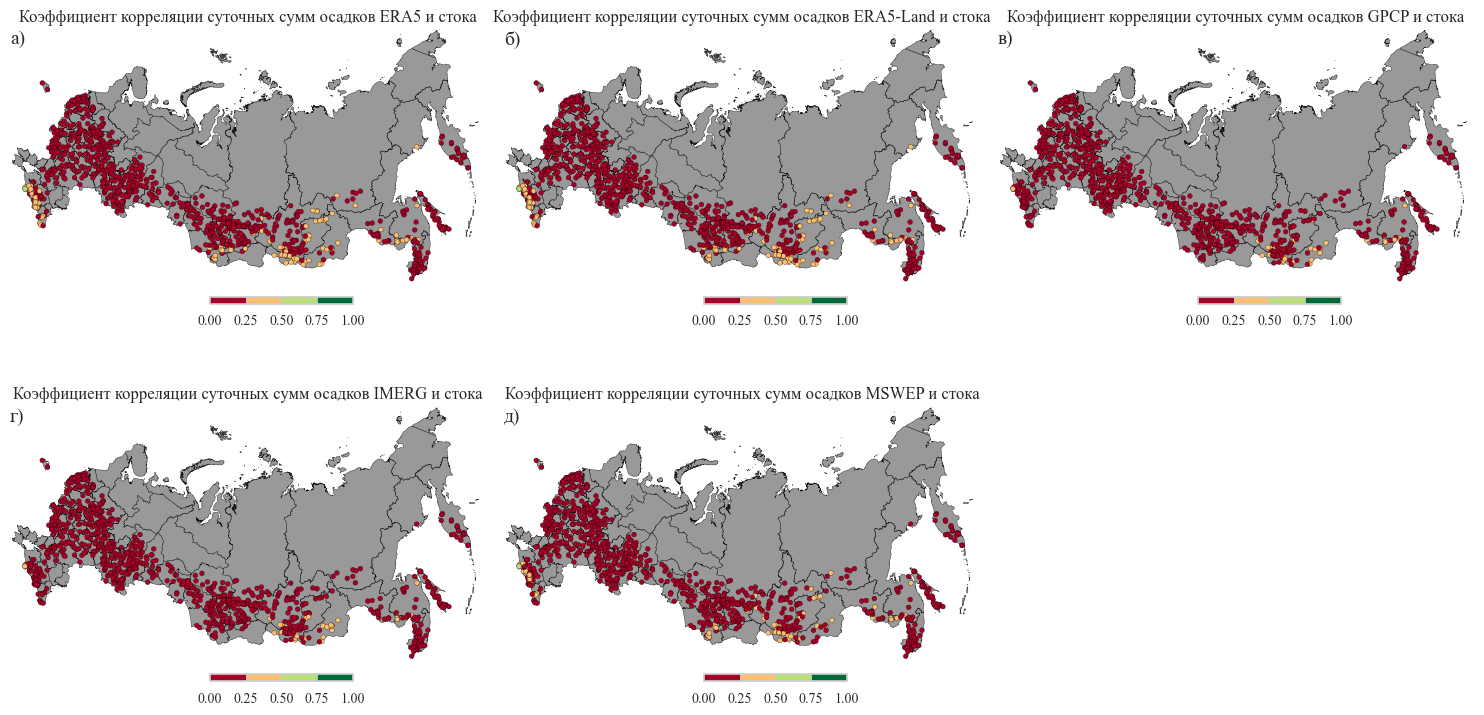

In [156]:
r2_plots = russia_plots_n(
    gdf_to_plot=r2_meteo['1D'],
    basemap_data=basemap_data,
    cmap_name='RdYlGn',
    figsize=(15, 8),
    label_list=['а)', 'б)', 'в)', 'г)', 'д)'],
    nrows=2,
    ncols=3,
    columns_from_gdf=['prcp_e5', 'prcp_e5l',
                      'prcp_gpcp', 'prcp_imerg',
                      'prcp_mswep'],
    with_histogram=False, title_text=['Коэффициент корреляции суточных сумм осадков ERA5 и стока',
                                      'Коэффициент корреляции суточных сумм осадков ERA5-Land и стока',
                                      'Коэффициент корреляции суточных сумм осадков GPCP и стока',
                                      'Коэффициент корреляции суточных сумм осадков IMERG и стока',
                                      'Коэффициент корреляции суточных сумм осадков MSWEP и стока'])
r2_plots.savefig('./images/r2_plots_1d.png',
                 dpi=1500, bbox_inches='tight')

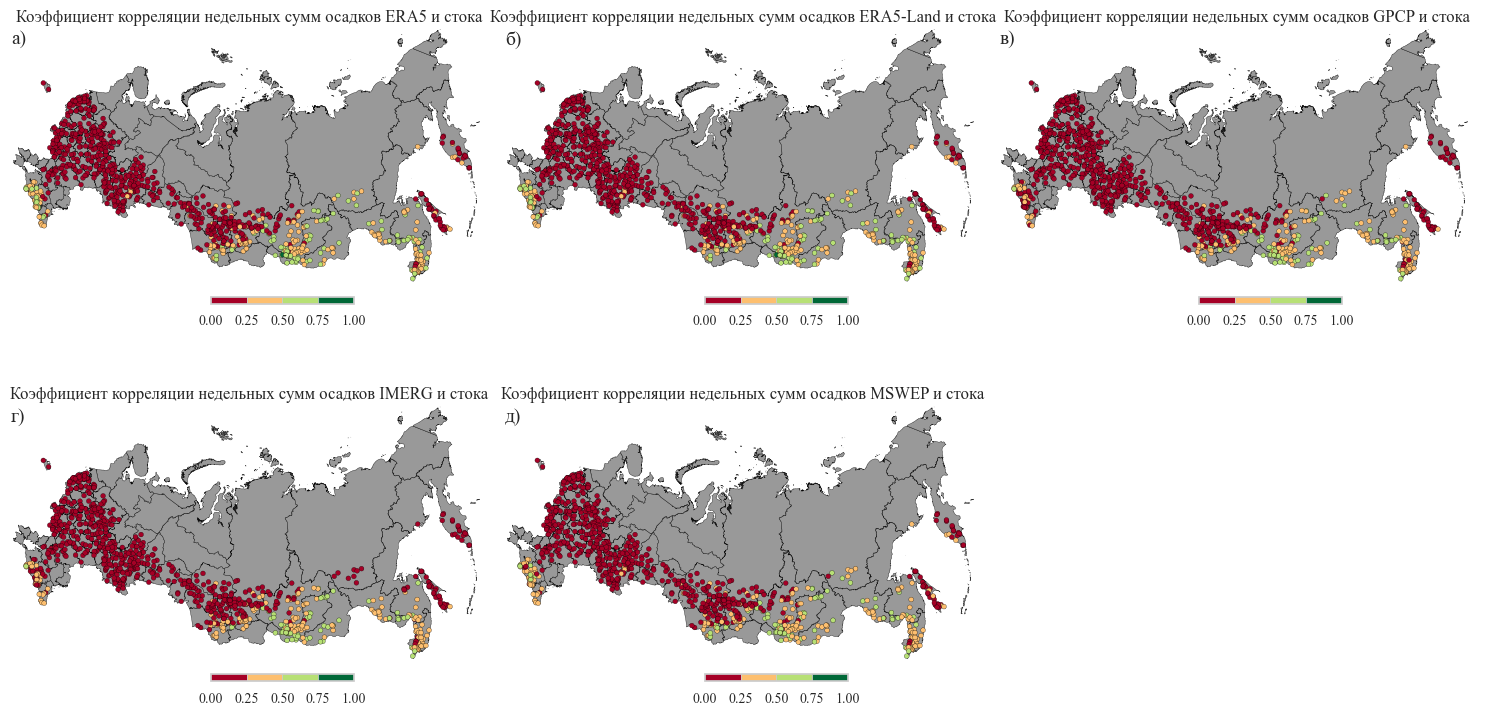

In [152]:
r2_plots_7d = russia_plots_n(
    gdf_to_plot=r2_meteo['7D'],
    basemap_data=basemap_data,
    figsize=(15, 8),
    label_list=['а)', 'б)', 'в)', 'г)', 'д)'],
    nrows=2,
    ncols=3,
    columns_from_gdf=['prcp_e5', 'prcp_e5l',
                                 'prcp_gpcp', 'prcp_imerg',
                                 'prcp_mswep'],
    with_histogram=False, title_text=['Коэффициент корреляции недельных сумм осадков ERA5 и стока',
                                      'Коэффициент корреляции недельных сумм осадков ERA5-Land и стока',
                                      'Коэффициент корреляции недельных сумм осадков GPCP и стока',
                                      'Коэффициент корреляции недельных сумм осадков IMERG и стока',
                                      'Коэффициент корреляции недельных сумм осадков MSWEP и стока'])
r2_plots_7d.savefig('./images/r2_plots_7d.png',
                    dpi=1500, bbox_inches='tight')

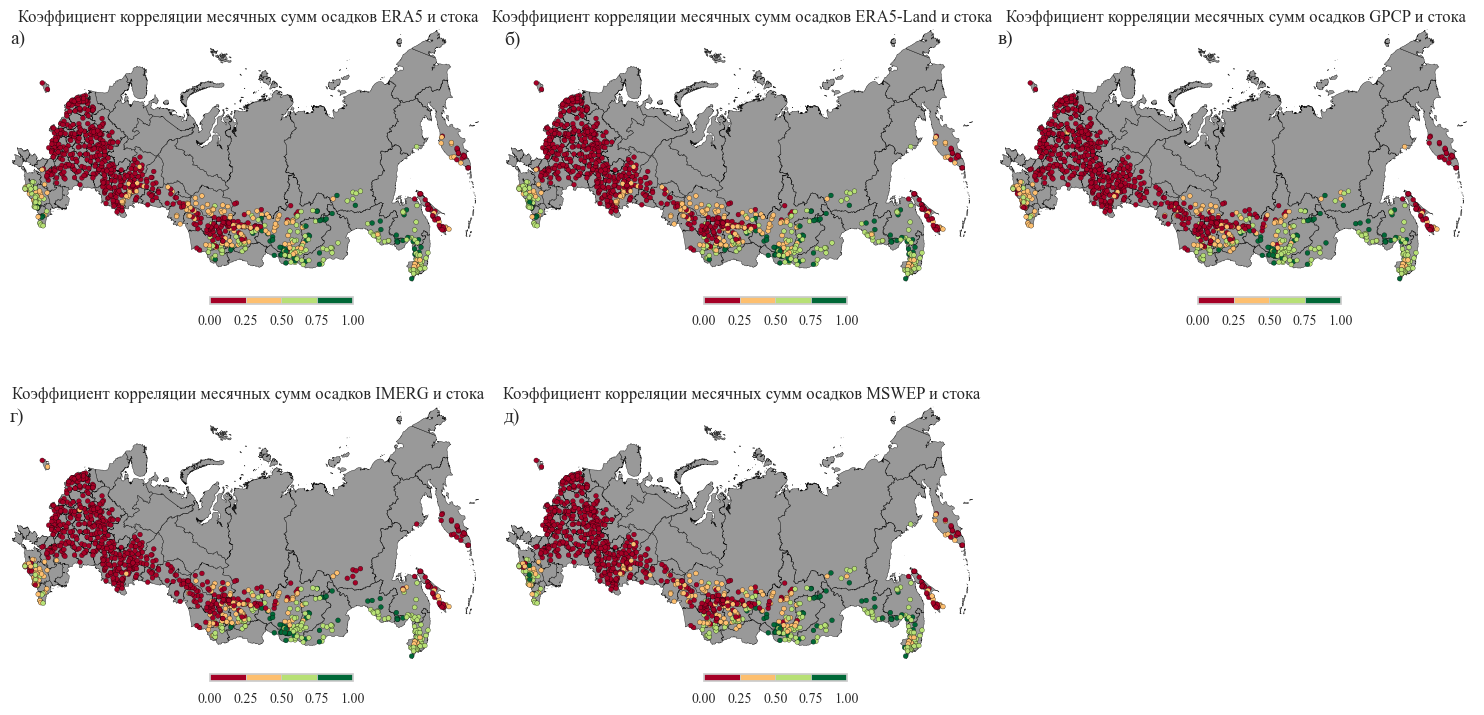

In [154]:
r2_plots_30d = russia_plots_n(
    gdf_to_plot=r2_meteo['30D'],
    basemap_data=basemap_data,
    figsize=(15, 8),
    label_list=['а)', 'б)', 'в)', 'г)', 'д)'],
    nrows=2,
    ncols=3,
    columns_from_gdf=['prcp_e5', 'prcp_e5l',
                      'prcp_gpcp', 'prcp_imerg',
                      'prcp_mswep'],
    with_histogram=False, title_text=['Коэффициент корреляции месячных сумм осадков ERA5 и стока',
                                      'Коэффициент корреляции месячных сумм осадков ERA5-Land и стока',
                                      'Коэффициент корреляции месячных сумм осадков GPCP и стока',
                                      'Коэффициент корреляции месячных сумм осадков IMERG и стока',
                                      'Коэффициент корреляции месячных сумм осадков MSWEP и стока'])
r2_plots_30d.savefig('./images/r2_plots_30d.png',
                     dpi=1500, bbox_inches='tight')

### Different meteo input

In [62]:
# lstm era5l
lstm_era5l, nse_era5l = metric_viewer(metric_csv='../test_meteo_input/runs_static/era5L_static_SmallMedium_0205_095021/test/model_epoch024/test_metrics.csv',
                                      metric_col='NSE',
                                      gauges_file=gauges_file)
# lstm era5
lstm_era5, nse_era5 = metric_viewer(metric_csv='../test_meteo_input/runs_static/era5_SmallMedium_1205_112433/test/model_epoch021/test_metrics.csv',
                                    metric_col='NSE',
                                    gauges_file=gauges_file)
# lstm gpcp
lstm_gpcp, nse_gpcp = metric_viewer(metric_csv='../test_meteo_input/runs_static/gpcp_SmallMedium_1205_054740/test/model_epoch030/test_metrics.csv',
                                         metric_col='NSE',
                                         gauges_file=gauges_file)
# lstm imerg
lstm_imerg, nse_imerg = metric_viewer(metric_csv='../test_meteo_input/runs_static/imerg_SmallMedium_1205_085602/test/model_epoch030/test_metrics.csv',
                                      metric_col='NSE',
                                      gauges_file=gauges_file)
# lstm mswep
lstm_mswep, nse_mswep = metric_viewer(metric_csv='../test_meteo_input/runs_static/mswep_static_SmallMedium_0205_153244/test/model_epoch021/test_metrics.csv',
                                          metric_col='NSE',
                                          gauges_file=gauges_file)
# lstm no static
lstm_no_static, nse_no_static = metric_viewer(metric_csv='../test_meteo_input/runs_no_static/era5Land_prcp_0604_111347/test/model_epoch030/test_metrics.csv',
                                              metric_col='NSE',
                                              gauges_file=gauges_file)
# file for table
nse_file = gpd.GeoDataFrame(geometry=lstm_era5['geometry'])
nse_file.index = lstm_era5.index
nse_file[['name_ru', 'name_en']] = lstm_era5[['name_ru', 'name_en']]
nse_file['NSE_era5l'] = lstm_era5l['NSE']
nse_file['NSE_era5'] = lstm_era5['NSE']
nse_file['NSE_gpcp'] = lstm_gpcp['NSE']
nse_file['NSE_imerg'] = lstm_imerg['NSE']
nse_file['NSE_mswep'] = lstm_mswep['NSE']
nse_file['NSE_no_static'] = lstm_no_static['NSE']
# get rid of imerg errors
# nse_file = nse_file.replace(np.NaN, 0)
nse_file[['NSE_era5l', 'NSE_era5', 'NSE_gpcp',
          'NSE_imerg', 'NSE_mswep', 'NSE_no_static']] = nse_file[
              ['NSE_era5l', 'NSE_era5', 'NSE_gpcp',
               'NSE_imerg', 'NSE_mswep', 'NSE_no_static']].clip(lower=0)
# give ugms some shine
for i, geom in enumerate(tqdm(basin_districts['geometry'])):

    ugms_part = nse_file.loc[[geom.intersects(gage_point)
                              for gage_point in nse_file['geometry']], :]
    ugms_name = basin_districts.loc[i, 'name1']

    basin_districts.loc[i, ['NSE_era5l', 'NSE_era5', 'NSE_gpcp',
                     'NSE_imerg', 'NSE_mswep', 'NSE_no_static']] = ugms_part[['NSE_era5l', 'NSE_era5', 'NSE_gpcp',
                                                                              'NSE_imerg', 'NSE_mswep', 'NSE_no_static']].median()
basin_districts.loc[[25, 26, 27], ['NSE_era5l', 'NSE_era5', 'NSE_gpcp',
                     'NSE_imerg', 'NSE_mswep', 'NSE_no_static']] = np.NaN

A Jupyter Widget

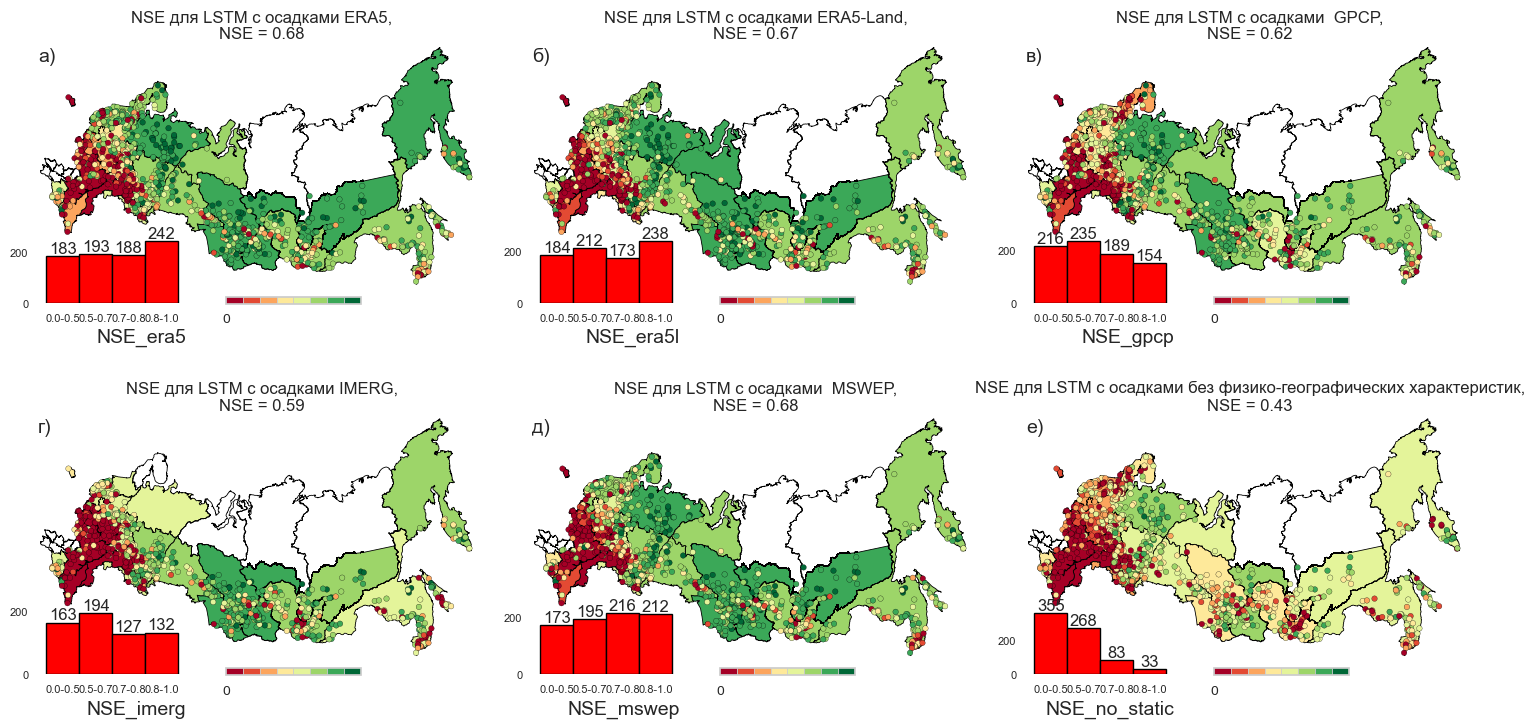

In [16]:
meteo_nse = russia_plots_n(gdf_to_plot=nse_file,
                           basemap_data=basemap_data,
                           figsize=(15, 8),
                           nrows=2,
                           ncols=3,
                           label_list=['а)', 'б)', 'в)', 'г)', 'д)', 'е)'],
                           columns_from_gdf=['NSE_era5', 'NSE_era5l', 'NSE_gpcp',
                                             'NSE_imerg', 'NSE_mswep', 'NSE_no_static'],
                           with_histogram=True, title_text=[f'NSE для LSTM с осадками ERA5,\nNSE = {nse_era5:.2f}',
                                                            f'NSE для LSTM с осадками ERA5-Land,\nNSE = {nse_era5l:.2f}',
                                                            f'NSE для LSTM с осадками  GPCP,\nNSE = {nse_gpcp:.2f}',
                                                            f'NSE для LSTM с осадками IMERG,\nNSE = {nse_imerg:.2f}',
                                                            f'NSE для LSTM с осадками  MSWEP,\nNSE = {nse_mswep:.2f}',
                                                            f'NSE для LSTM с осадками без физико-географических характеристик,\nNSE = {nse_no_static:.2f}'],
                           ugms=True, ugms_gdf=basin_districts)
meteo_nse.savefig('./images/meteo_nse.png',
                  dpi=1500, bbox_inches='tight')

### Model comparison for IEEE

In [4]:
temp = pd.read_csv('./tables/GR4J_ayzel_res.csv')
temp = temp.rename(columns={'Unnamed: 0': 'gauge_id'})
temp.to_csv('./tables/GR4J_ayzel_res.csv', index=False)

In [66]:
# lstm + static
lstm_era5l, nse_lstm_static = metric_viewer(metric_csv='../test_meteo_input/runs_static/era5L_static_SmallMedium_0205_095021/test/model_epoch024/test_metrics.csv',
                                            metric_col='NSE',
                                            gauges_file=gauges_file)
# lstm (only meteo)
lstm_no_static, nse_lstm_meteo = metric_viewer(metric_csv='../test_meteo_input/runs_no_static/era5Land_prcp_0604_111347/test/model_epoch030/test_metrics.csv',
                                               metric_col='NSE',
                                               gauges_file=gauges_file)
# hbv
hbv_ayzel, nse_hbv_ayzel = metric_viewer(metric_csv='./tables/HBV_ayzel_res.csv',
                                         metric_col='NSE',
                                         gauges_file=gauges_file)
# gr4j
gr4j_ayzel, nse_gr4j_ayzel = metric_viewer(metric_csv='./tables/GR4J_ayzel_res.csv',
                                           metric_col='NSE',
                                           gauges_file=gauges_file)

ws_file = ws_file.loc[lstm_era5l.index, :]


nse_file = gpd.GeoDataFrame(geometry=lstm_era5l['geometry'])
nse_file.index = lstm_era5l.index
nse_file[['name_ru', 'name_en']] = lstm_era5l[['name_ru', 'name_en']]
nse_file['NSE EA-LSTM'] = lstm_era5l['NSE']
nse_file['NSE LSTM'] = lstm_no_static.loc[[True if x in lstm_era5l.index
                                           else False
                                           for x
                                           in lstm_no_static.index], :]['NSE']
nse_file['NSE HBV'] = hbv_ayzel['NSE']
nse_file['NSE GR4J'] = gr4j_ayzel['NSE']

# get rid of imerg errors
# nse_file = nse_file.replace(np.NaN, 0)
nse_file[['NSE EA-LSTM', 'NSE LSTM', 'NSE HBV', 'NSE GR4J']] = nse_file[
    ['NSE EA-LSTM', 'NSE LSTM', 'NSE HBV', 'NSE GR4J']].clip(lower=0)

for i, geom in enumerate(tqdm(basin_districts['geometry'])):

    ugms_part = nse_file.loc[[geom.intersects(gage_point)
                              for gage_point in nse_file['geometry']], :]
    ugms_name = basin_districts.loc[i, 'name1']

    basin_districts.loc[i, ['NSE EA-LSTM', 'NSE LSTM', 'NSE HBV', 'NSE GR4J']
                        ] = ugms_part[['NSE EA-LSTM', 'NSE LSTM',
                                       'NSE HBV', 'NSE GR4J']].median()
                        
basin_districts.loc[[26, 27], ['NSE EA-LSTM',
                               'NSE LSTM', 'NSE HBV', 'NSE GR4J']] = np.NaN





A Jupyter Widget

In [81]:
import pandas as pd
import sys
sys.path.append('/home/anton/dima_experiments/my_dissertation')
from visualizations.scripts.drawer import metric_viewer

# hbv
hbv_ayzel = pd.read_csv('./tables/HBV_ayzel_res.csv',
                         index_col='gauge_id')
hbv_ayzel.index = hbv_ayzel.index.astype(str)
# gr4j
gr4j_ayzel = pd.read_csv('./tables/GR4J_ayzel_res.csv',
                         index_col='gauge_id')
gr4j_ayzel.index = gr4j_ayzel.index.astype(str)

lstm_era5l = pd.read_csv('./tables/LSTM_static_res.csv',
                         index_col='gauge_id')
lstm_era5l.index.name = 'gauge_id'
lstm_era5l.index = lstm_era5l.index.astype(str)

lstm_no_static = pd.read_csv('./tables/LSTM_no_static_res.csv',
                         index_col='gauge_id')
lstm_no_static.index.name = 'gauge_id'
lstm_no_static.index = lstm_no_static.index.astype(str)

In [82]:
cross_gr4j = gr4j_ayzel.loc[gr4j_ayzel.index.isin(lstm_era5l.index)]
cross_gr4j = cross_gr4j[['NSE', 'KGE', 'r', 'beta']]
cross_hbv = hbv_ayzel.loc[hbv_ayzel.index.isin(lstm_era5l.index)]
cross_hbv = cross_hbv[['NSE', 'KGE', 'r', 'beta']]

cross_lstm = lstm_era5l.loc[lstm_era5l.index.isin(cross_hbv.index)]
cross_lstm = cross_lstm[['NSE', 'KGE', 'r', 'beta']]

cross_lstm_ns = lstm_no_static.loc[lstm_no_static.index.isin(cross_hbv.index)]
cross_lstm_ns = cross_lstm_ns[['NSE', 'KGE', 'r', 'beta']]

In [83]:
stat_df = pd.DataFrame()
stat_df.index.name = 'Model'
for model, df in {'LSTM-static': cross_lstm,
                  'LSTM': cross_lstm_ns,
                  'HBV': cross_hbv,
                  'GR4J': cross_gr4j}.items():
    cols = df.columns
    stat_df.loc[model, cols] = df.median().values
    stat_df.loc[model, 'NSE>0.5'] = sum(df['NSE'] > 0.5)
stat_df

NSE       KGE         r      beta  NSE>0.5
Model                                                       
LSTM-static  0.707803  0.686369  0.875550  1.014403    165.0
LSTM         0.478465  0.437377  0.772485  1.103848    114.0
HBV          0.534144  0.604575  0.817865 -0.444003    130.0
GR4J         0.645797  0.637641  0.847221 -0.943268    146.0

In [13]:
pd.read_csv('./tables/LSTM_static_res.csv',
                         index_col='Unnamed: 0')['beta'].median()

1.0049031477796977

In [64]:
stat_df.to_csv('./tables/compare_table.csv')


In [84]:
stat_df

NSE       KGE         r      beta  NSE>0.5
Model                                                       
LSTM-static  0.707803  0.686369  0.875550  1.014403    165.0
LSTM         0.478465  0.437377  0.772485  1.103848    114.0
HBV          0.534144  0.604575  0.817865 -0.444003    130.0
GR4J         0.645797  0.637641  0.847221 -0.943268    146.0

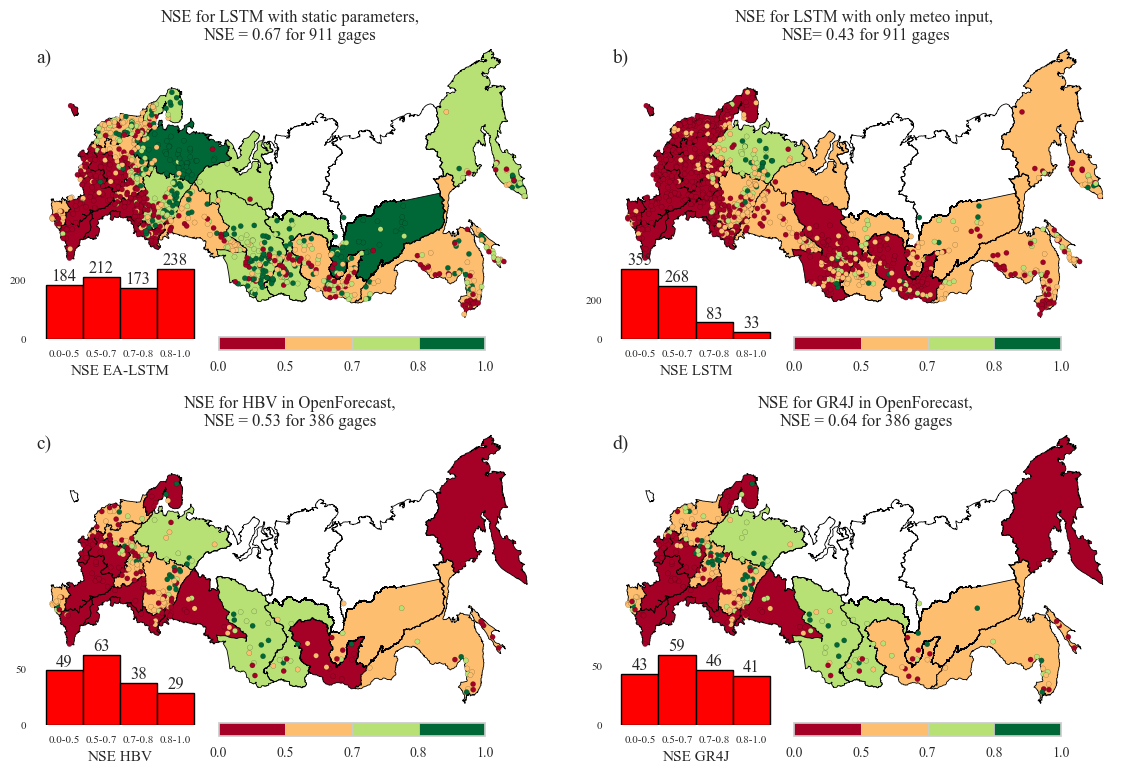

In [69]:
v = len(lstm_no_static.loc[[True if x in lstm_era5l.index
                            else False
                            for x
                            in lstm_no_static.index], :])
differ_models = russia_plots_n(gdf_to_plot=nse_file,
                               basemap_data=basemap_data,
                               figsize=(15, 8),
                               nrows=2,
                               ncols=2,
                               columns_from_gdf=['NSE EA-LSTM', 'NSE LSTM',
                                                 'NSE HBV', 'NSE GR4J'],
                               label_list=['a)', 'b)', 'c)', 'd)'],
                               with_histogram=True,
                               title_text=[
                                   f'NSE for LSTM with static parameters,\nNSE = {nse_lstm_static:.2f} for {len(lstm_era5l)} gages',
                                   f'NSE for LSTM with only meteo input, \nNSE={nse_lstm_meteo: .2f} for {v} gages',
                                   f'NSE for HBV in OpenForecast,\nNSE = {nse_hbv_ayzel:.2f} for {len(hbv_ayzel)} gages',
                                   f'NSE for GR4J in OpenForecast,\nNSE = {nse_gr4j_ayzel:.2f} for {len(gr4j_ayzel)} gages'],
                               ugms=True,
                               ugms_gdf=basin_districts.iloc[
                                   np.r_[4:25, 26:28], :])
differ_models.savefig('./images/IEE_PLOT.pdf',
                      dpi=600, bbox_inches='tight')


### Spatial distribution of NSE quality

In [ ]:
metric_viewer(metric_csv='../test_meteo_input/runs_static/era5L_static_SmallMedium_0205_095021/test/model_epoch024/test_metrics.csv',
                                      metric_col='NSE',
                                      gauges_file=gauges_file)

In [60]:
# tft era5l
lstm_era5l, nse_era5l = metric_viewer(metric_csv='../test_meteo_input/runs_static/era5L_static_SmallMedium_0205_095021/test/model_epoch024/test_metrics.csv',
                                      metric_col='NSE',
                                      gauges_file=gauges_file)
# tft single era5l
tft_era5l, nse_tft = metric_viewer(metric_csv='../forecast/result/tft_by_gauge.csv',
                                   metric_col='NSE',
                                   gauges_file=gauges_file)
# tft single era5l
tft_all_era5l, nse_tft_all = metric_viewer(metric_csv='../forecast/result/tft_predictions_256.csv',
                                           metric_col='NSE',
                                           gauges_file=gauges_file)
# hbv era5l
hbv_era5l, nse_hbv = metric_viewer(metric_csv='../conceptual_runs/final_hbv.csv',
                                   metric_col='NSE',
                                   gauges_file=gauges_file)
# gr4j era5l
gr4j_era5l, nse_gr4j = metric_viewer(metric_csv='../conceptual_runs/final_gr4j.csv',
                                     metric_col='NSE',
                                     gauges_file=gauges_file)
# rfr era5l
rfr_era5l, nse_rfr = metric_viewer(metric_csv='../conceptual_runs/res_rfr.csv',
                                   metric_col='NSE',
                                   gauges_file=gauges_file)
ws_file = ws_file.loc[tft_era5l.index, :]

In [61]:
nse_file = gpd.GeoDataFrame(geometry=lstm_era5['geometry'])
nse_file.index = lstm_era5.index
nse_file[['name_ru', 'name_en']] = lstm_era5[['name_ru', 'name_en']]
nse_file['NSE_era5l'] = lstm_era5['NSE']
nse_file['NSE_TFT'] = tft_era5l['NSE']
nse_file['NSE_TFT_all'] = tft_all_era5l['NSE']
nse_file['NSE_hbv'] = hbv_ayzel['NSE']
nse_file['NSE_gr4j'] = gr4j_ayzel['NSE']
nse_file['NSE_rfr'] = rfr_era5l['NSE']
# get rid of imerg errors
# nse_file = nse_file.replace(np.NaN, 0)
nse_file[['NSE_era5l', 'NSE_TFT', 'NSE_TFT_all',
          'NSE_hbv', 'NSE_gr4j', 'NSE_rfr']] = nse_file[
              ['NSE_era5l', 'NSE_TFT', 'NSE_TFT_all',
               'NSE_hbv', 'NSE_gr4j', 'NSE_rfr']].clip(lower=0)

for i, geom in enumerate(tqdm(basin_districts['geometry'])):

    ugms_part = nse_file.loc[[geom.intersects(gage_point)
                              for gage_point in nse_file['geometry']], :]
    ugms_name = basin_districts.loc[i, 'name1']

    basin_districts.loc[i, ['NSE_era5l', 'NSE_TFT', 'NSE_TFT_all',
                     'NSE_hbv', 'NSE_gr4j', 'NSE_rfr']] = ugms_part[['NSE_era5l', 'NSE_TFT', 'NSE_TFT_all',
                                                                     'NSE_hbv', 'NSE_gr4j', 'NSE_rfr']].median()
basin_districts.loc[[26, 27], ['NSE_era5l', 'NSE_TFT', 'NSE_TFT_all',
                               'NSE_hbv', 'NSE_gr4j', 'NSE_rfr']] = np.NaN

NameError: name 'lstm_era5' is not defined

In [53]:
differ_models = russia_plots_n(gdf_to_plot=nse_file,
               basemap_data=basemap_data,
               figsize=(15, 8),
               nrows=2,
               ncols=3,
               columns_from_gdf=['NSE_era5l', 'NSE_TFT', 'NSE_TFT_all',
                                 'NSE_hbv', 'NSE_gr4j', 'NSE_rfr'],
               label_list=['а)', 'б)', 'в)', 'г)', 'д)', 'е)'],
               with_histogram=True, title_text=[f'NSE для LSTM с осадками ERA5-Land,\nNSE = {nse_era5l:.2f}',
                                                f'NSE для Temporal Fusion Transformer (по постам),\nNSE = {nse_tft:.2f}',
                                                f'NSE для Temporal Fusion Transformer,\nNSE = {nse_tft_all:.2f}',
                                                f'NSE для HBV OpenForecast,\nNSE = {nse_hbv_ayzel:.2f}',
                                                f'NSE для GR4J OpenForecast,\nNSE = {nse_gr4j__ayzel:.2f}',
                                                f'NSE для Random Forest Regressor,\nNSE = {nse_rfr:.2f}'],
               ugms=True, ugms_gdf=basin_districts);
differ_models.savefig('./images/differ_models.png',
                      dpi=1500, bbox_inches='tight')

NameError: name 'nse_file' is not defined

In [17]:
temp_df = pd.read_csv('../forecast/result/tft_predictions_64.csv')
temp_df = temp_df.iloc[:-5]
temp_df.index = tft_era5l.index
temp_df.to_csv('../forecast/result/tft_predictions_64.csv')

### Blind forecast

In [4]:
# lstm blind
lstm_blind, nse_lstm_blind = metric_viewer(metric_csv='../test_meteo_input/runs_blind/era5L_static_CellsBlind_2004_130807/test/model_epoch024/test_metrics.csv',
                                           metric_col='NSE',
                                           gauges_file=gauges_file)
# tft blind
tft_blind, nse_tft_blind = metric_viewer(metric_csv='/workspaces/my_dissertation/forecast/result/blind_forecast_tft_256_20epoch.csv',
                                           metric_col='NSE',
                                           gauges_file=gauges_file)
lstm_blind = lstm_blind[lstm_blind.index.isin(tft_blind.index)]


blind_gdf = gpd.GeoDataFrame(geometry=lstm_blind['geometry'])

blind_gdf['NSE_blind_tft'] = tft_blind['NSE']
blind_gdf['NSE_blind_lstm'] = lstm_blind['NSE']
blind_gdf.to_csv('./tables/partial_gages.csv')

for i, geom in enumerate(tqdm(basin_districts['geometry'])):

    ugms_part = blind_gdf.loc[[geom.intersects(gage_point)
                              for gage_point in blind_gdf['geometry']], :]
    ugms_name = basin_districts.loc[i, 'name1']

    basin_districts.loc[i, ['NSE_blind_tft', 'NSE_blind_lstm']] = ugms_part[['NSE_blind_tft', 'NSE_blind_lstm']].median()
basin_districts.loc[[26, 27], ['NSE_blind_tft', 'NSE_blind_lstm']] = np.NaN

A Jupyter Widget

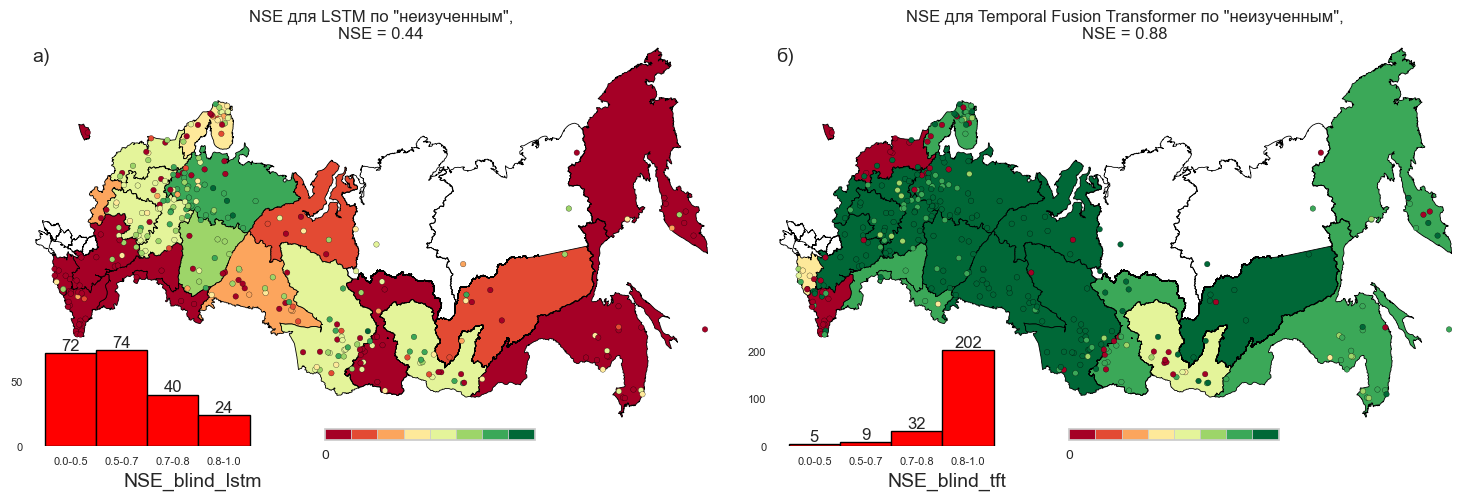

In [5]:
blind_plots = russia_plots_n(
    gdf_to_plot=blind_gdf,
    basemap_data=basemap_data,
    figsize=(15, 8),
    label_list=['а)', 'б)'],
    nrows=1,
    ncols=2,
    columns_from_gdf=['NSE_blind_lstm', 'NSE_blind_tft'],
    with_histogram=True,
    title_text=[f'NSE для LSTM по "неизученным",\nNSE = {nse_lstm_blind:.2f}',
                f'NSE для Temporal Fusion Transformer по "неизученным",\nNSE = {nse_tft_blind:.2f}'],
    ugms=True, ugms_gdf=basin_districts)
# blind_plots.savefig('./images/blind_forecast.png',
#                     dpi=1500, bbox_inches='tight')

### CDF for model runs

In [179]:
# random forest regressor
rfr_run, nse_rfr = metric_viewer(metric_csv='../conceptual_runs/res_rfr.csv',
                                 metric_col='NSE',
                                 gauges_file=gauges_file)
# hbv
hbv_ayzel, nse_hbv_ayzel = metric_viewer(metric_csv='./tables/DELETE_NSE_HBV.csv',
                                   metric_col='NSE',
                                   gauges_file=gauges_file)
# gr4j
gr4j_ayzel, nse_gr4j__ayzel = metric_viewer(metric_csv='./tables/DELETE_NSE.csv',
                                            metric_col='NSE',
                                            gauges_file=gauges_file)
# hbv
my_hbv, nse_hbv_my = metric_viewer(metric_csv='../conceptual_runs/final_hbv.csv',
                                   metric_col='NSE',
                                   gauges_file=gauges_file)
# gr4j
my_gr4j, nse_gr4j_my = metric_viewer(metric_csv='../conceptual_runs/final_gr4j.csv',
                                     metric_col='NSE',
                                     gauges_file=gauges_file)
# tft (by gauge)
tft_run, nse_tft_single = metric_viewer(metric_csv='../forecast/result/tft_by_gauge.csv',
                                        metric_col='NSE',
                                        gauges_file=gauges_file)
# tft (all together)
tft_256, nse_tft_all = metric_viewer(metric_csv='../forecast/result/tft_predictions_256.csv',
                                     metric_col='NSE',
                                     gauges_file=gauges_file)
# lstm + static
lstm_era5l, nse_lstm_static = metric_viewer(metric_csv='../test_meteo_input/runs_static/era5L_static_SmallMedium_0205_095021/test/model_epoch024/test_metrics.csv',
                                            metric_col='NSE',
                                            gauges_file=gauges_file)
# lstm (only meteo)
lstm_no_static, nse_lstm_meteo = metric_viewer(metric_csv='../test_meteo_input/runs_no_static/era5Land_prcp_0604_111347/test/model_epoch030/test_metrics.csv',
                                               metric_col='NSE',
                                               gauges_file=gauges_file)

In [180]:
# tft single era5l
tft_single, nse_tft = metric_viewer(metric_csv='../forecast/result/tft_by_gauge.csv',
                                   metric_col='NSE',
                                   gauges_file=gauges_file)
# tft single era5l
tft_256, nse_tft_all = metric_viewer(metric_csv='../forecast/result/tft_predictions_256.csv',
                                           metric_col='NSE',
                                           gauges_file=gauges_file)
# tft 64
tft_64, nse_tft = metric_viewer(metric_csv='../forecast/result/tft_predictions_64.csv',
                                   metric_col='NSE',
                                   gauges_file=gauges_file)
# tft single era5l
tft_6, nse_tft_all = metric_viewer(metric_csv='../forecast/result/tft_predictions_6.csv',
                                           metric_col='NSE',
                                           gauges_file=gauges_file)

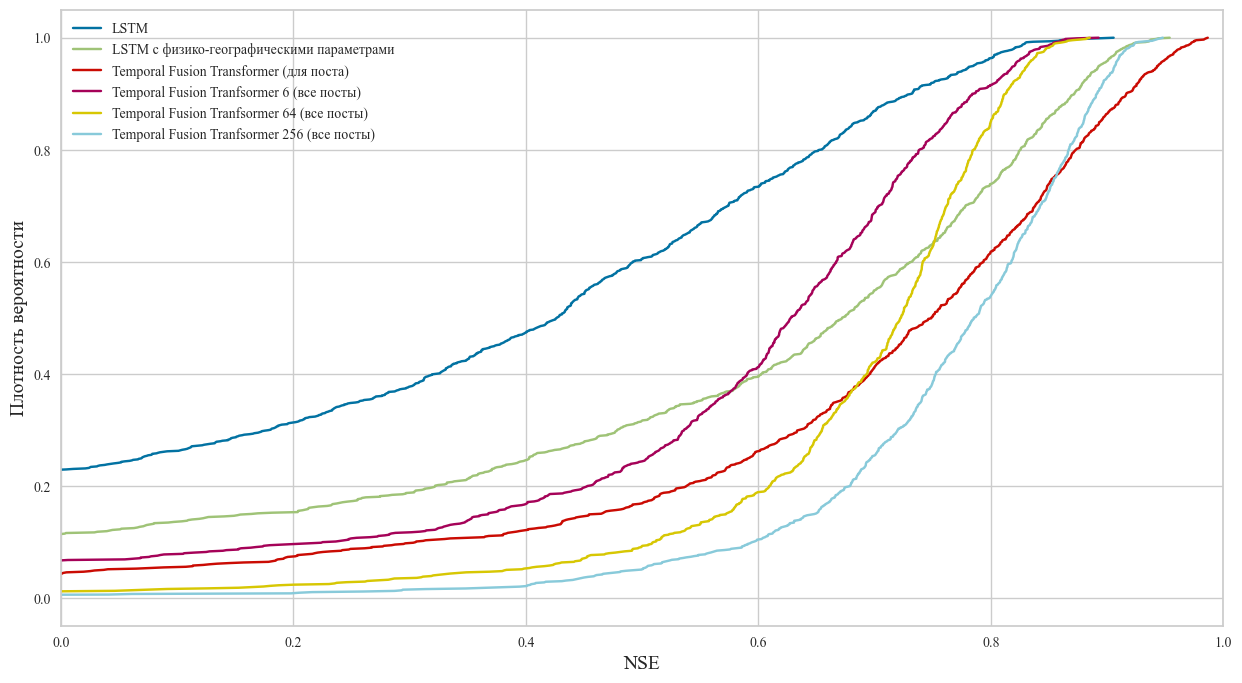

In [181]:
def ecdf(x: np.ndarray):
    """Calculate empirical cummulative density function

    Parameters
    ----------
    x : np.ndarray
        Array containing the data

    Returns
    -------
    x : np.ndarray
        Array containing the sorted metric values
    y : np.ndarray]
        Array containing the sorted cdf values
    """
    xs = np.sort(x)
    ys = np.arange(1, len(xs) + 1) / float(len(xs))
    return xs, ys


fig, ax = plt.subplots(figsize=(15, 8))

for name, fil in {'LSTM': lstm_no_static['NSE'],
                  'LSTM с физико-географическими параметрами': lstm_era5l['NSE'],
                  'Temporal Fusion Transformer (для поста)': tft_run['NSE'],
                  'Temporal Fusion Tranfsormer 6 (все посты)': tft_6['NSE'],
                  'Temporal Fusion Tranfsormer 64 (все посты)': tft_64['NSE'],
                  'Temporal Fusion Tranfsormer 256 (все посты)': tft_256['NSE']}.items():

    bin_, cdf_ = ecdf(fil.to_numpy())
    plt.plot(bin_, cdf_,
             label=f'{name}')
    ax.set_xlim(0, 1)
    ax.grid(True)
    ax.legend(loc='upper left')
    ax.set_xlabel('NSE', fontsize=14)
    ax.set_ylabel('Плотность вероятности', fontsize=14)
fig.savefig('./images/CDF_models_TFT.png',
            dpi=1000, bbox_inches='tight')

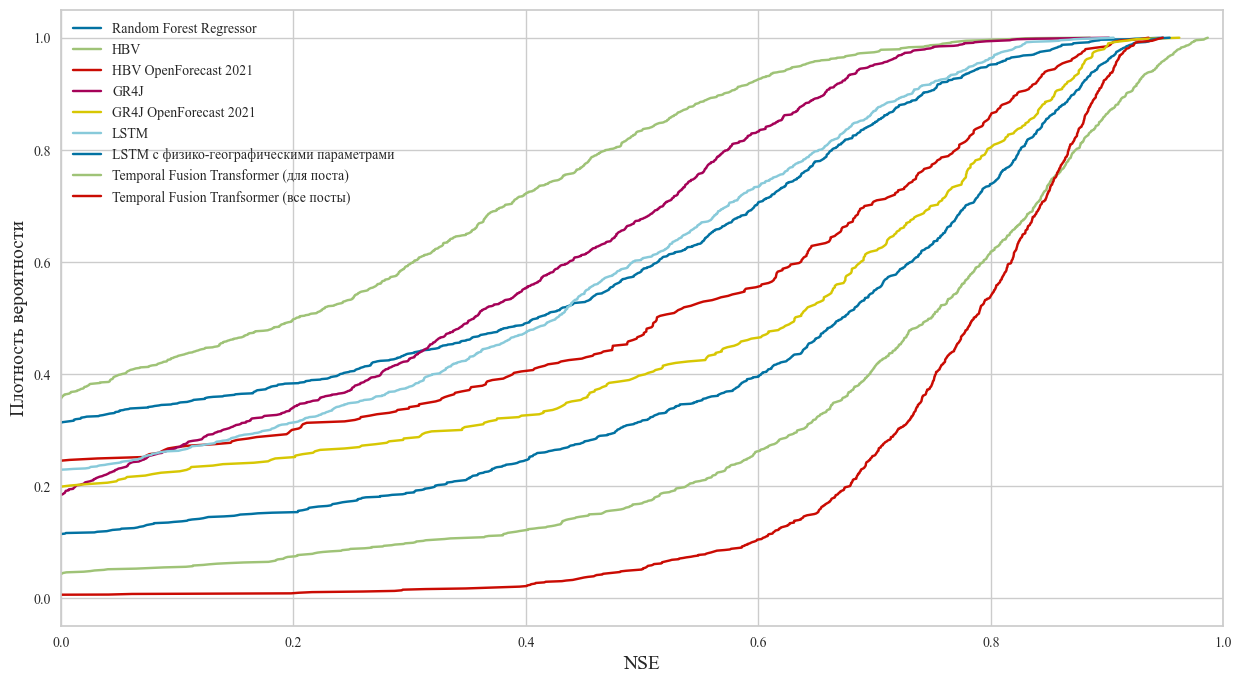

In [183]:
def ecdf(x: np.ndarray):
    """Calculate empirical cummulative density function

    Parameters
    ----------
    x : np.ndarray
        Array containing the data

    Returns
    -------
    x : np.ndarray
        Array containing the sorted metric values
    y : np.ndarray]
        Array containing the sorted cdf values
    """
    xs = np.sort(x)
    ys = np.arange(1, len(xs) + 1) / float(len(xs))
    return xs, ys


fig, ax = plt.subplots(figsize=(15, 8))

for name, fil in {'Random Forest Regressor': rfr_run['NSE'],
                  'HBV': my_hbv['NSE'],
                  'HBV OpenForecast 2021': hbv_ayzel['NSE'],
                  'GR4J': my_gr4j['NSE'],
                  'GR4J OpenForecast 2021': gr4j_ayzel['NSE'],
                  'LSTM': lstm_no_static['NSE'],
                  'LSTM с физико-географическими параметрами': lstm_era5l['NSE'],
                  'Temporal Fusion Transformer (для поста)': tft_run['NSE'],
                  'Temporal Fusion Tranfsormer (все посты)': tft_256['NSE'], }.items():

    bin_, cdf_ = ecdf(fil.to_numpy())
    plt.plot(bin_, cdf_,
             label=f'{name}')
    ax.set_xlim(0, 1)
    ax.grid(True)
    ax.legend(loc='upper left')
    ax.set_xlabel('NSE', fontsize=14)
    ax.set_ylabel('Плотность вероятности', fontsize=14)
fig.savefig('./images/CDF_models.png',
            dpi=1500, bbox_inches='tight')

### Result table for NSE

In [46]:
# random forest regressor
rfr_run, nse_rfr = metric_viewer(metric_csv='../conceptual_runs/res_rfr.csv',
                                 metric_col='NSE',
                                 gauges_file=gauges_file)
# hbv
hbv_ayzel, nse_hbv_ayzel = metric_viewer(metric_csv='./tables/DELETE_NSE_HBV.csv',
                                   metric_col='NSE',
                                   gauges_file=gauges_file)
# gr4j
gr4j_ayzel, nse_gr4j__ayzel = metric_viewer(metric_csv='./tables/DELETE_NSE.csv',
                                     metric_col='NSE',
                                     gauges_file=gauges_file)
# hbv
my_hbv, nse_hbv_my = metric_viewer(metric_csv='../conceptual_runs/final_hbv.csv',
                                   metric_col='NSE',
                                   gauges_file=gauges_file)
# gr4j
my_gr4j, nse_gr4j_my = metric_viewer(metric_csv='../conceptual_runs/final_gr4j.csv',
                                     metric_col='NSE',
                                     gauges_file=gauges_file)
# tft (by gauge)
tft_run, nse_tft_single = metric_viewer(metric_csv='../forecast/result/tft_by_gauge.csv',
                                        metric_col='NSE',
                                        gauges_file=gauges_file)
# tft (all together)
tft_256, nse_tft_all = metric_viewer(metric_csv='../forecast/result/tft_predictions_256.csv',
                                     metric_col='NSE',
                                     gauges_file=gauges_file)
# lstm + static
lstm_era5l, nse_lstm_static = metric_viewer(metric_csv='../test_meteo_input/runs_static/era5L_static_SmallMedium_0205_095021/test/model_epoch024/test_metrics.csv',
                                            metric_col='NSE',
                                            gauges_file=gauges_file)
# lstm (only meteo)
lstm_no_static, nse_lstm_meteo = metric_viewer(metric_csv='../test_meteo_input/runs_no_static/era5Land_prcp_0604_111347/test/model_epoch030/test_metrics.csv',
                                               metric_col='NSE',
                                               gauges_file=gauges_file)

In [58]:
def nse_descriptor(nse_df: pd.DataFrame,
                   model_name: str):
    res_df = pd.DataFrame()
    res_df.loc[0, 'Модель'] = model_name
    
    res_df.loc[0, 'Объектов в выборке'] = f'{len(nse_df):.0f}'
    
    nse_max = nse_df['NSE'].max()
    res_df.loc[0, 'Максимум NSE'] = f'{nse_max:.2f}'
    
    nse_median = nse_df['NSE'].median()
    res_df.loc[0, 'Медианный NSE'] = f'{nse_median:.2f}'
    
    nse_mean = nse_df['NSE'].mean()
    res_df.loc[0, 'Средний NSE'] = f'{nse_mean:.2f}'
    
    nse_min = nse_df['NSE'].min()
    res_df.loc[0, 'Минимум NSE'] = f'{nse_min:.2f}'
    
    nse_less_t_z = (nse_df['NSE'] < 0).sum()
    res_df.loc[0, 'NSE < 0'] = f'{nse_less_t_z:.0f}'
    
    bad_models = (nse_df['NSE'] < 0.5).sum()
    res_df.loc[0, 'Плохие модели, %'] = f'{(bad_models/len(nse_df)):.0%}'
    
    return res_df

test_gr4j = deepcopy(gr4j_era5l)
test_rfr = deepcopy(rfr_era5l)

for g_id in test_gr4j.index:
    if g_id in ws_file.index:
        pass
    else:
        test_gr4j = test_gr4j.drop(g_id)

for g_id in test_rfr.index:
    if g_id in ws_file.index:
        pass
    else:
        test_rfr = test_rfr.drop(g_id)
res_list = list()

hbv_ayzel.replace([np.inf, -np.inf], np.nan, inplace=True)
hbv_ayzel.loc[hbv_ayzel.sort_values(by='NSE').head(10).index, 'NSE'] = 0
gr4j_ayzel.replace([np.inf, -np.inf], np.nan, inplace=True)


for model, res in {
    'LSTM физ. гео ERA5-Land': lstm_era5l,
    'LSTM физ. гео ERA5': lstm_era5,
    'LSTM физ. гео GPCP': lstm_gpcp,
    'LSTM физ. гео IMERG': lstm_imerg,
    'LSTM физ. гео MSWEP': lstm_mswep,
    'LSTM ERA5-Land без физ. гео': lstm_no_static.loc[lstm_era5l.index, :],
    'Temporal Fusion Transformer (для поста)': tft_era5l,
    'Temporal Fusion Transformer (все посты)': tft_all_era5l,
    'HBV, OpenForecast 2021': hbv_ayzel,
    'HBV ERA5-Land': hbv_era5l.loc[hbv_era5l.index.isin(lstm_era5l.index), :],
    'GR4J, OpenForecast 2021': gr4j_ayzel,
    'GR4J ERA5-Land': test_gr4j,
        'RandomForestRegressor ERA5-Land': test_rfr}.items():
    res_list.append(nse_descriptor(nse_df=res, model_name=model))

res_nse = pd.concat(res_list).sort_values(by='Медианный NSE',
                                ascending=False).reset_index(drop=True)
res_nse.to_csv('./tables/model_quality.csv', index=False)
res_nse

Модель Объектов в выборке Максимум NSE   
0   Temporal Fusion Transformer (все посты)                919         0.95  \
1   Temporal Fusion Transformer (для поста)                909         0.99   
2                        LSTM физ. гео ERA5                911         0.95   
3                       LSTM физ. гео MSWEP                911         0.95   
4                   LSTM физ. гео ERA5-Land                911         0.95   
5                   GR4J, OpenForecast 2021                393         0.96   
6                        LSTM физ. гео GPCP                911         0.93   
7                       LSTM физ. гео IMERG                755         0.91   
8                    HBV, OpenForecast 2021                393         0.94   
9               LSTM ERA5-Land без физ. гео                911         0.89   
10          RandomForestRegressor ERA5-Land               1013         0.95   
11                           GR4J ERA5-Land               1013         0.90   
12                            HBV ERA5-Land                909         0.89   

   Медианный NSE Средний NSE Минимум NSE NSE < 0 Плохие модели, %  
0           0.79        0.75       -2.72       5               5%  
1           0.75        0.49     -115.51      39              17%  
2           0.68        0.03     -116.63     105              32%  
3           0.68       -0.11     -113.71     115              32%  
4           0.67       -0.00     -273.15     104              32%  
5           0.64     -190.77   -51507.55      71              38%  
6           0.62       -0.06     -179.63     117              37%  
7           0.59       -0.21      -97.60     139              40%  
8           0.53        0.44       -0.38      29              45%  
9           0.44       -0.06      -28.64     172              58%  
10          0.39      -51.01   -44964.33     323              61%  
11          0.36       -0.06     -211.28     180              68%  
12          0.24        0.03       -8.35     298              83%

### TFT attributs (feature importance, attention, etc.)

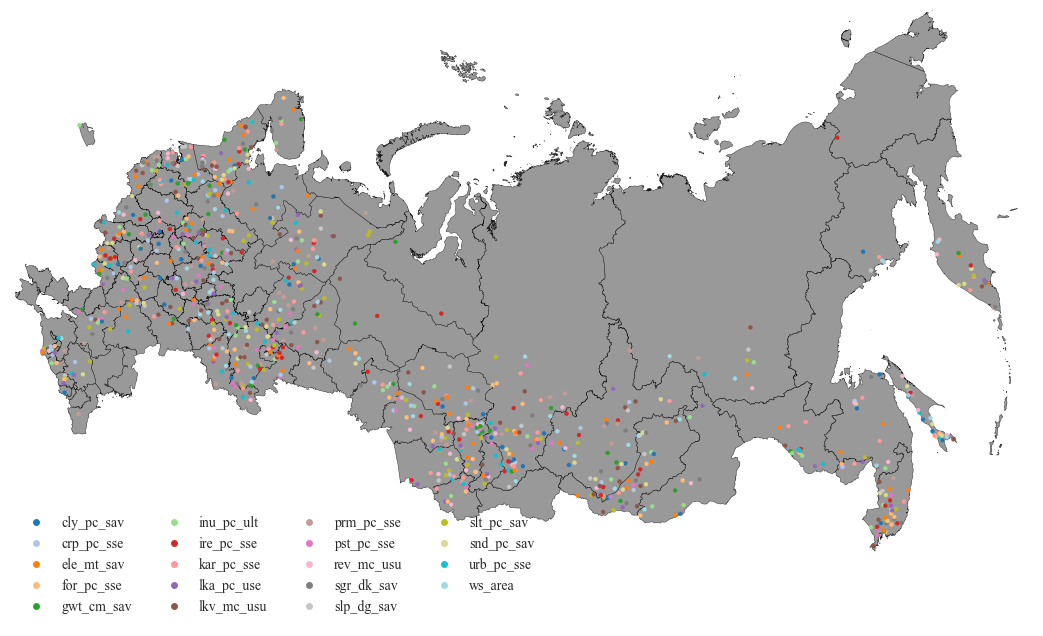

In [75]:
gauges_fig = russia_plots(gdf_to_plot=tft_era5l,
                          basemap_data=basemap_data,
                          distinction_col='static',
                          cmap_name='tab20',
                          figsize=(15, 8),
                          title_text='',
                          just_points=True)
gauges_fig.savefig('./images/static_TFT.png',
                   dpi=1500, bbox_inches='tight')

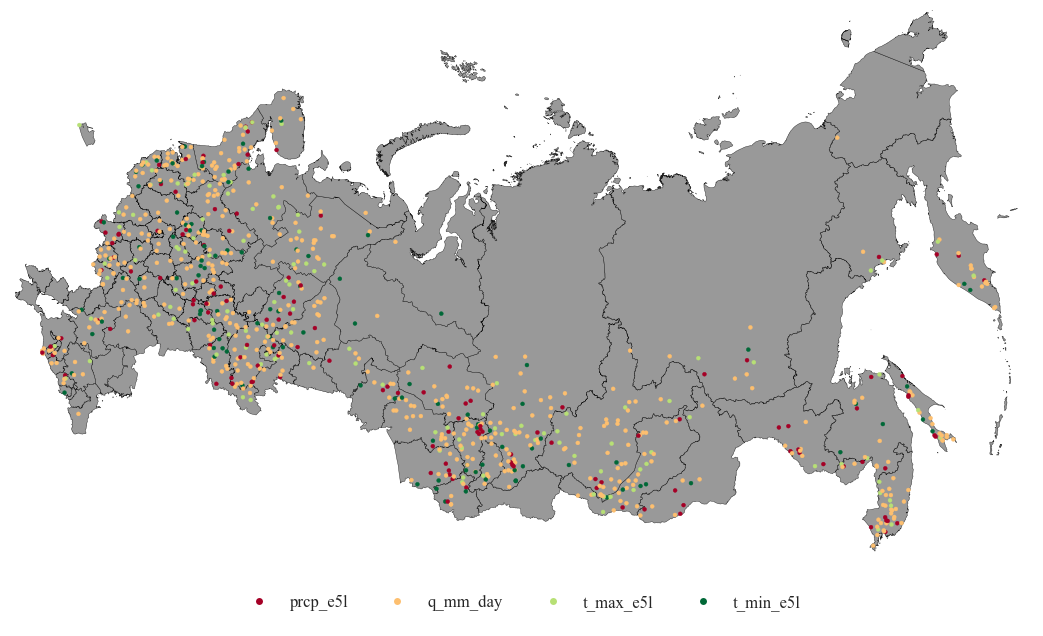

In [73]:
gauges_fig = russia_plots(gdf_to_plot=tft_era5l,
                          basemap_data=basemap_data,
                          distinction_col='encoder',
                          figsize=(15, 8),
                          title_text='',
                          just_points=True)
gauges_fig.savefig('./images/encoder_TFT.png',
                   dpi=1500, bbox_inches='tight')

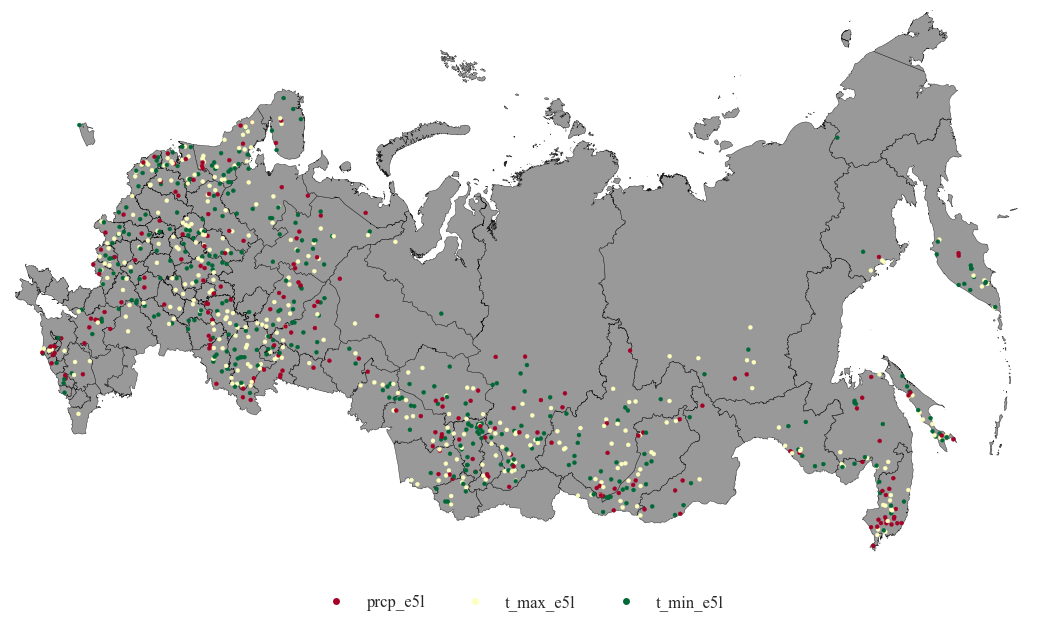

In [74]:
gauges_fig = russia_plots(gdf_to_plot=tft_era5l,
                          basemap_data=basemap_data,
                          distinction_col='decoder',
                          figsize=(15, 8),
                          title_text='',
                          just_points=True)
gauges_fig.savefig('./images/decoder_TFT.png',
                   dpi=1500, bbox_inches='tight')

In [205]:
def day_to_attnt(val: float):
    if val < 7:
        return 'Быстряя'
    elif (val >= 7) & (val <= 30):
        return 'Средняя'
    elif (val >= 30) & (val <= 90):
        return 'Средне-длинная'
    else:
        return 'Длинная'


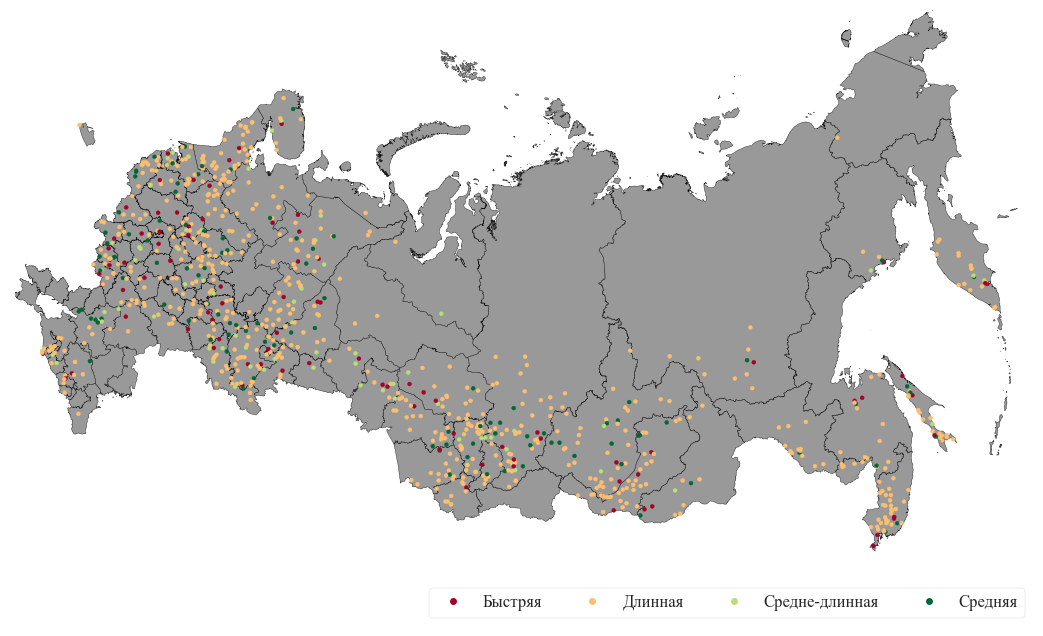

In [207]:
gauges_fig = russia_plots(gdf_to_plot=tft_era5l,
                          basemap_data=basemap_data,
                          distinction_col='attention',
                          figsize=(15, 8),
                          title_text='',
                          just_points=True)
gauges_fig.savefig('./images/attention_TFT.png',
                   dpi=1500, bbox_inches='tight')

### GMC forecast quality

In [4]:
def find_gmc(predictions: np.ndarray, observations: np.ndarray,
             days_shift: int, eq_param: int, with_p=False) -> np.ndarray:
    """[summary]

    Args:
        predictions (np.array): [description]
        observations (np.array): [description]
        days_shift (int): [description]

    Returns:
        np.array: [description]
    """

    predictions_error = np.array(observations - predictions)
    delta_1 = np.array(observations[:-days_shift]-observations[days_shift:])
    sigma = np.std(delta_1-np.mean(delta_1), ddof=1)
    gmc_criteria = np.abs(0.674*sigma)
    S = np.sqrt(np.sum([i**2 for i in predictions_error]) /
                (len(predictions_error)-eq_param))

    s_sigma = S/sigma

    descision = ['Прогноз оправдывается' if np.abs(error) <= gmc_criteria
                 else 'Прогноз не оправдывается'
                 for error in predictions_error]

    values, counts = np.unique(descision, return_counts=True)
    try:
        first_value, second_value = counts
        first_key, second_key = values
        print(f'\nКачество прогноза заблаговременностью {days_shift} день')
        print(
            f'''Результаты оценки качества прогноза:\n{first_key} -- {first_value} раз(а),
    {second_key} -- {second_value} раз(а)''')
        print(f'Критерий точности ГМЦ +/- {gmc_criteria:.3f}')
        accuracy = second_value/(first_value + second_value)
        print(f'Оправдываемость прогнозов по методике ГМЦ {accuracy:.2%}')
        print(
            f'S/sigma_delta {s_sigma:.2f} -- длина ряда {len(predictions_error)}')
    except:
        print(f'\nКачество прогноза заблаговременностью {days_shift} день')
        print(
            f'''Результаты оценки качества прогноза:\n{values[0]} -- {counts[0]} раз(а)''')
        print(f'Критерий точности ГМЦ +/- {gmc_criteria:.3f}')
        accuracy = 0
        print(f'Оправдываемость прогнозов по методике ГМЦ {accuracy:.2%}')
        print(
            f'S/sigma_delta {s_sigma:.2f} -- длина ряда {len(predictions_error)}')
    if with_p:
        return np.array([np.round(S*100, decimals=1),
                         np.round(sigma*100, decimals=1),
                         np.round(s_sigma, decimals=2),
                         f'{accuracy:.1%}'])

    else:
        return np.array([np.round(gmc_criteria, decimals=3),
                         np.round(s_sigma, decimals=2),
                         np.round(accuracy*100, decimals=2)])

In [41]:
for gauge_id in tft_all_era5l.index:
    test_df = pd.read_csv(f'./results/tft_256/{gauge_id}.csv',
                      index_col='date')
    test_df.index = pd.to_datetime(test_df.index)
    tft_all_era5l.loc[gauge_id, ['S/σ', 'ГМЦ']] = find_gmc(
        predictions=test_df['q_mm_day_pred'].to_numpy(),
        observations=test_df['q_mm_day'].to_numpy(),
        days_shift=7, eq_param=24, with_p=False)[1:3]
for i, geom in enumerate(tqdm(basin_districts['geometry'])):

    ugms_part = tft_all_era5l.loc[[geom.intersects(gage_point)
                              for gage_point in tft_all_era5l['geometry']], :]
    ugms_name = basin_districts.loc[i, 'name1']

    basin_districts.loc[i, ['ГМЦ']] = ugms_part[['ГМЦ']].mean()
    basin_districts.loc[i, ['S/σ']] = ugms_part[['S/σ']].min()
    
basin_districts.loc[[26, 27], ['ГМЦ', 'S/σ']] = np.NaN


Качество прогноза заблаговременностью 7 день
Результаты оценки качества прогноза:
Прогноз не оправдывается -- 78 раз(а),
    Прогноз оправдывается -- 647 раз(а)
Критерий точности ГМЦ +/- 0.334
Оправдываемость прогнозов по методике ГМЦ 89.24%
S/sigma_delta 0.73 -- длина ряда 725

Качество прогноза заблаговременностью 7 день
Результаты оценки качества прогноза:
Прогноз не оправдывается -- 149 раз(а),
    Прогноз оправдывается -- 576 раз(а)
Критерий точности ГМЦ +/- 0.552
Оправдываемость прогнозов по методике ГМЦ 79.45%
S/sigma_delta 0.73 -- длина ряда 725

Качество прогноза заблаговременностью 7 день
Результаты оценки качества прогноза:
Прогноз не оправдывается -- 64 раз(а),
    Прогноз оправдывается -- 661 раз(а)
Критерий точности ГМЦ +/- 0.422
Оправдываемость прогнозов по методике ГМЦ 91.17%
S/sigma_delta 0.67 -- длина ряда 725

Качество прогноза заблаговременностью 7 день
Результаты оценки качества прогноза:
Прогноз не оправдывается -- 196 раз(а),
    Прогноз оправдывается -- 529 раз

A Jupyter Widget

In [10]:
def s_sigma_to_qual(val: float):
    if val <= 0.5:
        return 'Хорошая'
    elif (0.5 < val) & (val <= 0.8):
        return 'Удовлетворительная'
    else:
        return 'Плохая'
tft_all_era5l['S/σ'] = tft_all_era5l['S/σ'].apply(lambda x: s_sigma_to_qual(x))

In [11]:
s_sigma_df = pd.DataFrame()
for i, (qual, idx) in enumerate(tft_all_era5l.groupby('S/σ').groups.items()):
    s_sigma_df.loc[0, f'{qual}'] = len(idx)
s_sigma_df
    

Плохая  Удовлетворительная  Хорошая
0   143.0               720.0     56.0

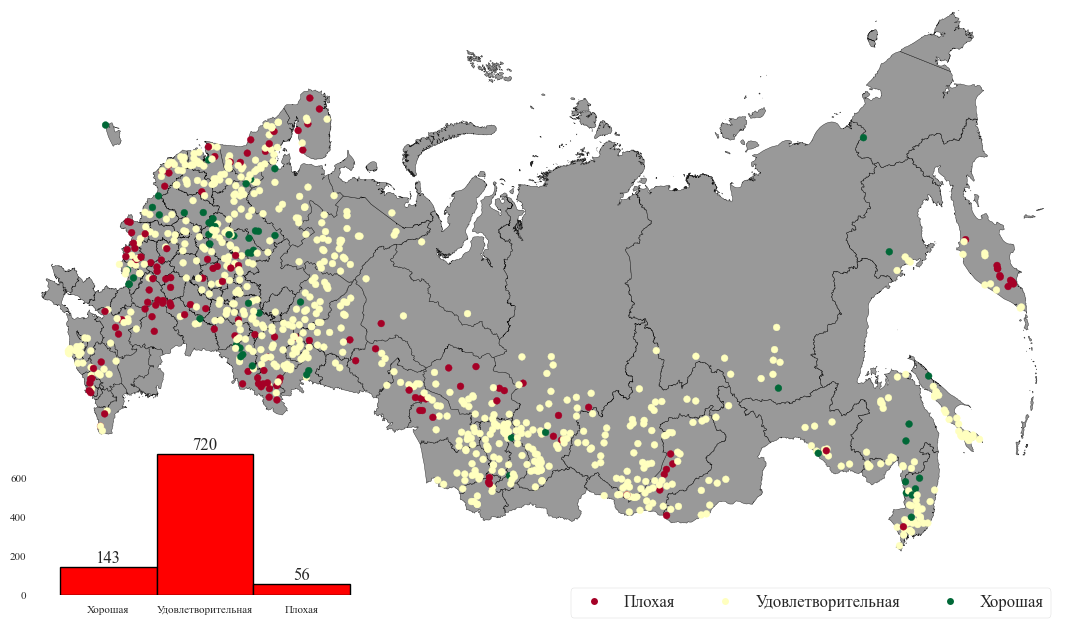

In [29]:
gauges_fig = russia_plots(gdf_to_plot=tft_all_era5l,
                          basemap_data=basemap_data,
                          distinction_col='S/σ',
                          just_points=True,
                          specific_xlabel=['Хорошая', 'Удовлетворительная',
                                           'Плохая'],
                          figsize=(15, 8),
                          title_text='',
                          with_histogram=True,)
gauges_fig.savefig('./images/s_sigma_tft.png',
                   dpi=1500, bbox_inches='tight')

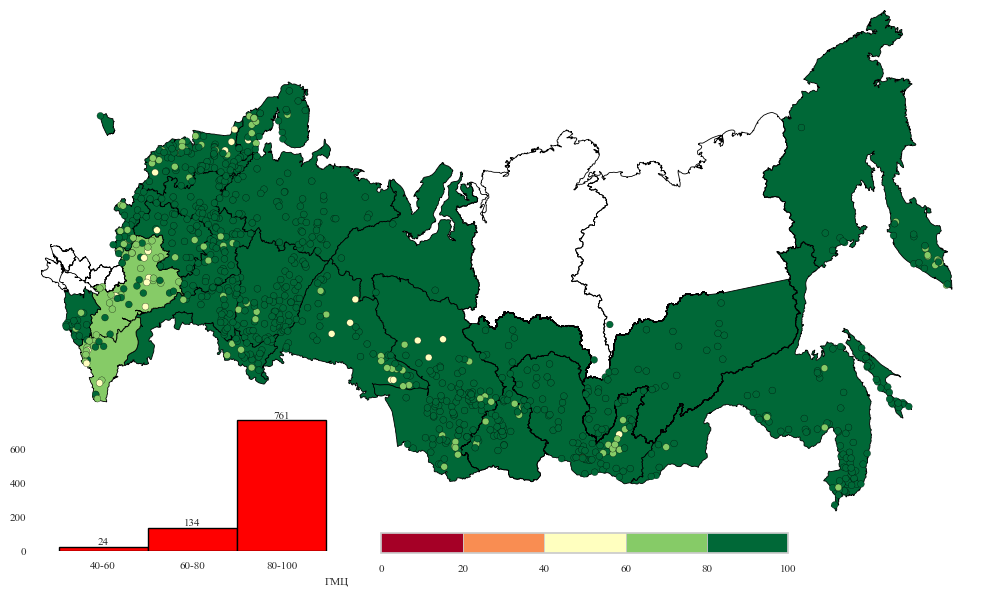

In [28]:
gauges_fig = russia_plots(gdf_to_plot=tft_all_era5l,
                          basemap_data=basemap_data,
                          distinction_col='',
                          list_of_limits=[0, 40, 60, 80, 100],
                          cmap_lims=(0, 100),
                          figsize=(15, 8),
                          title_text='',
                          with_histogram=True,
                          ugms=True, ugms_gdf=basin_districts, metric_col='ГМЦ')
gauges_fig.savefig('./images/GMC_tft.png',
                   dpi=1500, bbox_inches='tight')

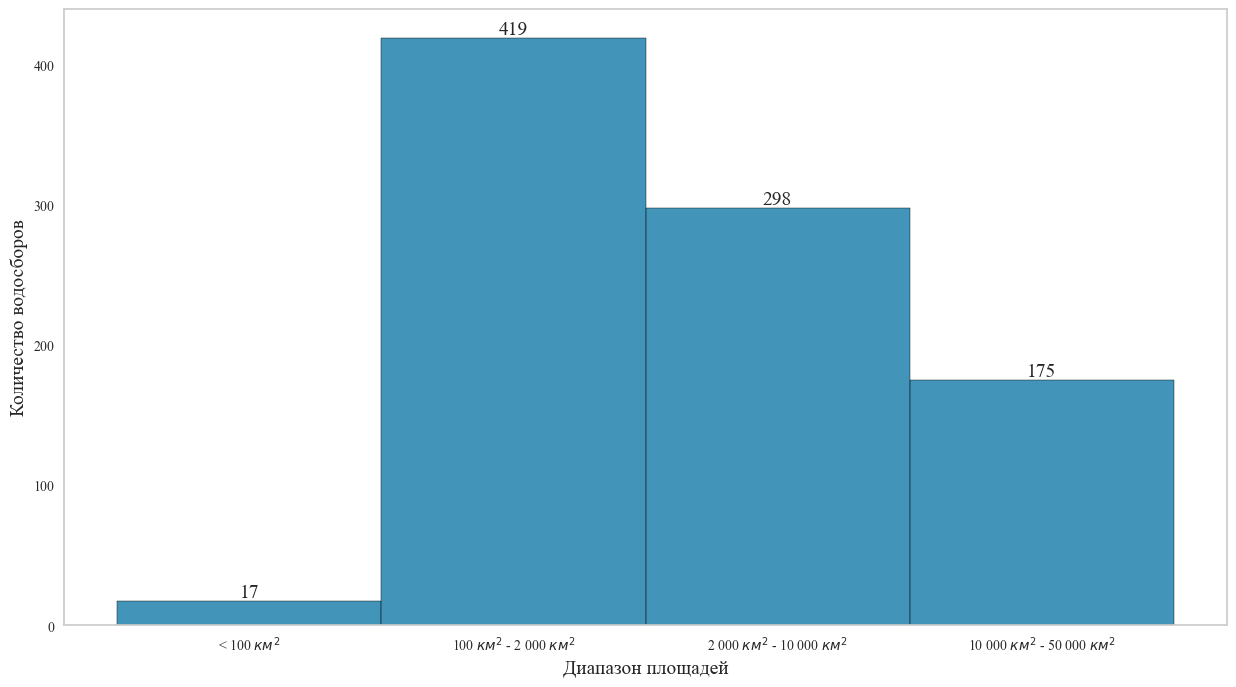

In [15]:
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(15, 8))

area_hist = sns.histplot(data=ws_file,
                         x='size')
#  set the ticks first
area_hist.set_yticks(np.arange(0, 500, 100));
# set the labels
area_hist.set_yticklabels(np.arange(0, 500, 100));
area_hist.set_xlabel('Диапазон площадей', fontsize=14)
area_hist.set_ylabel('Количество водосборов', fontsize=14)
area_hist.bar_label(area_hist.containers[1], fmt='%.0f', fontsize=14)
area_hist.grid(False)

# area_hist.set_title(f"""Распределение водосборов по площадям""", fontsize=12);
plt.savefig('./images/area_distribution.png',
            dpi=1000, bbox_inches='tight')

In [30]:
stat_nse_qual = pd.DataFrame()

for i, (stat_attr, indx) in enumerate(
    tft_era5l.groupby('static').groups.items()):
    
    stat_nse_qual.loc[i, 'Физико-географический атрибут'] = stat_attr
    stat_nse_qual.loc[i, 'NSE'] = tft_era5l.loc[indx, 'NSE'].mean()
    

In [38]:
stat_nse_qual.set_index('Физико-географический атрибут').T.to_csv('./tables/fiz_geo_nse.csv')
stat_nse_qual.set_index('Физико-географический атрибут').T

Физико-географический атрибут  cly_pc_sav  crp_pc_sse  ele_mt_sav  for_pc_sse   
NSE                              0.547012    0.380154    0.636396    0.685875  \

Физико-географический атрибут  gwt_cm_sav  inu_pc_ult  ire_pc_sse  kar_pc_sse   
NSE                              0.624563    0.654382    0.556711    0.708467  \

Физико-географический атрибут  lka_pc_use  lkv_mc_usu  prm_pc_sse  pst_pc_sse   
NSE                              0.686307    0.572746    0.635245    0.610373  \

Физико-географический атрибут  rev_mc_usu  sgr_dk_sav  slp_dg_sav  slt_pc_sav   
NSE                                 0.679    0.710811    0.695742    0.701114  \

Физико-географический атрибут  snd_pc_sav  urb_pc_sse   ws_area  
NSE                              0.433128   -2.120386  0.510478

In [77]:
ws_file['NSE'] = tft_all_era5l['NSE']
ws_file['ГМЦ'] = tft_all_era5l['ГМЦ']
ws_file['S/σ'] = tft_all_era5l['S/σ']
ws_file['S/σ'] = ws_file['S/σ'].astype(float)
ws_file.loc[ws_file['S/σ'] > 1, 'S/σ'] = 1.0

In [52]:
ws_file['S/σ'] = ws_file['S/σ'].apply(lambda x: round(x, 1))

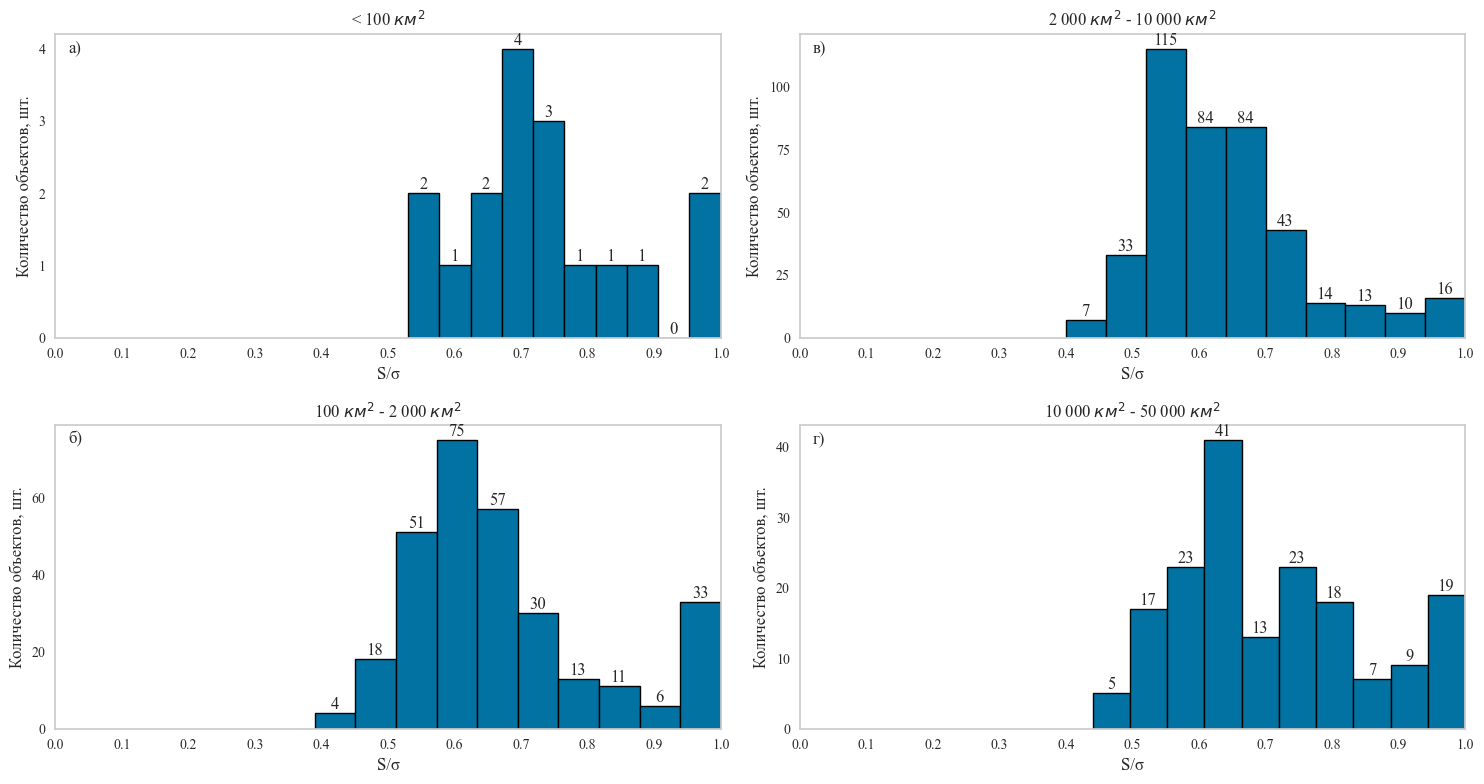

In [78]:
my_hist = ws_file.hist(column='S/σ',
                       by='size',
                       figsize=(15, 8),
                       edgecolor='black', linewidth=1)

xlbl = [str(col).replace(', ', '-')
        for col in np.unique(ws_file['size'])]
label_list = ['а)', 'в)', 'б)', 'г)'][::-1]

for i, ax in enumerate(my_hist.flatten()[::-1]):
    
    ax.set_title(xlbl[i])
    ax.text(.02, .98, label_list[i], ha='left', va='top',
        transform=ax.transAxes, fontsize=12)
    ax.set_xlabel('S/σ', fontsize=12)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
    
    ax.set_ylabel('Количество объектов, шт.', fontsize=12)
    ax.locator_params(axis='y', nbins=5)
    ax.set_xlim((0, 1.0))
    
    ax.locator_params(axis='x', nbins=10)
    ax.grid(False)
    ax.bar_label(ax.containers[0], fmt='%.0f'.lstrip('0'))
    ax.tick_params(axis='x', labelrotation=0);
plt.tight_layout()
plt.savefig('./images/sigma_distribution.png',
            dpi=1500, bbox_inches='tight')


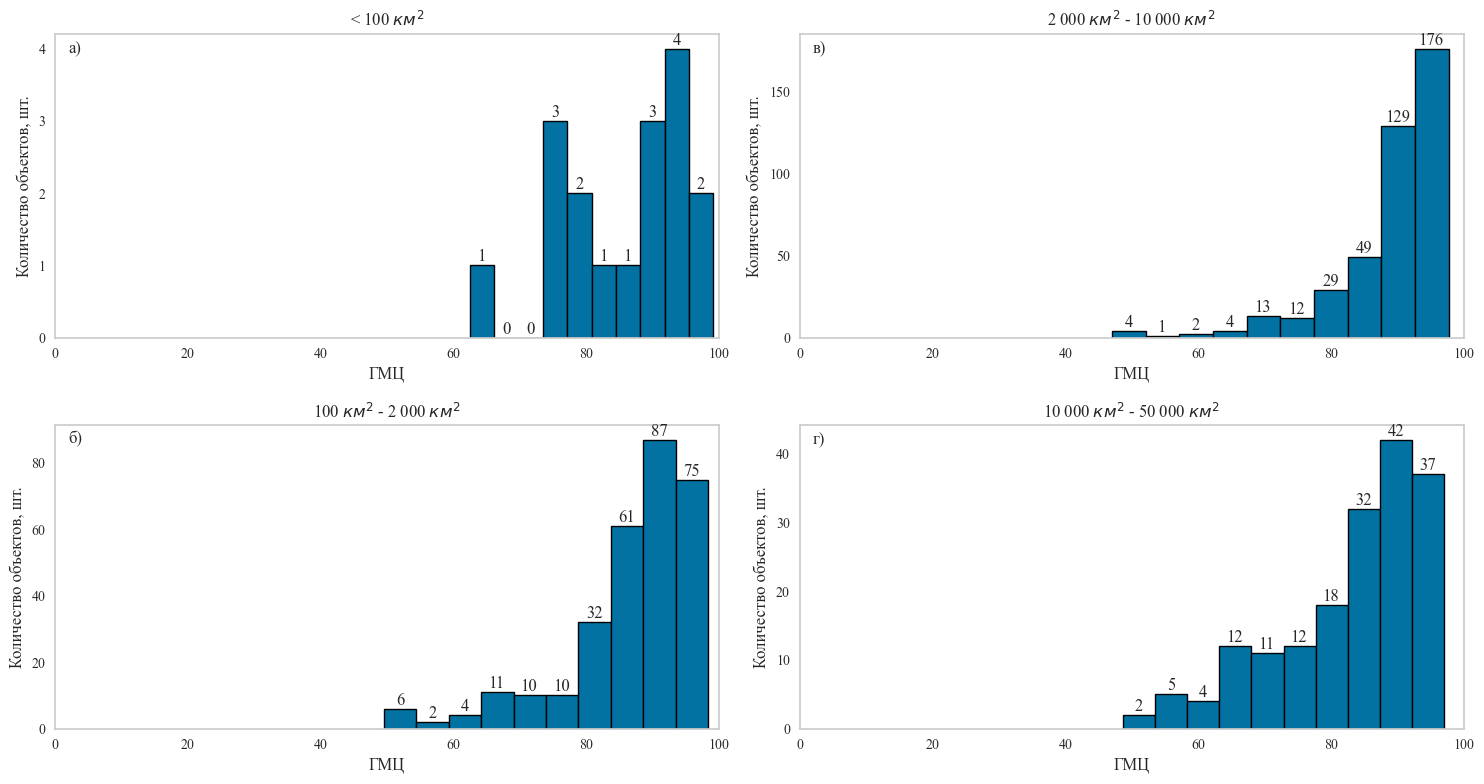

In [19]:
my_hist = ws_file.hist(column='ГМЦ',
                       by='size',
                       figsize=(15, 8),
                       edgecolor='black', linewidth=1)

xlbl = [str(col).replace(', ', '-')
        for col in np.unique(ws_file['size'])]
label_list = ['а)', 'в)', 'б)', 'г)'][::-1]

for i, ax in enumerate(my_hist.flatten()[::-1]):
    ax.set_title(xlbl[i])
    ax.text(.02, .98, label_list[i], ha='left', va='top',
        transform=ax.transAxes, fontsize=12)
    ax.set_xlabel("ГМЦ", fontsize=12)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
    ax.set_ylabel('Количество объектов, шт.', fontsize=12)
    ax.locator_params(axis='y', nbins=5)
    ax.set_xlim((0, 100))
    ax.locator_params(axis='x', nbins=5)
    ax.grid(False)
    ax.bar_label(ax.containers[0], fmt='%.0f'.lstrip('0'))
    ax.tick_params(axis='x', labelrotation=0);
plt.tight_layout()
plt.savefig('./images/gmc_distribution.png',
            dpi=1500, bbox_inches='tight')


### q5, q95, mean, baseflow 

In [20]:
from scripts.hydro_metrics import hydro_job
from scripts.processing import split_by_hydro_year, split_by_year

In [21]:
gage_comp = dict()
final_list = list()
for g_id in tqdm(ws_file.index):
    gage_comp[g_id] = dict()
    test_df = pd.read_csv(f'./results/tft_256/{g_id}.csv',
                      index_col='date')
    test_df.index = pd.to_datetime(test_df.index)
    for col in test_df.columns:
        year_res = list()
        hydro_years = split_by_hydro_year(test_df[col])
        calendar_years = split_by_year(test_df[col])

        for year in hydro_years.keys():
            year_res.append(pd.DataFrame(hydro_job(hydro_year=hydro_years[year],
                                                   calendar_year=calendar_years[year]),
                                         index=[0]))
        year_res = pd.concat(year_res)
        gage_comp[g_id][col] = year_res
    res_df = (gage_comp[g_id]['q_mm_day'] - gage_comp[g_id]
              ['q_mm_day_pred'])/gage_comp[g_id]['q_mm_day'] * 100
    res_df = res_df.mean().to_frame().T
    res_df['gauge_id'] = g_id
    final_list.append(res_df)
tft_stats = pd.concat(final_list).set_index('gauge_id', drop=True)

A Jupyter Widget

In [22]:
tft_all_era5l[['mean', 'bfi', 'q5', 'q95']] = tft_stats

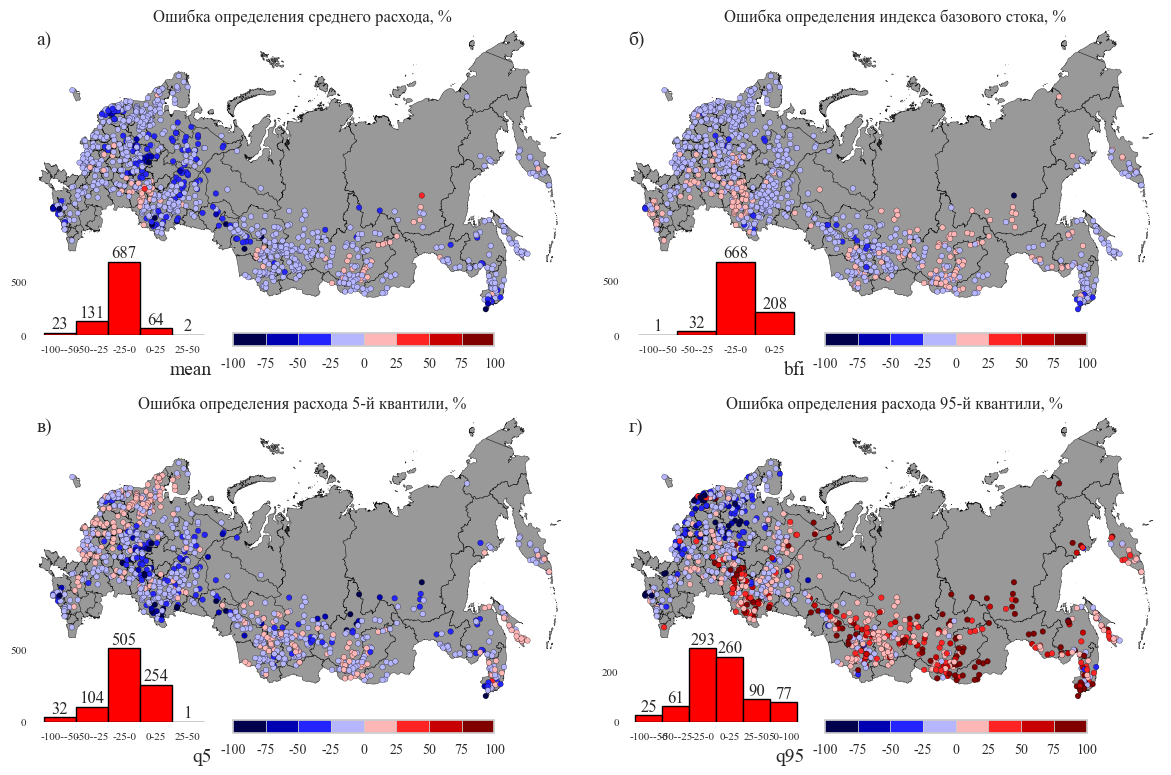

In [23]:
russia_plots_n(gdf_to_plot=tft_all_era5l,
               basemap_data=basemap_data,
               cmap_name='seismic',
               figsize=(15, 8),
               list_of_limits=[-100, -50, -25, 0, 25, 50, 100],
               cmap_lims=(-100, 100),
               label_list= ['а)', 'б)', 'в)', 'г)'],
               nrows=2,
               ncols=2,
               columns_from_gdf=['mean', 'bfi', 'q5', 'q95'],
               with_histogram=True, title_text=[f'Ошибка определения среднего расхода, %',
                                                f'Ошибка определения индекса базового стока, %',
                                                f'Ошибка определения расхода 5-й квантили, %',
                                                f'Ошибка определения расхода 95-й квантили, %']);
plt.savefig('./images/q5q95bfimean.png',
            dpi=1500, bbox_inches='tight')

In [5]:
from datetime import datetime


def get_season(value: datetime) -> int:
    """[summary]

    Args:
        value (datetime): [description]

    Returns:
        int: [description]
    """
    month = value.month
    if month in range(1, 3) or month == 12:
        season = 1
    elif month in range(3, 6):
        season = 2
    elif month in range(5, 9):
        season = 3
    else:
        season = 4
    return season

def precip_limit(value: float) -> int:
    
    if value == 0:
        return 1
    if 0 < value < 10:
        return 2
    if 10 < value < 25:
        return 3
    else:
        return 4

In [24]:
def nse(predictions, targets):
    return 1-(
        np.nansum((targets-predictions)**2)/np.nansum(
            (targets-np.nanmean(targets))**2))

seasons = ['Зима', 'Весна', 'Лето', 'Осень']
season_gauges = dict()

for g_id in tqdm(ws_file.index):
    season_gauges[g_id] = dict()
    test_df = pd.read_csv(f'./results/tft_256/{g_id}.csv',
                        index_col='date')
    test_df['season'] = list(map(get_season,
                                 pd.to_datetime(test_df.index)))
    orig_nse = nse(test_df['q_mm_day_pred'], test_df['q_mm_day'])
    
    for i, (key, dff) in enumerate(test_df.groupby('season')):
        res_file = pd.DataFrame()
        
        pred = dff['q_mm_day_pred'].values
        obs = dff['q_mm_day'].values
        
        res_file.loc[i, 'gauge_id'] = g_id
        res_file.loc[i, 'NSE'] = f"{orig_nse:.2f}"
        res_file.loc[i, 'NSE сезон'] = f'{nse(pred, obs):.2f}'
        res_file.loc[i, 'Ошибка, %'] = f'{np.median((obs-pred)/obs):.2f}'
        res_file = res_file.set_index('gauge_id', drop=True)
        season_gauges[g_id][seasons[i]] = res_file
        
seasonal_errors = dict()
for i, season in enumerate(seasons):
    seasonal_errors[season] = list()
    
    for g_id in ws_file.index:
        seasonal_errors[season].append(season_gauges[g_id][season])
    seasonal_errors[season] = pd.concat(seasonal_errors[season],
                                        axis=0)

A Jupyter Widget

NameError: name 'get_season' is not defined

In [ ]:
tft_all_era5l[['NSE зима', 'Ошибка зима, %']] = seasonal_errors['Зима'][['NSE сезон', 'Ошибка, %']]
tft_all_era5l[['NSE весна', 'Ошибка весна, %']] = seasonal_errors['Весна'][['NSE сезон', 'Ошибка, %']]
tft_all_era5l[['NSE лето', 'Ошибка лето, %']] = seasonal_errors['Лето'][['NSE сезон', 'Ошибка, %']]
tft_all_era5l[['NSE осень', 'Ошибка осень, %']] = seasonal_errors['Осень'][['NSE сезон', 'Ошибка, %']]
tft_all_era5l[['NSE зима', 'NSE весна', 'NSE лето', 'NSE осень']] = tft_all_era5l[['NSE зима', 'NSE весна', 'NSE лето', 'NSE осень']].astype(float)
nse_winter = tft_all_era5l['NSE зима'].median()
nse_spring = tft_all_era5l['NSE весна'].median()
nse_summer = tft_all_era5l['NSE лето'].median()
nse_autumn = tft_all_era5l['NSE осень'].median()

delta_winter = f"{tft_all_era5l['Ошибка зима, %'].median():.1%}"
delta_spring = f"{tft_all_era5l['Ошибка весна, %'].median():.1%}"
delta_summer = f"{tft_all_era5l['Ошибка лето, %'].median():.1%}"
delta_autumn = f"{tft_all_era5l['Ошибка осень, %'].median():.1%}"

In [ ]:
tft_all_era5l[['Ошибка зима, %', 'Ошибка весна, %',
           'Ошибка лето, %', 'Ошибка осень, %']] = tft_all_era5l[['Ошибка зима, %', 'Ошибка весна, %',
                                                              'Ошибка лето, %', 'Ошибка осень, %']].astype(float)
tft_all_era5l[['Ошибка зима, %', 'Ошибка весна, %',
           'Ошибка лето, %', 'Ошибка осень, %']] *= 1e2

In [ ]:
# give ugms some shine
for i, geom in enumerate(tqdm(basin_districts['geometry'])):

    ugms_part = tft_all_era5l.loc[[geom.intersects(gage_point)
                              for gage_point in tft_all_era5l['geometry']], :]
    ugms_name = basin_districts.loc[i, 'name1']

    basin_districts.loc[i, ['NSE зима', 'NSE весна',
                            'NSE лето', 'NSE осень']] = ugms_part[['NSE зима', 'NSE весна',
                                                                   'NSE лето', 'NSE осень']].median()
basin_districts.loc[[26, 27], ['NSE зима', 'NSE весна',
                               'NSE лето', 'NSE осень']] = np.NaN

A Jupyter Widget

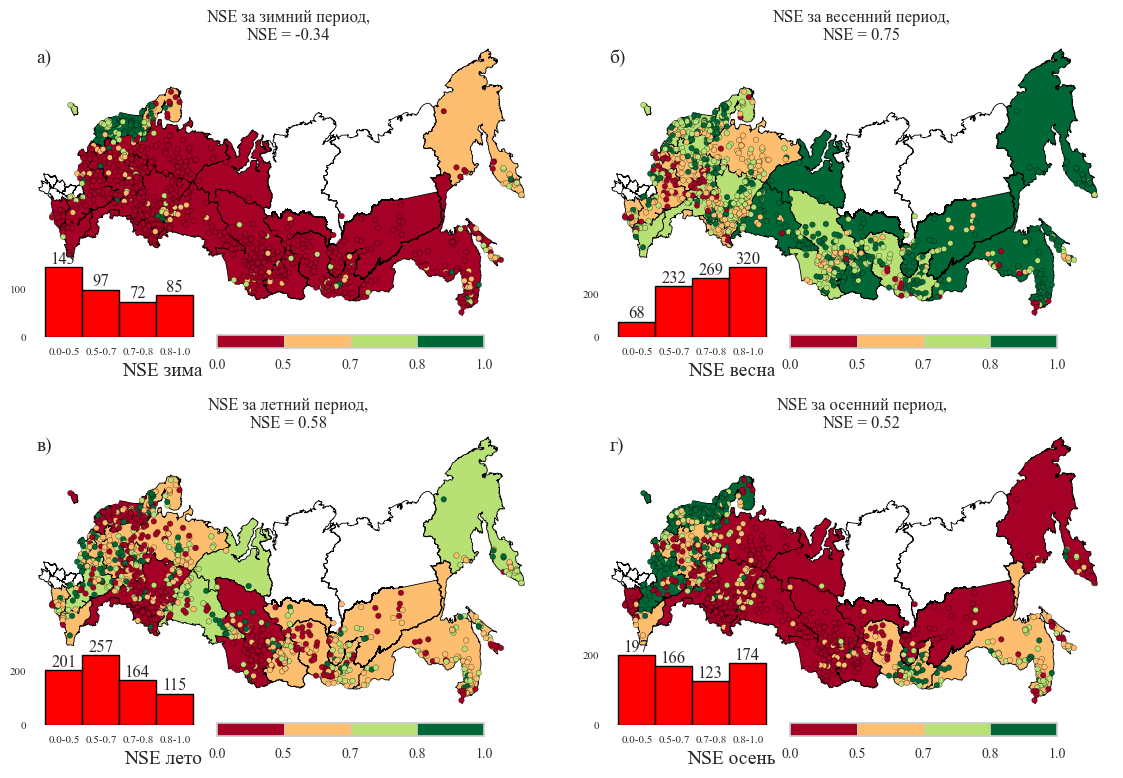

In [ ]:
differ_models = russia_plots_n(gdf_to_plot=tft_era5l,
                               basemap_data=basemap_data,
                               figsize=(15, 8),
                               nrows=2,
                               ncols=2,
                               columns_from_gdf=['NSE зима', 'NSE весна',
                                                 'NSE лето', 'NSE осень'],
                               label_list=['а)', 'б)', 'в)', 'г)'],
                               with_histogram=True,
                               title_text=[f'NSE за зимний период,\nNSE = {nse_winter:.2f}',
                                           f'NSE за весенний период,\nNSE = {nse_spring:.2f}',
                                           f'NSE за летний период,\nNSE = {nse_summer:.2f}',
                                           f'NSE за осенний период,\nNSE = {nse_autumn:.2f}'],
                               ugms=True, ugms_gdf=basin_districts)
differ_models.savefig('./images/nse_seasons.png',
                      dpi=1500, bbox_inches='tight')

In [81]:
# give ugms some shine
for i, geom in enumerate(tqdm(basin_districts['geometry'])):

    ugms_part = tft_era5l.loc[[geom.intersects(gage_point)
                              for gage_point in tft_era5l['geometry']], :]
    ugms_name = basin_districts.loc[i, 'name1']

    basin_districts.loc[i, ['Ошибка зима, %', 'Ошибка весна, %',
                            'Ошибка лето, %', 'Ошибка осень, %']] = ugms_part[['Ошибка зима, %', 'Ошибка весна, %',
                                                                               'Ошибка лето, %', 'Ошибка осень, %']].median()
basin_districts.loc[[26, 27], ['Ошибка зима, %', 'Ошибка весна, %',
                                                 'Ошибка лето, %', 'Ошибка осень, %']] = np.NaN

A Jupyter Widget

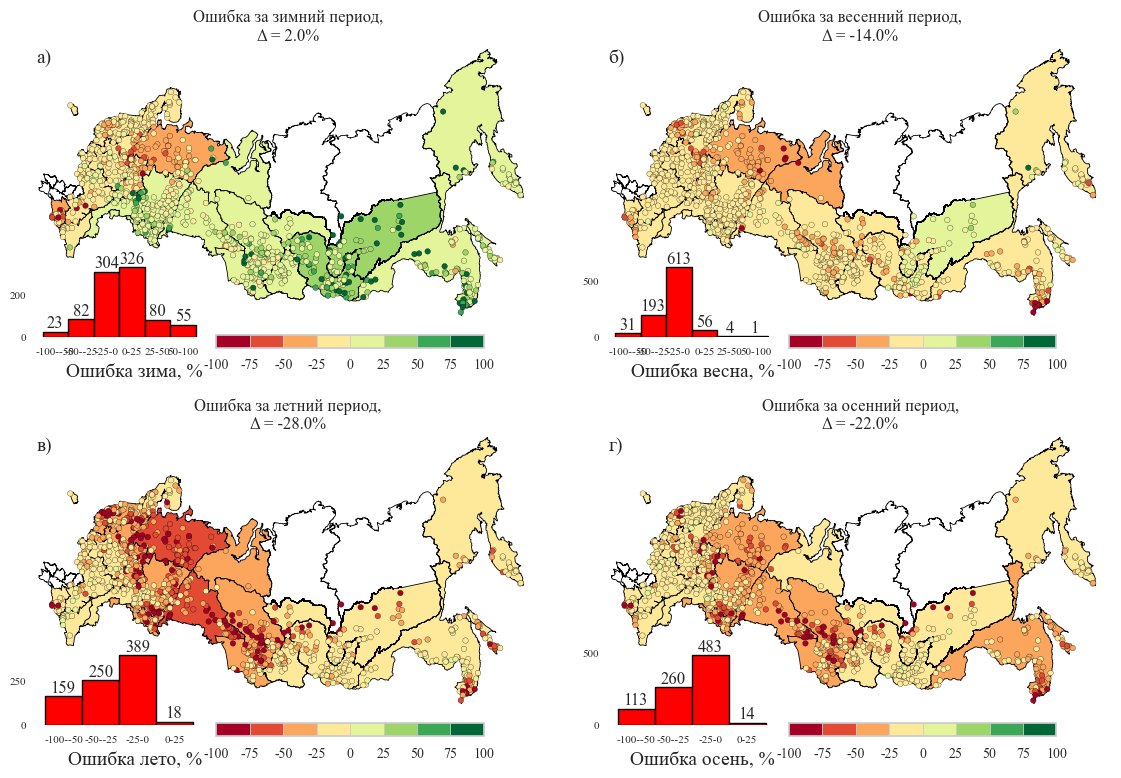

In [83]:
differ_models = russia_plots_n(gdf_to_plot=tft_era5l,
                               basemap_data=basemap_data,
                               figsize=(15, 8),
                               nrows=2,
                               ncols=2,
                               columns_from_gdf=['Ошибка зима, %', 'Ошибка весна, %',
                                                 'Ошибка лето, %', 'Ошибка осень, %'],
                               label_list=['а)', 'б)', 'в)', 'г)'],
                               with_histogram=True,
                               cmap_lims=(-100, 100),
                               list_of_limits=[-100, -50, -25, 0, 25, 50, 100],
                               title_text=[f'Ошибка за зимний период,\nΔ = {delta_winter}',
                                           f'Ошибка за весенний период,\nΔ = {delta_spring}',
                                           f'Ошибка за летний период,\nΔ = {delta_summer}',
                                           f'Ошибка за осенний период,\nΔ = {delta_autumn}'],
                               ugms=True, ugms_gdf=basin_districts)
differ_models.savefig('./images/errors_seasons.png',
                      dpi=1500, bbox_inches='tight')

### Static parameters description

In [166]:
static_params = pd.read_csv('../geo_data/attributes/geo_vector.csv')
static_params = static_params.set_index('gauge_id')
static_parameters = ['for_pc_sse', 'crp_pc_sse',
                     'inu_pc_ult', 'ire_pc_sse',
                     'lka_pc_use', 'prm_pc_sse',
                     'pst_pc_sse', 'cly_pc_sav',
                     'slt_pc_sav', 'snd_pc_sav',
                     'kar_pc_sse', 'urb_pc_sse',
                     'gwt_cm_sav', 'lkv_mc_usu',
                     'rev_mc_usu', 'sgr_dk_sav',
                     'slp_dg_sav', 'ws_area',
                     'ele_mt_sav']
static_final = static_params[static_parameters]

test_static = deepcopy(static_final)
test_static.index = test_static.index.astype(str)


for g_id in test_static.index:
    if str(g_id) in tft_era5l.index:
        pass
    else:
        test_static = test_static.drop(g_id)
        
test_static_big = deepcopy(static_params)
for g_id in test_static_big.index:
    if str(g_id) in tft_era5l.index:
        pass
    else:
        test_static_big = test_static_big.drop(g_id)

In [124]:
def pca95(df: pd.DataFrame) -> np.ndarray:
    scale_df = MinMaxScaler().fit_transform(df)

    pca_trans = PCA(n_components=0.95, random_state=42)
    pca_trans.fit(scale_df)

    reduced_df = pca_trans.transform(scale_df)

    return reduced_df


clusters_range = range(3, 20)
silhoute_result = dict()
data = pca95(test_static)

for i in clusters_range:
    km = KMeans(n_clusters=i, random_state=42, n_init=15)
    cluster_labels = km.fit_predict(data)
    silhouette_avg = silhouette_score(data, cluster_labels)
    silhoute_result[i] = silhouette_avg

In [228]:
def get_high_silhoute(input_df: pd.DataFrame):
    import matplotlib.ticker as ticker
    
    clusters_range = range(2, 21)
    silhoute_result = dict()
    data = pca95(input_df)

    for i in clusters_range:
        km = KMeans(n_clusters=i, random_state=42, n_init=15)
        cluster_labels = km.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhoute_result[i] = silhouette_avg
        
    plt.rcParams["font.family"] = "Times New Roman"
    fig, ax = plt.subplots(figsize=(15, 8))

    x = list(silhoute_result.keys())
    y = list(silhoute_result.values())

    ax.plot(x, y, '-')
    line_x = x[np.argmax(y)]
    ax.axvline(x=line_x, color='r')

    ax.set_xlabel('Количество кластеров, шт.', fontsize=14) 
    ax.set_ylabel('Величина силуэта', fontsize=14)
    ax.set_title(
        f'Максимальная величина силуэта найдена для {line_x} кластеров',
        fontsize=14)
    ax.xaxis.set_major_locator(
        ticker.FixedLocator(locs=[i for i in range(1, 21)]))
    ax.set_xticklabels([f'{i}' for i in range(1, 21)])
    
    plt.setp(ax.get_yticklabels(),
             fontsize=10)
    plt.setp(ax.get_xticklabels(),
             fontsize=10)
    ax.grid(False)
    plt.show()
    
    return fig

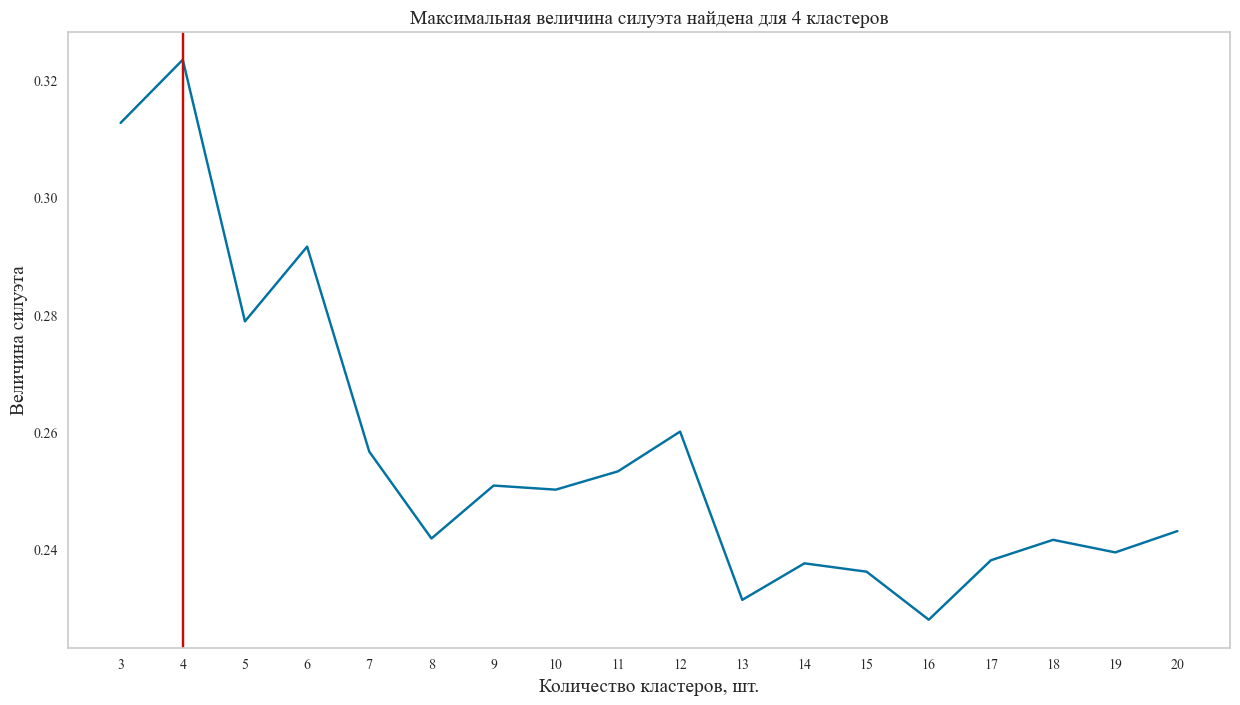

In [151]:
static_classic = get_high_silhoute(test_static)
static_classic.savefig('./images/static_default_physgeo.png',
                       dpi=1500, bbox_inches='tight')

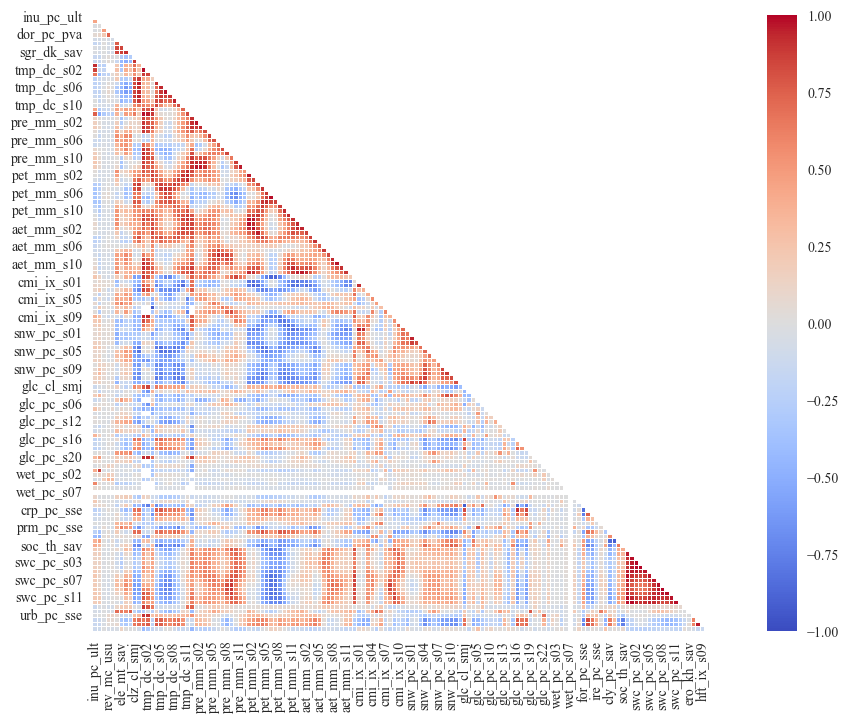

In [173]:
plt.rcParams["font.family"] = "Times New Roman"
# remove columns which had no representation in data
corr_frame = test_static_big.drop(['glc_pc_s01', 'glc_pc_s03',
                                   'glc_pc_s07', 'glc_pc_s08',
                                   'wet_pc_s05'], axis=1)
correlation_matrix = corr_frame.corr()
correlation_matrix = correlation_matrix.where(
    np.tril(np.ones(correlation_matrix.shape), k=-1).astype(bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', ax=ax,
            robust=True,
            vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 1});
plt.savefig('./images/corr_mat_everything.png',
            dpi=1500, bbox_inches='tight')


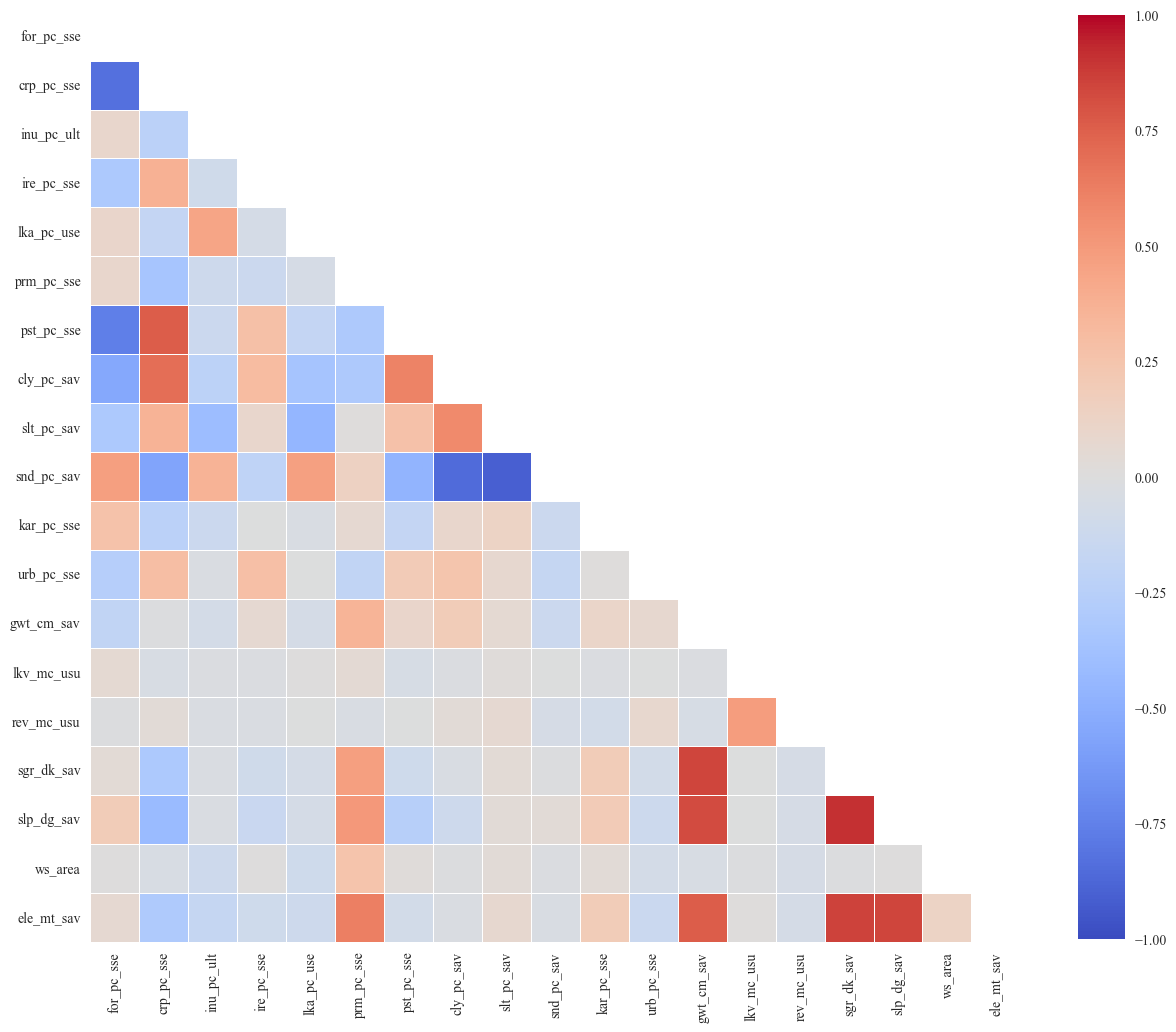

In [175]:
# remove columns which had no representation in data
correlation_matrix = test_static.corr()
correlation_matrix = correlation_matrix.where(
    np.tril(np.ones(correlation_matrix.shape), k=-1).astype(bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(correlation_matrix, cmap='coolwarm', ax=ax,
            robust=True,
            vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.8});
plt.savefig('./images/corr_mat_final.png',
            dpi=1500, bbox_inches='tight')


### Clusters based on static values order in tft

In [167]:
tft_static = pd.read_csv('../forecast/result/tft_by_gauge_static.csv')
tft_static['gauge_id'] = tft_static['gauge_id'].astype(str)
tft_static = tft_static.set_index('gauge_id', drop=True)
tft_static = tft_static[tft_static.index.isin(tft_era5l.index)]
tft_static

for_pc_sse  crp_pc_sse  inu_pc_ult  ire_pc_sse  lka_pc_use   
gauge_id                                                               
10620       1.536321    0.981264    3.262345    1.495815    1.936688  \
8306        0.643010   38.209555    0.719831    0.663329    4.847274   
78614       9.921046    0.825598    0.722537    2.222036    1.775828   
5287        0.630077    5.508376    7.658359    5.155208    1.196655   
2198        1.233185    0.838933    0.545819   10.376235    4.460650   
...              ...         ...         ...         ...         ...   
72603       0.758493   23.082277    0.678859   10.186093    6.240482   
72660       3.251546    3.307675    1.941737    1.521662    0.859296   
75576       5.215265    3.987650    5.151546   16.590343    2.576960   
83288       0.739353    6.262260    3.912663    1.096818    6.156144   
3210        2.322562   13.841724    1.017117    0.563127    0.636476   

          prm_pc_sse  pst_pc_sse  cly_pc_sav  slt_pc_sav  snd_pc_sav   
gauge_id                                                               
10620      64.866602    4.337567    1.426344    1.412909    1.766071  \
8306        0.907043    4.812509    2.506283    4.628784    5.727230   
78614       1.024988    2.632831    5.088431    5.096455    1.239382   
5287        6.317987    0.764545    1.057418    2.186410    2.317660   
2198        4.997325    4.693094    3.321991    0.567689    5.501205   
...              ...         ...         ...         ...         ...   
72603       2.315752    1.511101    2.742289    7.227344    4.865864   
72660      17.066474    1.436722    0.555228    9.722568    6.352772   
75576       1.200100    1.072677    2.985325    3.698246    5.309991   
83288       0.734157   10.818075    6.508484    1.091272   34.847695   
3210        3.560925    5.478534    3.060302    2.686714    1.064956   

          kar_pc_sse  urb_pc_sse  gwt_cm_sav  lkv_mc_usu  rev_mc_usu   
gauge_id                                                               
10620       0.929946    0.996013    0.995530    2.640635    0.409990  \
8306        7.971287    2.011538    2.039643    3.090566    5.116057   
78614       8.493590    3.075307    6.188953   31.288260    0.766142   
5287        2.322745    7.260954    2.467805   28.916684    1.491777   
2198        2.009829   27.442285    3.852467    1.255871    6.761649   
...              ...         ...         ...         ...         ...   
72603       1.947372    6.246084    6.211688    6.083347    3.662983   
72660       2.720113    1.042658   10.096829    2.306483    1.945897   
75576       1.327338    2.680716    9.797145    1.078059    0.968239   
83288       9.014682    1.696773    3.024414    3.303270    2.397063   
3210        6.232173    2.044176    9.490592   24.604291   10.195976   

          sgr_dk_sav  slp_dg_sav    ws_area  ele_mt_sav  
gauge_id                                                 
10620       1.654734    5.760129   1.469562    2.121532  
8306        1.234178    8.078911   3.217815    3.575151  
78614       2.860319    4.300021   1.379343   11.098927  
5287        1.009765   10.177813   8.894353    4.665410  
2198        2.176082    3.970586   6.940580    9.054524  
...              ...         ...        ...         ...  
72603       0.574737    1.652482  12.503505    1.509241  
72660       2.857724   17.473365   1.534415   14.006835  
75576       1.125265    0.615911  29.414016    5.205207  
83288       2.794272    1.127476   3.514998    0.960130  
3210        1.287614    3.270279   2.194462    6.448007  

[908 rows x 19 columns]

In [169]:
test_static = test_static[test_static.index.isin(tft_static.index)]

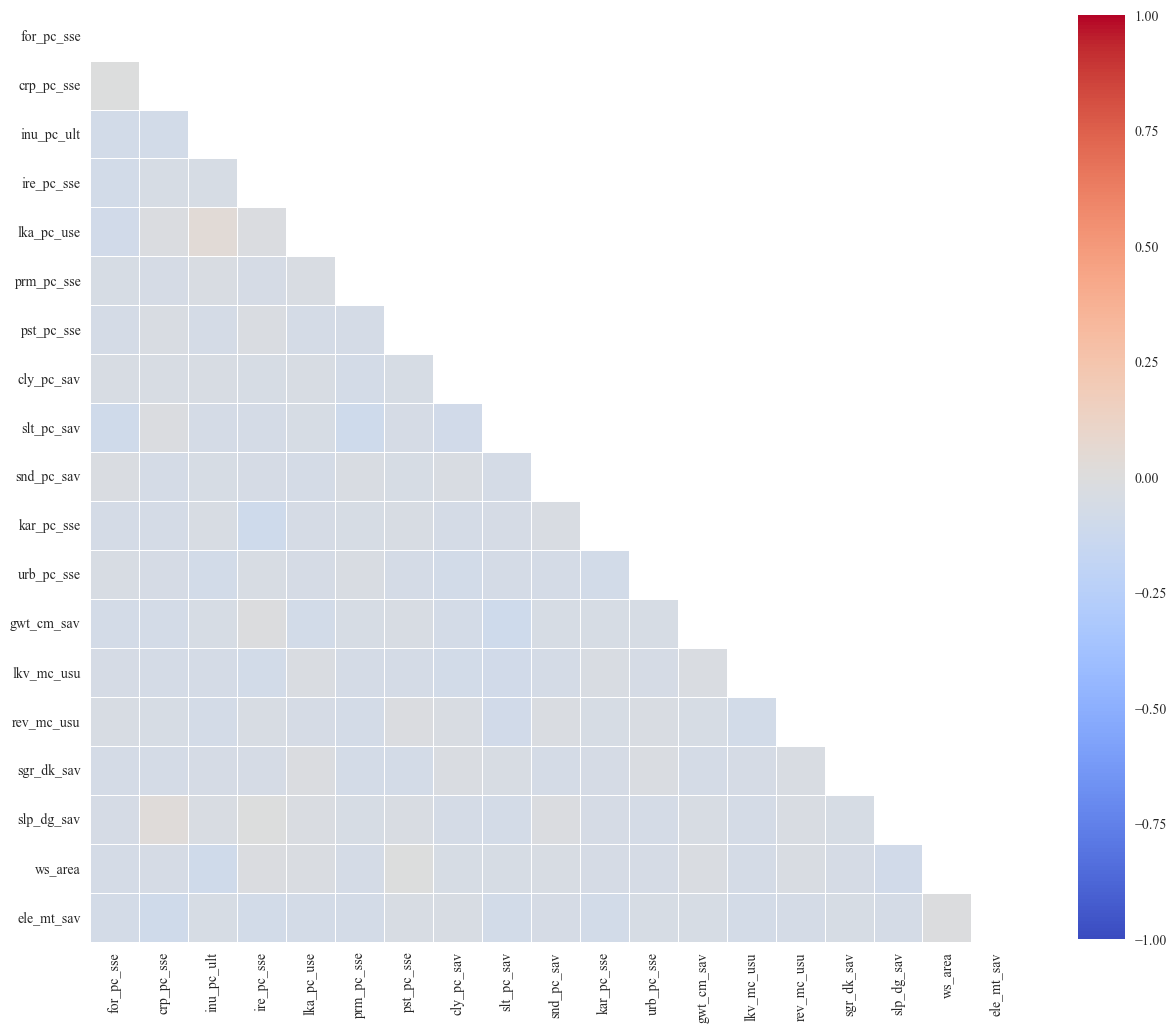

In [176]:
# remove columns which had no representation in data
correlation_matrix = tft_static.corr()
correlation_matrix = correlation_matrix.where(
    np.tril(np.ones(correlation_matrix.shape), k=-1).astype(bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(correlation_matrix, cmap='coolwarm', ax=ax,
            robust=True,
            vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.8});
plt.savefig('./images/corr_mat_tft.png',
            dpi=1500, bbox_inches='tight')


In [331]:
tft_cluster = deepcopy(
    tft_all_era5l.loc[tft_all_era5l.index.isin(tft_static.index)])


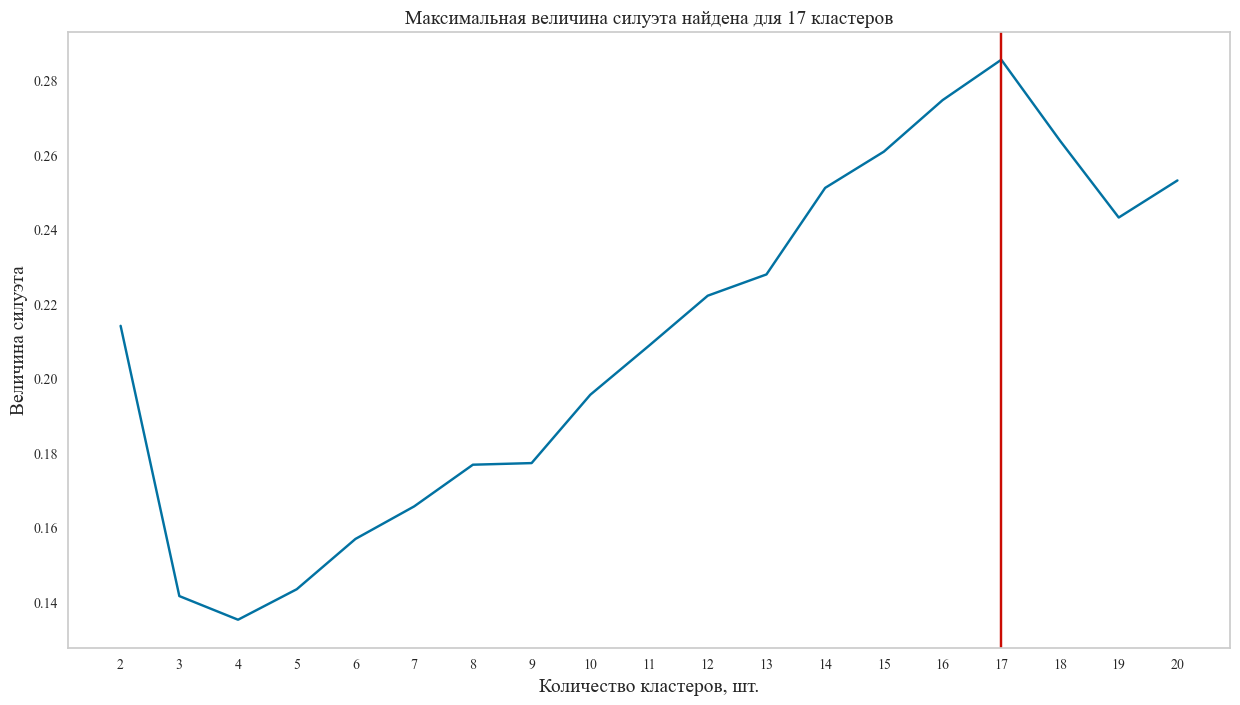

In [234]:
static_classic = get_high_silhoute(pca95(tft_static))
static_classic.savefig('./images/static_tft_physgeo.png',
                       dpi=1500, bbox_inches='tight')

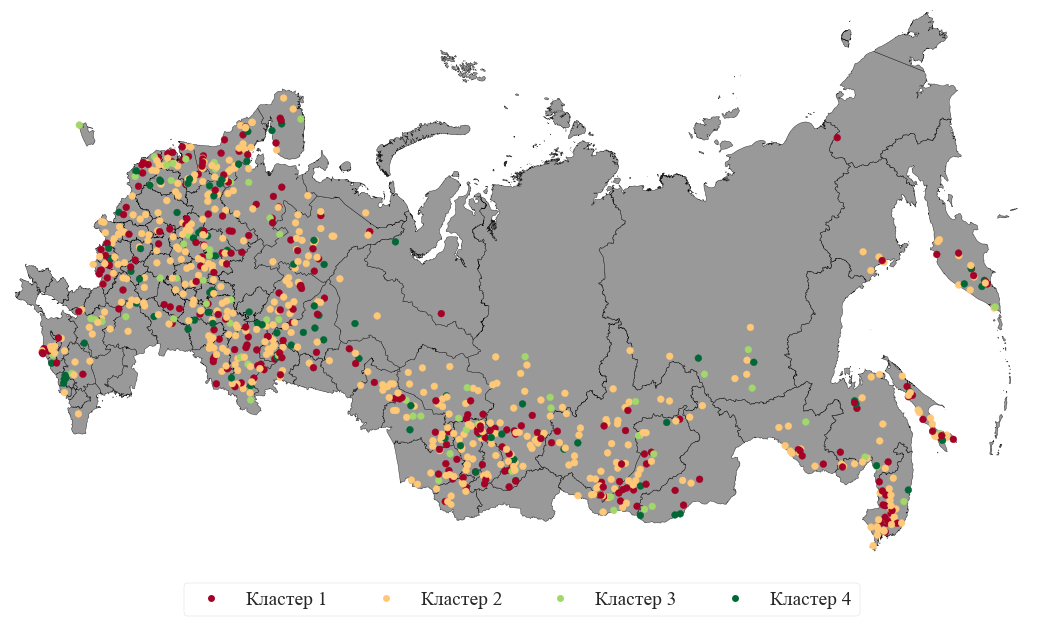

In [334]:
km = KMeans(n_clusters=4, random_state=42, n_init=15)

yhat_AC = km.fit_predict(tft_static.to_numpy())

tft_cluster['Кластер_tft'] = [f'Кластер {i+1}' for i in yhat_AC]
tft_cluster['Кластер_tft'] = tft_cluster['Кластер_tft'].sort_values()
tft_static['ResClust'] = [i+1 for i in yhat_AC]
tft_cluster['importance'] = tft_static.iloc[:, :-1].idxmax(axis=1)

gauges_fig = russia_plots(gdf_to_plot=tft_cluster,
                          basemap_data=basemap_data,
                          distinction_col='Кластер_tft',
                          # cmap_name='tab20',
                        #   metric_col='Кластер',
                          list_of_limits=list(range(1, 5)),
                          figsize=(15, 8),
                          just_points=True,
                          with_histogram=False)

gauges_fig.savefig('./images/clusters_Rus_tft.png',
                   dpi=1500, bbox_inches='tight')

In [335]:
cmap_name: str = 'RdYlGn'
cmap = cm.get_cmap(cmap_name, 4)
color_list = [mcolors.rgb2hex(cmap(i)) for i in range(cmap.N)]

polar = tft_static.groupby('ResClust').mean().reset_index()

polar = pd.melt(polar, id_vars=['ResClust'])


fig_polar = px.line_polar(polar, r='value', theta='variable',
                          color='ResClust', color_discrete_sequence=color_list,
                          template='seaborn', height=800, width=800)
fig_polar.update_layout(
    polar=dict(
        radialaxis=dict(showticklabels=False, ticks=''),
        angularaxis=dict(showticklabels=True, tickangle=0)
    ),
    legend_title_text='Кластеры',
    legend=dict(
        orientation="h",
        yanchor="middle",
        y=-.1,
        xanchor="center",
        x=0.5,
        bgcolor=None,
        bordercolor="Black",
        borderwidth=0
    )
)
fig_polar.write_image('./images/cluster_importance_tft.png')
fig_polar

### Attention vs Static clustering

In [253]:
tft_attention = pd.read_csv('../forecast/result/tft_by_gauge_attention.csv')
tft_attention['gauge_id'] = tft_attention['gauge_id'].astype(str)
tft_attention = tft_attention.set_index('gauge_id', drop=True)
tft_attention = tft_attention[tft_attention.index.isin(tft_era5l.index)]
tft_attention['median_attnt'] = tft_attention.iloc[:, :11].median(axis=1)

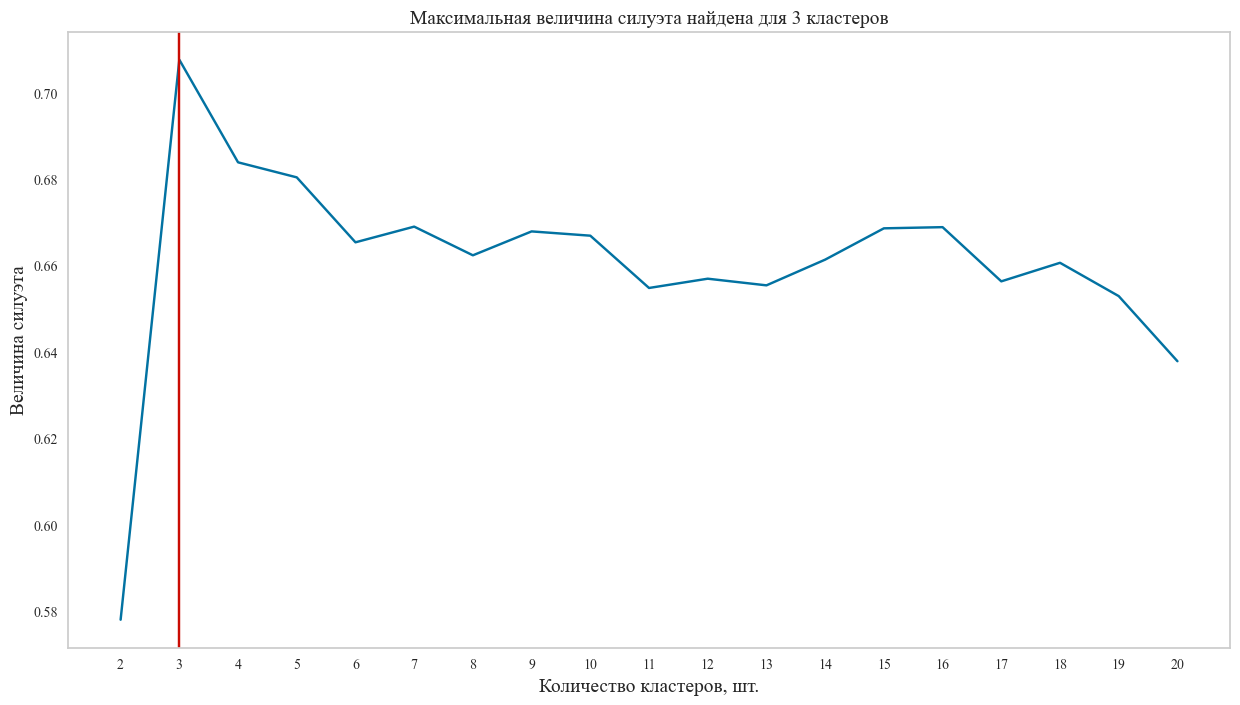

In [252]:
static_classic = get_high_silhoute(tft_attention['median_attnt'].values.reshape(-1, 1))
static_classic.savefig('./images/attention_tft.png',
                       dpi=1500, bbox_inches='tight')

In [340]:
tft_attention.iloc[:, :-2]

0    1    2    3    4    5    6    7    8    9  ...  356  357   
gauge_id                                                    ...             
10620     198  197  196  195  199  194  200  201  193  202  ...  360    5  \
8306      207  208  209  206  205  204  210  211  203  202  ...   33   36   
78614       1  365  364  363   16   17  362   15   12   11  ...  177  180   
5287      365  364  363  362  361  360  359  358  357  356  ...  207  215   
2198      364  365  361  362  363  360  359  358  357  329  ...  195  194   
...       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
72603       1  132  301  295  131  210  306  205  256  127  ...  356  358   
72660       1  211  210  205  209  212  213  208  204  214  ...   18   19   
75576     143  145  188  146  144  140  149  150  142  189  ...    7  357   
83288     365  364  363  362  361  360  359  358  357  356  ...  178  188   
3210      253  252  254  251  255  250  249  256  248  257  ...  138  146   

          358  359  360  361  362  363  364  median_attnt  
gauge_id                                                   
10620     361  362    4  363    3  364  365         198.0  
8306       24   23   35   31   32   21   19         207.0  
78614     183  187  174  182  181  175  176          16.0  
5287      214  208  213  212  211  209  210         360.0  
2198      192  191  190  187  184  186  185         360.0  
...       ...  ...  ...  ...  ...  ...  ...           ...  
72603     359  360  361  362  363  364  365         210.0  
72660      26   20   25   21   24   22   23         210.0  
75576     363  361  360  359  364  358  365         146.0  
83288     187  184  179  183  180  182  181         360.0  
3210      139  140  145  142  143  144  141         253.0  

[908 rows x 366 columns]

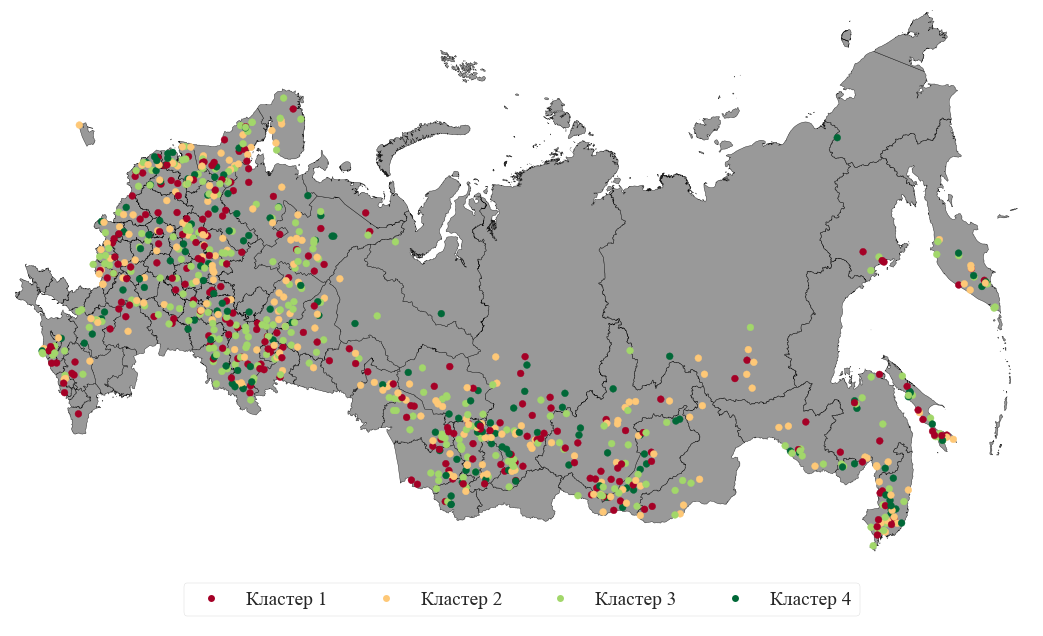

In [341]:
km = KMeans(n_clusters=4, random_state=42, n_init=15)

yhat_AC = km.fit_predict(tft_attention['median_attnt'].to_numpy().reshape(-1, 1))

tft_cluster['Кластер_tft'] = [f'Кластер {i+1}' for i in yhat_AC]
tft_cluster['Кластер_tft'] = tft_cluster['Кластер_tft'].sort_values()
tft_attention['ResClust'] = [i+1 for i in yhat_AC]
tft_cluster['attention'] = tft_attention.iloc[:, :-2].idxmax(axis=1)

gauges_fig = russia_plots(gdf_to_plot=tft_cluster,
                          basemap_data=basemap_data,
                          distinction_col='Кластер_tft',
                        #   cmap_name='tab20',
                        #   metric_col='Кластер',
                          list_of_limits=list(range(1, 18)),
                          figsize=(15, 8),
                          just_points=True,
                          with_histogram=False)

gauges_fig.savefig('./images/clusters_attention.png',
                   dpi=1500, bbox_inches='tight')

In [342]:
cmap_name: str = 'tab20'
cmap = cm.get_cmap(cmap_name, 17)
color_list = [mcolors.rgb2hex(cmap(i)) for i in range(cmap.N)]

polar = tft_attention[['median_attnt', 'ResClust']].groupby('ResClust').mean().reset_index()

polar = pd.melt(polar, id_vars=['ResClust'])
polar.to_csv('./tables/attention_clusters.csv', index=False)
polar

ResClust      variable       value
0         1  median_attnt   16.074380
1         2  median_attnt  337.085586
2         3  median_attnt  194.718310
3         4  median_attnt  117.068750

In [286]:
{val: len(g) for val, g in tft_cluster.groupby('importance').groups.items()}

{'ResClust': 8,
 'cly_pc_sav': 42,
 'crp_pc_sse': 49,
 'ele_mt_sav': 63,
 'for_pc_sse': 65,
 'gwt_cm_sav': 36,
 'inu_pc_ult': 45,
 'ire_pc_sse': 45,
 'kar_pc_sse': 58,
 'lka_pc_use': 26,
 'lkv_mc_usu': 71,
 'prm_pc_sse': 56,
 'pst_pc_sse': 33,
 'rev_mc_usu': 37,
 'sgr_dk_sav': 42,
 'slp_dg_sav': 40,
 'slt_pc_sav': 71,
 'snd_pc_sav': 38,
 'urb_pc_sse': 46,
 'ws_area': 37}

In [292]:
{val: len(g) for val, g in tft_cluster.groupby('importance').groups.items()}

{'ResClust': 3,
 'cly_pc_sav': 42,
 'crp_pc_sse': 49,
 'ele_mt_sav': 64,
 'for_pc_sse': 65,
 'gwt_cm_sav': 37,
 'inu_pc_ult': 45,
 'ire_pc_sse': 45,
 'kar_pc_sse': 58,
 'lka_pc_use': 26,
 'lkv_mc_usu': 74,
 'prm_pc_sse': 56,
 'pst_pc_sse': 33,
 'rev_mc_usu': 39,
 'sgr_dk_sav': 39,
 'slp_dg_sav': 40,
 'slt_pc_sav': 72,
 'snd_pc_sav': 38,
 'urb_pc_sse': 46,
 'ws_area': 37}

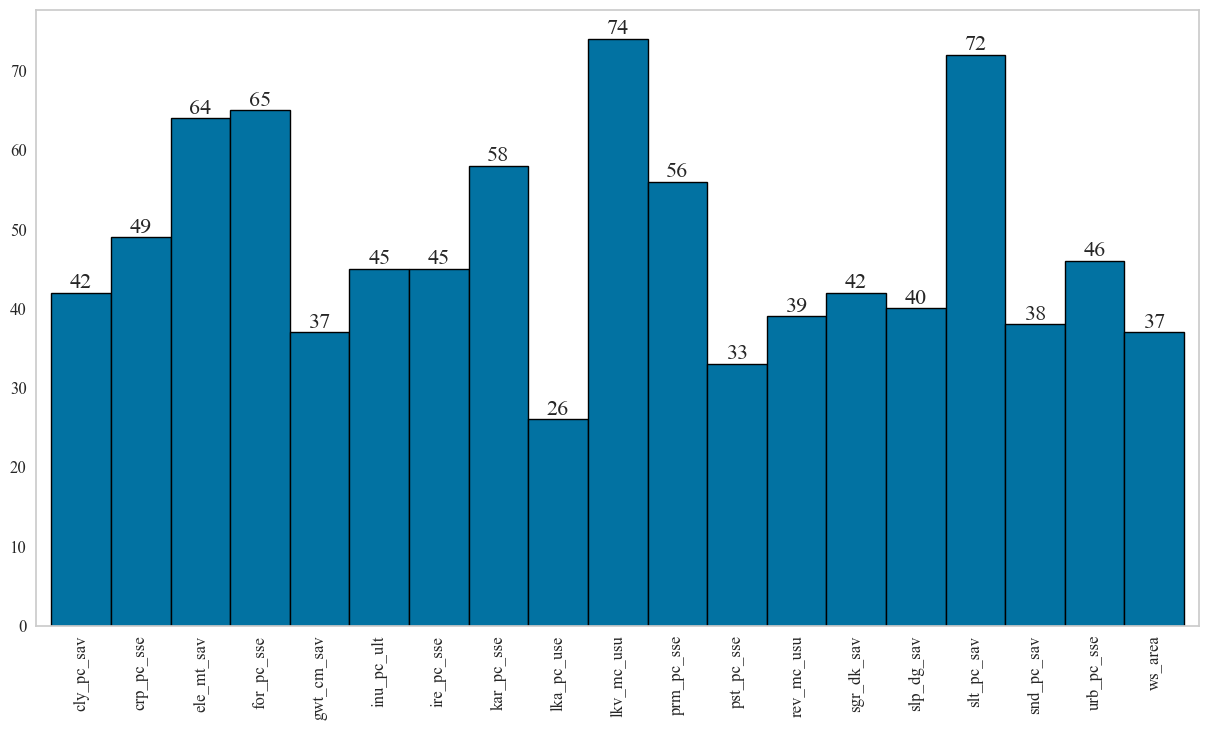

In [79]:
clust_hist = pd.DataFrame({val: len(g) for val, g in tft_cluster.groupby('importance').groups.items()},
                          index=[0]).T.plot.bar(figsize=(15, 8),
                                                rot=90,
                                                width=1,
                                                edgecolor='black',
                                                grid=False, legend=False,
                                                lw=1)
clust_hist.bar_label(clust_hist.containers[0], fmt='%.0f',
                     fontsize=16);
plt.setp(clust_hist.get_xticklabels(),
            fontsize=12)
plt.setp(clust_hist.get_yticklabels(),
            fontsize=12);
plt.savefig('./images/clust_dominance.png',
            dpi=1000, bbox_inches='tight')

In [ ]:
# tft single era5l
tft_static, nse_tft = metric_viewer(metric_csv='../forecast/result/tft_by_gauge_static_final.csv',
                                   metric_col='NSE',
                                   gauges_file=gauges_file)
tft_test_cluster = deepcopy(tft_static[['static']])
import ast

static_dict = {param: code+1 for code, param
               in zip(pd.Categorical(static_parameters).codes,
                      static_parameters)}

def static_as_int(static_dict: dict,
                  row):
    return list(map(lambda x: static_dict[x],
                    ast.literal_eval(row)))

for g in tft_test_cluster.index:
    tft_test_cluster.loc[g, ['x1', 'x2', 'x3', 'x4']] = static_as_int(
        static_dict=static_dict,
        row=tft_test_cluster.loc[g, 'static'])
tft_test_cluster = tft_test_cluster[['x1', 'x2', 'x3', 'x4']]

In [314]:
static_params = pd.read_csv('../geo_data/attributes/geo_vector.csv')
static_params = static_params.set_index('gauge_id')
static_parameters = ['for_pc_sse', 'crp_pc_sse',
                     'inu_pc_ult', 'ire_pc_sse',
                     'lka_pc_use', 'prm_pc_sse',
                     'pst_pc_sse', 'cly_pc_sav',
                     'slt_pc_sav', 'snd_pc_sav',
                     'kar_pc_sse', 'urb_pc_sse',
                     'gwt_cm_sav', 'lkv_mc_usu',
                     'rev_mc_usu', 'sgr_dk_sav',
                     'slp_dg_sav', 'ws_area',
                     'ele_mt_sav']
static_final = static_params[static_parameters]

test_static = deepcopy(static_final)
test_static.index = test_static.index.astype(str)

In [304]:
test_static.loc[test_static.index.isin(tft_all_era5l.index), :]

for_pc_sse  crp_pc_sse  inu_pc_ult  ire_pc_sse  lka_pc_use   
gauge_id                                                               
9164       78.120000    0.000000    0.000000         0.0    0.092000  \
9166       85.333333    0.000000    0.209877         0.0    0.067901   
9169       86.428571    0.000000    0.000000         0.0    0.057143   
9189       73.307692   19.076923    0.153846         0.0    0.046154   
9191       85.000000    8.473684    0.000000         0.0    0.047368   
...              ...         ...         ...         ...         ...   
10204      77.756757    6.000000    0.000000         0.0    0.018919   
10246      80.923241    7.592751    0.029851         0.0    0.101919   
10387      73.873016   14.031746    0.071429         0.0    0.192857   
11350      71.951807    1.566265   42.361446         0.0    0.204819   
2027       52.500000    0.000000    0.250000         0.0    0.200000   

          prm_pc_sse  pst_pc_sse  cly_pc_sav  slt_pc_sav  snd_pc_sav   
gauge_id                                                               
9164       51.880000    0.000000   10.960000   39.160000   50.080000  \
9166       38.382716    0.000000   11.888889   41.802469   46.345679   
9169       48.285714    0.000000   10.571429   39.857143   49.714286   
9189        6.384615   11.384615   14.692308   42.538462   42.769231   
9191       16.500000    5.447368   14.657895   42.394737   42.973684   
...              ...         ...         ...         ...         ...   
10204       0.000000    7.054054   14.378378   48.216216   37.270270   
10246       5.174840    4.535181   14.844350   44.995736   40.134328   
10387       3.857143   10.904762   14.396825   45.103175   40.587302   
11350       0.433735    5.638554   13.108434   35.313253   51.554217   
2027       17.250000    0.000000    6.000000   56.750000   37.250000   

          kar_pc_sse  urb_pc_sse  gwt_cm_sav   lkv_mc_usu   rev_mc_usu   
gauge_id                                                                 
9164       53.600000    0.000000  370.280000     1.720000     0.000000  \
9166       71.604938    0.000000  344.444444   445.308642     0.000000   
9169       70.142857    0.000000  394.142857     3.714286     0.000000   
9189        0.000000    0.076923  223.615385  3350.923077  2407.692308   
9191        0.894737    0.368421  279.842105     2.605263     0.000000   
...              ...         ...         ...          ...          ...   
10204      89.135135    0.351351   88.513514     0.702703     0.000000   
10246      24.066098    1.897655  163.893390    12.162047     0.000000   
10387      20.380952    0.333333  107.071429    29.793651     0.000000   
11350       0.000000    0.000000    3.469880     3.771084     0.000000   
2027        0.000000    0.000000  208.000000     3.250000     0.000000   

          sgr_dk_sav  slp_dg_sav       ws_area   ele_mt_sav  
gauge_id                                                     
9164      314.560000   14.984000   1254.320139  1406.880000  
9166      263.580247   14.067901   5743.573901  1263.938272  
9169      310.000000   15.771429    211.358746  1399.000000  
9189      132.153846    9.476923    529.141565   647.384615  
9191      179.342105   11.313158   2510.623856   814.657895  
...              ...         ...           ...          ...  
10204      53.702703    3.221622   2525.991764   322.783784  
10246     115.643923    8.213859  47275.698864   536.609808  
10387      81.333333    5.233333  10537.785868   424.833333  
11350       7.000000    0.191566   6536.849741   129.277108  
2027      181.500000    9.275000     67.550883   633.750000  

[908 rows x 19 columns]

In [322]:
static_params = pd.read_csv('../geo_data/attributes/geo_vector.csv')
static_params = static_params.set_index('gauge_id')
static_parameters = ['for_pc_sse', 'crp_pc_sse',
                     'inu_pc_ult', 'ire_pc_sse',
                     'lka_pc_use', 'prm_pc_sse',
                     'pst_pc_sse', 'cly_pc_sav',
                     'slt_pc_sav', 'snd_pc_sav',
                     'kar_pc_sse', 'urb_pc_sse',
                     'gwt_cm_sav', 'lkv_mc_usu',
                     'rev_mc_usu', 'sgr_dk_sav',
                     'slp_dg_sav', 'ws_area',
                     'ele_mt_sav']
static_final = static_params[static_parameters]

test_static = deepcopy(static_final)
test_static.index = test_static.index.astype(str)

test_static = test_static.loc[test_static.index.isin(tft_all_era5l.index), :]

test_static.loc[:, :] = MinMaxScaler().fit_transform(test_static.values)
km = KMeans(n_clusters=4, random_state=42, n_init=15)

yhat_AC = km.fit_predict(test_static)
tft_all_era5l = tft_all_era5l.loc[tft_all_era5l.index.isin(test_static.index), :]
tft_all_era5l['Кластер'] = [str(f'Кластер {i+1}')for i in yhat_AC]
test_static['ResClust'] = [i+1 for i in yhat_AC]
# test_static['color'] = test_static['ResClust'].apply(
    # lambda x: dict(zip([1, 2, 3, 4], color_list))[x])

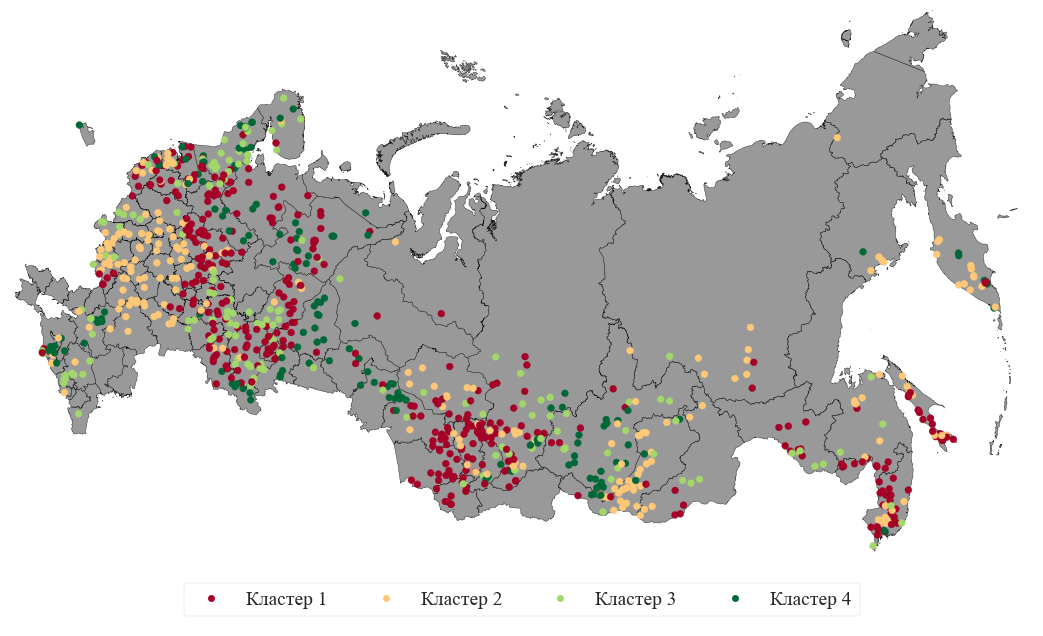

In [329]:
gauges_fig = russia_plots(gdf_to_plot=tft_all_era5l,
                          basemap_data=basemap_data,
                          distinction_col='Кластер',
                        #   metric_col='Кластер',
                          list_of_limits=[0, 1, 2, 3, 4],
                          figsize=(15, 8),
                          just_points=True,
                          with_histogram=False)

In [ ]:
cmap_name: str = 'RdYlGn'
cmap = cm.get_cmap(cmap_name, 4)
color_list = [mcolors.rgb2hex(cmap(i)) for i in range(cmap.N)]

polar = test_static.groupby('ResClust').mean().reset_index()

polar = pd.melt(polar, id_vars=['ResClust'])


fig_polar = px.line_polar(polar, r='value', theta='variable',
                          color='ResClust', color_discrete_sequence=color_list,
                          template='seaborn', height=800, width=800)
fig_polar.update_layout(
    polar=dict(
        # radialaxis_angle = -45
        radialaxis=dict(showticklabels=False, ticks=''),
        angularaxis=dict(showticklabels=True, tickangle=0)
    ),
    legend_title_text='Кластеры',
    legend=dict(
        orientation="h",
        yanchor="middle",
        y=-.1,
        xanchor="center",
        x=0.5,
        bgcolor=None,
        bordercolor="Black",
        borderwidth=0
    )
)
fig_polar.write_image('./images/cluster_importance.png')

In [313]:
fig_polar

### temp

In [ ]:
from forecast.scripts.model_eval import nse
lost_df = pd.DataFrame()
for i, file in enumerate(glob.glob('../forecast/result/lost_gauge/*.csv')):
    gauge_id = file.split('/')[-1][:-4]
    compare_res = pd.read_csv(f'../forecast/result/lost_gauge/{gauge_id}.csv')
    # get nse
    pred_nse = nse(pred=compare_res['q_mm_day_pred'],
                   target=compare_res['q_mm_day'])
    lost_df.loc[i, 'gauge_id'] = gauge_id
    lost_df.loc[i, 'NSE'] = pred_nse
lost_df